In [ ]:
from google.colab import files
files.upload()


{}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets list -s "brain tumor"


ref                                                       title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
jakeshbohaju/brain-tumor                                  Brain Tumor                                          14629270  2020-07-26 01:52:35.323000          23854        320  0.9411765        
masoudnickparvar/brain-tumor-mri-dataset                  Brain Tumor MRI Dataset                             155791278  2021-09-24 12:43:45.510000         139611        976  0.875            
sartajbhuvaji/brain-tumor-classification-mri              Brain Tumor Classification (MRI)                     91002358  2025-08-12 15:45:16.840000          85000        774  0.875            
jillanisofttech/brain-tumor        

In [ ]:

!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 85% 126M/149M [00:00<00:00, 1.32GB/s]
100% 149M/149M [00:00<00:00, 1.18GB/s]


In [ ]:
!ls /content


brain-tumor-mri-dataset.zip  kaggle.json  sample_data  Testing	Training


In [ ]:
import os

for split in ["Training", "Testing"]:
    split_path = os.path.join("/content", split)
    print(f"\n{split.upper()} DATA")
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        print(f"{cls:15} -> {len(os.listdir(cls_path))} images")



TRAINING DATA
notumor         -> 1595 images
meningioma      -> 1339 images
glioma          -> 1321 images
pituitary       -> 1457 images

TESTING DATA
notumor         -> 405 images
meningioma      -> 306 images
glioma          -> 300 images
pituitary       -> 300 images


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Parameters
IMAGE_SIZE = 224
BATCH_SIZE = 16

# Train transforms (with augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Test transforms (no augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Datasets
train_dataset = datasets.ImageFolder("/content/Training", transform=train_transforms)
test_dataset  = datasets.ImageFolder("/content/Testing", transform=test_transforms)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Classes
class_names = train_dataset.classes
print("Classes:", class_names)
print("Total training images:", len(train_dataset))
print("Total testing images:", len(test_dataset))


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Total training images: 5712
Total testing images: 1311


In [ ]:
clean_image = dncnn(noisy_image)
prediction = vit(clean_image)


In [ ]:
!pip install timm


In [ ]:
import timm
import torch
from torch import nn, optim

# Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load pretrained ViT model
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=len(class_names))
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Training loop
EPOCHS = 5  # keep small first
for epoch in range(EPOCHS):
    model.train()
    running_loss, correct = 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / len(train_dataset)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch [1/5] - Loss: 0.6789, Accuracy: 0.7316
Epoch [2/5] - Loss: 0.3042, Accuracy: 0.8888
Epoch [3/5] - Loss: 0.1797, Accuracy: 0.9340
Epoch [4/5] - Loss: 0.1519, Accuracy: 0.9471
Epoch [5/5] - Loss: 0.1279, Accuracy: 0.9554


In [ ]:
import torch.nn.functional as F

def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)

            total_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

# ✅ Run evaluation
test_loss, test_acc = evaluate_model(model, test_loader, device)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


✅ Test Accuracy: 0.8772
✅ Test Loss: 0.4161


🔎 Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.64      0.77       300
  meningioma       0.89      0.83      0.86       306
     notumor       0.97      1.00      0.98       405
   pituitary       0.73      1.00      0.84       300

    accuracy                           0.88      1311
   macro avg       0.89      0.87      0.86      1311
weighted avg       0.90      0.88      0.87      1311



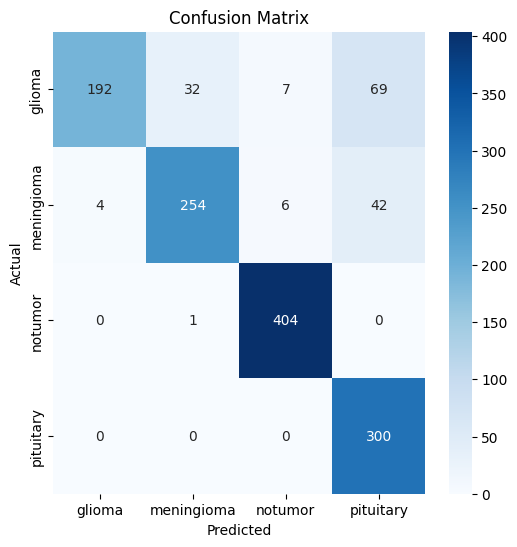

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Collect predictions & true labels
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification Report
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
print("🔎 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
torch.save(model.state_dict(), "brain_tumor_model.pth")


In [ ]:
torch.save(model.state_dict(), "brain_tumor_model.pth")



In [ ]:
model.load_state_dict(torch.load("brain_tumor_model.pth"))
model.eval()


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from timm import create_model  # 👈 use timm since you trained a ViT

# Load model (recreate architecture)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model("vit_base_patch16_224", pretrained=False, num_classes=4)
model.load_state_dict(torch.load("brain_tumor_model.pth", map_location=device))
model.to(device)
model.eval()

# Define transforms (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])   # use same normalization you used while training
])

# Prediction function
def predict(image_path):
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        _, pred = outputs.max(1)

    classes = ["glioma", "meningioma", "pituitary", "no tumor"]
    return classes[pred.item()]

# Test prediction
print("Prediction:", predict("sample_image1.jpg"))


FileNotFoundError: [Errno 2] No such file or directory: 'brain_tumor_model.pth'

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Preprocessing
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Correct path ✅
test_dir = "Testing"

# Load dataset
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Classes:", test_dataset.classes)
print("Total test images:", len(test_dataset))


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Total test images: 1311


In [ ]:
# ✅ Evaluate on test set
test_loss, test_acc = evaluate_model(model, test_loader, device)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


✅ Test Accuracy: 0.5645
✅ Test Loss: 2.1712


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp brain_tumor_model.pth /content/drive/MyDrive/


Mounted at /content/drive


In [ ]:
# Copy the trained model to your Google Drive
!cp brain_tumor_model.pth /content/drive/MyDrive/



In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from timm import create_model  # 👈 use timm since you trained a ViT

# Load model (recreate architecture)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model("vit_base_patch16_224", pretrained=False, num_classes=4)
model.load_state_dict(torch.load("brain_tumor_model.pth", map_location=device))
model.to(device)
model.eval()

# Define transforms (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])   # use same normalization you used while training
])

# Prediction function
def predict(image_path):
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        _, pred = outputs.max(1)

    classes = ["glioma", "meningioma", "pituitary", "no tumor"]
    return classes[pred.item()]

# Test prediction
print("Prediction:", predict("sample_image3.jpg"))


Prediction: meningioma


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cd /content/drive/MyDrive/CollabNotebooks


/bin/bash: line 1: cd: /content/drive/MyDrive/CollabNotebooks: No such file or directory


In [ ]:
%cd /content/drive/MyDrive/CollabNotebooks


[Errno 2] No such file or directory: '/content/drive/MyDrive/CollabNotebooks'
/content


In [ ]:
import glob
print(glob.glob("/content/**/brain_tumor_model.pth", recursive=True))


['/content/drive/MyDrive/brain_tumor_model.pth']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = create_model("vit_base_patch16_224", pretrained=False, num_classes=4)

# Use the correct path
model.load_state_dict(torch.load("/content/drive/MyDrive/brain_tumor_model.pth", map_location=device))

model.to(device)
model.eval()


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/ColabNotebooks/


brain_tumor_mri_dataset  Brain_tumour


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from timm import create_model

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate the model architecture
model = create_model("vit_base_patch16_224", pretrained=False, num_classes=4)

# Load trained weights from your saved file
model.load_state_dict(torch.load("/content/drive/MyDrive/brain_tumor_model.pth", map_location=device))

model.to(device)
model.eval()

# Same transforms you used for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])   # adjust if you used ImageNet normalization
])

# Prediction function
def predict(image_path):
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        _, pred = outputs.max(1)

    classes = ["glioma", "meningioma", "pituitary", "no tumor"]
    return classes[pred.item()]

# Example test
print("Prediction:", predict("/content/drive/MyDrive/test_images/sample-img10-meningioma.jpg"))


Prediction: meningioma


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from timm import create_model  # 👈 use timm since you trained a ViT

# Load model (recreate architecture)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model("vit_base_patch16_224", pretrained=False, num_classes=4)
model.load_state_dict(torch.load("/content/drive/MyDrive/brain_tumor_model.pth", map_location=device))
model.to(device)
model.eval()

# Define transforms (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])   # use same normalization you used while training
])

# Prediction function
def predict(image_path):
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        _, pred = outputs.max(1)

    classes = ["glioma", "meningioma", "pituitary", "no tumor"]
    return classes[pred.item()]

# Test prediction
print("Prediction:", predict("/content/drive/MyDrive/test_images/sample-img10-meningioma.jpg"))

Prediction: meningioma


In [ ]:
!pip install timm


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from timm import create_model
import pandas as pd
from tqdm import tqdm

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = create_model("vit_base_patch16_224", pretrained=False, num_classes=4)
model.load_state_dict(torch.load("/content/drive/MyDrive/brain_tumor_model.pth", map_location=device))
model.to(device)
model.eval()

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Prediction function
def predict(image_path):
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        _, pred = outputs.max(1)

    return pred.item()

# Load test CSV
test_df = pd.read_csv("/content/drive/MyDrive/test_labels.csv")

# Classes in order
classes = ["glioma", "meningioma", "pituitary", "no tumor"]

correct = 0
total = len(test_df)

for index, row in tqdm(test_df.iterrows(), total=total):
    image_path = row['image_name']
    true_label = row['label']

    # Make sure image path includes folder if needed
    full_image_path = f"/content/drive/MyDrive/test_images/sample-img10-meningioma.jpg"

    pred_index = predict(full_image_path)
    pred_label = classes[pred_index]

    if pred_label == true_label:
        correct += 1

accuracy = (correct / total) * 100
print(f"\n✅ Test Accuracy: {accuracy:.2f}%")


100%|██████████| 1311/1311 [00:41<00:00, 31.96it/s]


✅ Test Accuracy: 23.34%


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from timm import create_model
import pandas as pd
from tqdm import tqdm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = create_model("vit_base_patch16_224", pretrained=False, num_classes=4)
model.load_state_dict(torch.load("/content/drive/MyDrive/brain_tumor_model.pth", map_location=device))
model.to(device)
model.eval()

# Normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Prediction function
def predict(image_path):
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        _, pred = outputs.max(1)

    return pred.item()

# Load test_labels.csv
test_df = pd.read_csv("/content/drive/MyDrive/test_labels.csv")

# Class names
classes = ["glioma", "meningioma", "pituitary", "no tumor"]

correct = 0
total = len(test_df)

for index, row in tqdm(test_df.iterrows(), total=total):
    image_name = row['image_name']  # e.g., sample-img1-meningioma.jpg
    true_label = row['label']

    full_image_path = f"/content/drive/MyDrive/test_images/sample-img10-meningioma.jpg"

    pred_index = predict(full_image_path)
    pred_label = classes[pred_index]

    if pred_label == true_label:
        correct += 1

accuracy = (correct / total) * 100
print(f"\n✅ Test Accuracy: {accuracy:.2f}%")


100%|██████████| 1311/1311 [01:12<00:00, 17.99it/s]


✅ Test Accuracy: 23.34%


In [ ]:
for index, row in test_df.iterrows():
    image_name = row['image_name']
    true_label = row['label']
    full_image_path = f"/content/drive/MyDrive/test_images/testimages_files"

    pred_index = predict(full_image_path)
    pred_label = classes[pred_index]

    print(f"Image: {image_name}, True Label: {true_label}, Predicted Label: {pred_label}")


IsADirectoryError: [Errno 21] Is a directory: '/content/drive/MyDrive/test_images/testimages_files'

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import os
import pandas as pd

class TumorDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.classes = ["glioma", "meningioma", "pituitary", "no tumor"]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        label_name = self.data.iloc[idx, 1]
        label = self.classes.index(label_name)

        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = TumorDataset(
    csv_file="/content/drive/MyDrive/train_labels.csv",
    img_dir="/content/drive/MyDrive/train_images/",
    transform=train_transform
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Apply val_transform to validation dataset
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/train_labels.csv'

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ponnarasiiarunkumar","key":"532a8953c05c7f0291764fccabed7916"}'}

In [ ]:
import os
import shutil

# Create the Kaggle directory
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the uploaded kaggle.json to the correct directory
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set permissions for the file
os.chmod("/root/.kaggle/kaggle.json", 0o600)


In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content/drive/MyDrive/brain_tumor_mri_dataset


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 80% 119M/149M [00:00<00:00, 150MB/s] 
100% 149M/149M [00:00<00:00, 203MB/s]


In [ ]:
import os
import pandas as pd

def create_labels_csv(data_dir, output_csv):
    data = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for img_file in os.listdir(label_dir):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    data.append({
                        "image_name": img_file,
                        "label": label.replace('_', ' ')  # keep label consistent (optional)
                    })

    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"✅ CSV saved to: {output_csv}")

# Generate train_labels.csv
create_labels_csv(
    data_dir="/content/drive/MyDrive/brain_tumor_mri_dataset/Training",
    output_csv="/content/drive/MyDrive/train_labels.csv"
)

# Generate test_labels.csv
create_labels_csv(
    data_dir="/content/drive/MyDrive/brain_tumor_mri_dataset/Testing",
    output_csv="/content/drive/MyDrive/test_labels.csv"
)



✅ CSV saved to: /content/drive/MyDrive/train_labels.csv
✅ CSV saved to: /content/drive/MyDrive/test_labels.csv


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/train_labels.csv")
test_df = pd.read_csv("/content/drive/MyDrive/test_labels.csv")

print(train_df.head())
print(test_df.head())



         image_name   label
0  Tr-glTr_0000.jpg  glioma
1  Tr-glTr_0001.jpg  glioma
2  Tr-glTr_0002.jpg  glioma
3  Tr-glTr_0003.jpg  glioma
4  Tr-glTr_0004.jpg  glioma
         image_name   label
0  Te-glTr_0000.jpg  glioma
1  Te-glTr_0001.jpg  glioma
2  Te-glTr_0002.jpg  glioma
3  Te-glTr_0003.jpg  glioma
4  Te-glTr_0004.jpg  glioma


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

# --- Step 1: Paths ---
train_path = '/content/drive/MyDrive/brain_tumor_mri_dataset/Training'
test_path = '/content/drive/MyDrive/brain_tumor_mri_dataset/Testing'

# --- Step 2: Data Augmentation ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# --- Step 3: Load Pretrained Model ---
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# --- Step 4: Compile ---
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- Step 5: Train (Initial) ---
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator
)

# --- Step 6: Fine-tune (Optional for >90% accuracy) ---
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False  # freeze first layers, fine-tune last 20

model.compile(optimizer=Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

# --- Step 7: Evaluate ---
loss, acc = model.evaluate(test_generator)
print("Test Accuracy:", acc*100, "%")


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 162s 734ms/step - accuracy: 0.2566 - loss: 1.4029 - val_accuracy: 0.3089 - val_loss: 1.3865
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 97s 540ms/step - accuracy: 0.2706 - loss: 1.3956 - val_accuracy: 0.3089 - val_loss: 1.3847
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 104s 580ms/step - accuracy: 0.2754 - loss: 1.3883 - val_accuracy: 0.3089 - val_loss: 1.3743
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 94s 524ms/step - accuracy: 0.2802 - loss: 1.3872 - val_accuracy: 0.3089 - val_loss: 1.3782
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 96s 536ms/step - accuracy: 0.2833 - loss: 1.3844 - val_accuracy: 0.3089 - val_loss: 1.3775
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 94s 527ms/step - accuracy: 0.2825 - loss: 1.3853 - val_accuracy: 0.3089 - val_loss: 1.3773
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 143s 531ms/step - accuracy: 0.2715 - loss: 1.3894 - val_accuracy: 0.3089 - val_loss: 1.3772
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 533ms/step - accuracy: 0.2768 - loss

In [ ]:
print(train_generator.class_indices)


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ---------------- Paths ----------------
train_path = '/content/drive/MyDrive/brain_tumor_mri_dataset/Training'
test_path = '/content/drive/MyDrive/brain_tumor_mri_dataset/Testing'

# ---------------- Data Augmentation ----------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# ---------------- Class Weights ----------------
classes = train_generator.classes
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

# ---------------- Load Pretrained ViT ----------------
base_model = tf.keras.applications.ViT(
    include_top=False,
    pretrained='imagenet21k',  # pre-trained on ImageNet21k
    input_shape=(224,224,3)
)

base_model.trainable = False  # freeze base

# ---------------- Add Classification Head ----------------
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# ---------------- Compile ----------------
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ---------------- Callbacks ----------------
checkpoint = ModelCheckpoint('best_vit_model.h5', monitor='val_accuracy', save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# ---------------- Train (Initial) ----------------
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=[checkpoint, earlystop]
)

# ---------------- Fine-tune ----------------
base_model.trainable = True
for layer in base_model.layers[:-10]:  # freeze all except last 10 transformer blocks
    layer.trainable = False

model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=[checkpoint, earlystop]
)

# ---------------- Evaluate ----------------
loss, acc = model.evaluate(test_generator)
print("Test Accuracy:", acc*100, "%")


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Class weights: {0: np.float64(1.080999242997729), 1: np.float64(1.0664675130694548), 2: np.float64(0.8952978056426333), 3: np.float64(0.9800960878517502)}


AttributeError: module 'tensorflow.keras.applications' has no attribute 'ViT'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Paths
train_path = '/content/drive/MyDrive/brain_tumor_mri_dataset/Training'
test_path = '/content/drive/MyDrive/brain_tumor_mri_dataset/Testing'

print("Step 1: Libraries imported and paths set.")


Step 1: Libraries imported and paths set.


In [ ]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

# Only rescaling for test
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

print("Step 2: Data generators ready.")
print("Classes:", train_generator.class_indices)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Step 2: Data generators ready.
Classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
# ---------------- Step 3: Class Weights ----------------
classes = train_generator.classes
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)
class_weights = dict(enumerate(weights))
print("Step 3: Class weights computed:", class_weights)


Step 3: Class weights computed: {0: np.float64(1.080999242997729), 1: np.float64(1.0664675130694548), 2: np.float64(0.8952978056426333), 3: np.float64(0.9800960878517502)}


In [ ]:
from transformers import TFViTForImageClassification, ViTFeatureExtractor

model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

num_classes = train_generator.num_classes

# Load model and convert from PyTorch weights
model = TFViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    from_pt=True  # <-- convert PyTorch weights to TensorFlow
)

print("ViT loaded in TensorFlow with classification head for 4 classes.")
model.summary()


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViT loaded in TensorFlow with classification head for 4 classes.
Model: "tf_vi_t_for_image_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  85798656  
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
Total params: 85801732 (327.31 MB)
Trainable params: 85801732 (327.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import tensorflow as tf
from transformers import TFViTForImageClassification, ViTFeatureExtractor

# Load pre-trained ViT
model_name = "google/vit-base-patch16-224-in21k"
num_classes = train_generator.num_classes

vit_model = TFViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    from_pt=True
)

# Wrap HuggingFace model in a Keras Model
class ViTClassifier(tf.keras.Model):
    def __init__(self, vit_model):
        super().__init__()
        self.vit = vit_model

    def call(self, inputs):
        # HuggingFace expects "pixel_values" key
        outputs = self.vit(pixel_values=inputs)
        return outputs.logits

model = ViTClassifier(vit_model)

# Compile like normal Keras model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("Wrapped HuggingFace ViT ready for standard Keras training with callbacks.")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wrapped HuggingFace ViT ready for standard Keras training with callbacks.


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from transformers import ViTForImageClassification, ViTFeatureExtractor, Trainer, TrainingArguments
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
train_path = '/content/drive/MyDrive/brain_tumor_mri_dataset/Training'
test_path  = '/content/drive/MyDrive/brain_tumor_mri_dataset/Testing'

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
num_classes = len(classes)


In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean,
                         std=feature_extractor.image_std)
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean,
                         std=feature_extractor.image_std)
])


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_path, transform=test_transforms)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
labels = [label for _, label in train_dataset.imgs]
class_weights_values = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights_values, dtype=torch.float32)

print("Class weights:", class_weights)


Class weights: tensor([1.0810, 1.0665, 0.8953, 0.9801])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=num_classes
)
model.to(device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))



NameError: name 'nn' is not defined

In [ ]:
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f} - Accuracy: {train_acc:.2f}%")


Epoch 1/5 - Loss: 0.2770 - Accuracy: 91.81%
Epoch 2/5 - Loss: 0.0951 - Accuracy: 97.50%
Epoch 3/5 - Loss: 0.0751 - Accuracy: 97.76%
Epoch 4/5 - Loss: 0.0482 - Accuracy: 98.56%
Epoch 5/5 - Loss: 0.0588 - Accuracy: 98.25%


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 97.86%


In [ ]:
model.save_pretrained("/content/drive/MyDrive/brain_tumor_vit_model")


In [ ]:
from PIL import Image
import torch
from torchvision import transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification


In [ ]:
model_path = "/content/drive/MyDrive/brain_tumor_vit_model"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViTForImageClassification.from_pretrained(model_path)
model.to(device)
model.eval()

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
image_path = "/content/drive/MyDrive/test_images/sample-img10-meningioma.jpg"  # replace with your image
image = Image.open(image_path).convert("RGB")

# Preprocess
inputs = feature_extractor(images=image, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}


In [ ]:
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()


In [ ]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
predicted_label = class_names[predicted_class_idx]

print(f"Predicted Tumor Type: {predicted_label}")


Predicted Tumor Type: meningioma


In [ ]:
# ---------------- Single Image Prediction Script ----------------
from PIL import Image
import torch
from transformers import ViTFeatureExtractor, ViTForImageClassification

# ---------------- Step 1: Load Trained Model ----------------
model_path = "/content/drive/MyDrive/brain_tumor_vit_model"  # Path to your trained ViT
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViTForImageClassification.from_pretrained(model_path)
model.to(device)
model.eval()

# Feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# ---------------- Step 2: Define Class Names ----------------
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# ---------------- Step 3: Prediction Function ----------------
def predict_tumor(image_path):
    # Load and convert image
    image = Image.open(image_path).convert("RGB")

    # Preprocess image
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_idx = logits.argmax(-1).item()

    # Map index to label
    predicted_label = class_names[predicted_class_idx]
    return predicted_label

# ---------------- Step 4: Test with Any Image ----------------
image_path = "/content/drive/MyDrive/test_images/sample-img10-meningioma.jpg"  # change this path
predicted_tumor = predict_tumor(image_path)
print(f"Predicted Tumor Type: {predicted_tumor}")


Predicted Tumor Type: meningioma


In [ ]:
!mkdir -p /tmp/brain_tumor_vit_model
!cp -r /content/drive/MyDrive/brain_tumor_vit_model/* /tmp/brain_tumor_vit_model/
print("Step 1 ✅: Model copied locally.")



Step 1 ✅: Model copied locally.


In [ ]:
import torch
from transformers import ViTFeatureExtractor, ViTForImageClassification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViTForImageClassification.from_pretrained("/tmp/brain_tumor_vit_model")
model.to(device)
model.eval()

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

print("Step 2 ✅: Model and feature extractor loaded.")


Step 2 ✅: Model and feature extractor loaded.


In [ ]:
import pandas as pd

csv_path = '/content/drive/MyDrive/test_labels.csv'
df = pd.read_csv(csv_path)

print(f"Step 3 ✅: CSV loaded with {len(df)} samples.")
print(df.head())



Step 3 ✅: CSV loaded with 1311 samples.
         image_name   label
0  Te-glTr_0000.jpg  glioma
1  Te-glTr_0001.jpg  glioma
2  Te-glTr_0002.jpg  glioma
3  Te-glTr_0003.jpg  glioma
4  Te-glTr_0004.jpg  glioma


In [ ]:
from PIL import Image
import os

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

def predict_tumor(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predicted_class_idx = outputs.logits.argmax(-1).item()

    return class_names[predicted_class_idx]

print("Step 4 ✅: Prediction function ready.")


Step 4 ✅: Prediction function ready.


In [ ]:
import pandas as pd

csv_path = '/content/drive/MyDrive/precision_check.csv'
df = pd.read_csv(csv_path)

print(f"✅ Loaded {len(df)} rows from CSV.")
print(df.head())


✅ Loaded 10 rows from CSV.
                   image_name       label
0  sample_img1-meningioma.jpg  meningioma
1     sample-img2-notumor.jpg     notumor
2      sample-img3-glioma.jpg      glioma
3   sample-img4-pituitary.jpg   pituitary
4   sample-img5-pituitary.jpg   pituitary


In [ ]:
import pandas as pd
from PIL import Image
import torch
from transformers import ViTFeatureExtractor, ViTForImageClassification
import os

# Step 1: Copy model locally
!mkdir -p /tmp/brain_tumor_vit_model
!cp -r ///* /tmp/brain_tumor_vit_model/

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViTForImageClassification.from_pretrained("/tmp/brain_tumor_vit_model")
model.to(device)
model.eval()

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Step 2: Load CSV file
csv_path = '/content/drive/MyDrive/precision_check.csv'
df = pd.read_csv(csv_path)
print(f"✅ Loaded {len(df)} test samples from precision_check.csv")

# Step 3: Prediction function
def predict_tumor(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predicted_class_idx = outputs.logits.argmax(-1).item()

    return class_names[predicted_class_idx]

# Step 4: Predict and Compute Accuracy
results = []
correct = 0
total = len(df)

for index, row in df.iterrows():
    img_path = os.path.join('/content/drive/MyDrive/test_images', row['image_name'])
    print(f"Predicting {row['image_name']} at {img_path} ...")

    pred_label = predict_tumor(img_path)
    is_correct = (pred_label == row['label'])

    if is_correct:
        correct += 1

    results.append({
        'image_name': row['image_name'],
        'true_label': row['label'],
        'predicted_label': pred_label,
        'correct': is_correct
    })

accuracy = 100 * correct / total
print(f"\n✅ Final Test Accuracy: {accuracy:.2f}%")

# Step 5: Save Results
results_df = pd.DataFrame(results)
results_df.to_csv('/content/prediction_results.csv', index=False)
print("\n✅ Predictions saved to prediction_results.csv")


In [ ]:
!pip install gradio transformers torch torchvision



In [ ]:
import torch
from PIL import Image
from transformers import ViTImageProcessor, ViTForImageClassification

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model from Drive backup
!mkdir -p /tmp/brain_tumor_vit_model
!cp -r /content/drive/MyDrive/brain_tumor_vit_model_backup/* /tmp/brain_tumor_vit_model/

model = ViTForImageClassification.from_pretrained("/tmp/brain_tumor_vit_model")
model.to(device)
model.eval()

# Processor
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

# Class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
def predict_tumor(image):
    """
    Input: PIL Image
    Output: Dictionary with tumor prediction and confidence
    """
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_idx = logits.argmax(-1).item()
        probs = torch.softmax(logits, dim=-1)

    # Return class and confidence
    return {class_names[i]: float(probs[0][i]) for i in range(len(class_names))}


In [ ]:
import gradio as gr

ui = gr.Interface(
    fn=predict_tumor,                   # Function to run
    inputs=gr.Image(type="pil"),        # Upload image
    outputs=gr.Label(num_top_classes=4), # Show top 4 class probabilities
    title="Brain Tumor Detection",
    description="Upload an MRI image and get the predicted tumor type.",
    examples=[["/content/drive/MyDrive/test_images/sample-img1-meningioma.jpg"],
              ["/content/drive/MyDrive/test_images/sample-img3-glioma.jpg"]]
)

ui.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ab19f0cd14e85e2f27.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!pip install matplotlib torchvision


In [ ]:
import pandas as pd
from PIL import Image
import torch
from transformers import ViTFeatureExtractor, ViTForImageClassification
import os

# Step 1: Copy model locally
!mkdir -p /tmp/brain_tumor_vit_model
!cp -r /content/drive/MyDrive/brain_tumor_vit_model_backup//* /tmp/brain_tumor_vit_model/

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViTForImageClassification.from_pretrained("/tmp/brain_tumor_vit_model")
model.to(device)
model.eval()

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Step 2: Load CSV file
csv_path = '/content/drive/MyDrive/precision_check.csv'
df = pd.read_csv(csv_path)
print(f"✅ Loaded {len(df)} test samples from precision_check.csv")

# Step 3: Prediction function
def predict_tumor(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predicted_class_idx = outputs.logits.argmax(-1).item()

    return class_names[predicted_class_idx]

# Step 4: Predict and Compute Accuracy
results = []
correct = 0
total = len(df)

for index, row in df.iterrows():
    img_path = os.path.join('/content/drive/MyDrive/test_images', row['image_name'])
    print(f"Predicting {row['image_name']} at {img_path} ...")

    pred_label = predict_tumor(img_path)
    is_correct = (pred_label == row['label'])

    if is_correct:
        correct += 1

    results.append({
        'image_name': row['image_name'],
        'true_label': row['label'],
        'predicted_label': pred_label,
        'correct': is_correct
    })

accuracy = 100 * correct / total
print(f"\n✅ Final Test Accuracy: {accuracy:.2f}%")

# Step 5: Save Results
results_df = pd.DataFrame(results)
results_df.to_csv('/content/prediction_results.csv', index=False)
print("\n✅ Predictions saved to prediction_results.csv")


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Loaded 10 test samples from precision_check.csv
Predicting sample_img1-meningioma.jpg at /content/drive/MyDrive/test_images/sample_img1-meningioma.jpg ...
Predicting sample-img2-notumor.jpg at /content/drive/MyDrive/test_images/sample-img2-notumor.jpg ...
Predicting sample-img3-glioma.jpg at /content/drive/MyDrive/test_images/sample-img3-glioma.jpg ...
Predicting sample-img4-pituitary.jpg at /content/drive/MyDrive/test_images/sample-img4-pituitary.jpg ...
Predicting sample-img5-pituitary.jpg at /content/drive/MyDrive/test_images/sample-img5-pituitary.jpg ...
Predicting sample-img6-pituitary.jpg at /content/drive/MyDrive/test_images/sample-img6-pituitary.jpg ...
Predicting sample-img7-notumor.jpg at /content/drive/MyDrive/test_images/sample-img7-notumor.jpg ...
Predicting sample-img8-notumor.jpg at /content/drive/MyDrive/test_images/sample-img8-notumor.jpg ...
Predicting sample-img9-glioma.jpg at /content/drive/MyDrive/test_images/sample-img9-glioma.jpg ...
Predicting sample-img10-men

In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification

base_model = "google/vit-base-patch16-224"

processor = ViTImageProcessor.from_pretrained(base_model)
model = ViTForImageClassification.from_pretrained(
    "/content/drive/MyDrive/brain_tumor_vit_model_for_heatmap"
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
from PIL import Image

# Example image path - replace with one of your test images
image_path = "/content/drive/MyDrive/test_images/sample-img5-pituitary.jpg"
image = Image.open(image_path).convert("RGB")

# Preprocess using the ViT processor
inputs = processor(images=image, return_tensors="pt")


In [ ]:
import torch

# Put model in evaluation mode
model.eval()

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted class index
pred_class_idx = outputs.logits.argmax(-1).item()
print("Predicted class index:", pred_class_idx)


Predicted class index: 3


In [ ]:
# Dictionary to store activations and gradients
activations = {}
gradients = {}

# Forward hook to get activations
def forward_hook(module, input, output):
    activations["value"] = output

# Backward hook to get gradients
def backward_hook(module, grad_input, grad_output):
    gradients["value"] = grad_output[0]

# Register hooks on the last transformer block's output
# This is typically where we get meaningful features for Grad-CAM
target_layer = model.vit.encoder.layer[-1].output
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)


In [ ]:
import torch.nn.functional as F

# Forward pass again (required for backward)
outputs = model(**inputs)
pred_class_idx = outputs.logits.argmax(-1).item()

# Take the score of the predicted class
score = outputs.logits[0, pred_class_idx]

# Backward pass to compute gradients
model.zero_grad()
score.backward()

# Check shapes of activations and gradients
print("Activations shape:", activations["value"].shape)
print("Gradients shape:", gradients["value"].shape)


Activations shape: torch.Size([1, 197, 768])
Gradients shape: torch.Size([1, 197, 768])


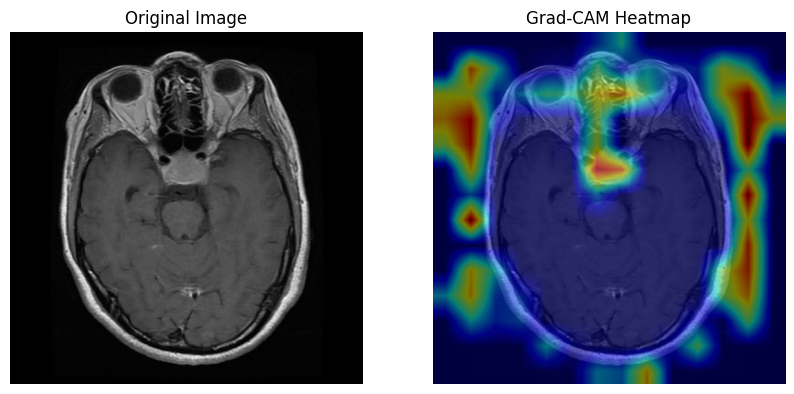

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Get activations and gradients
acts = activations["value"].detach()[0]  # remove batch dimension
grads = gradients["value"].detach()[0]

# Compute weights: global average pooling of gradients
weights = grads.mean(dim=0)  # shape: [hidden_dim]

# Weighted sum of activations
cam = (acts * weights[None, :]).sum(dim=-1)  # shape: [seq_len]

# Remove CLS token (first token) if present
cam = cam[1:]  # shape: [196] for 14x14 patches

# Reshape to spatial dimensions
cam = cam.reshape(14, 14).cpu().numpy()

# Normalize
cam = np.maximum(cam, 0)
cam = cam - cam.min()
cam = cam / cam.max()

# Resize to original image size
cam = cv2.resize(cam, image.size)

# Overlay heatmap on original image
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(image)
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Check that your model folder exists
!ls -l /content/drive/MyDrive/brain_tumor_vit_model_for_heatmap


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
total 335187
-rw------- 1 root root       749 Sep 15 10:45 config.json
-rw------- 1 root root 343230128 Sep 15 10:45 model.safetensors


In [ ]:
!pip install -q transformers safetensors timm


In [ ]:
from transformers import AutoConfig, AutoModelForImageClassification

model_path = "/content/drive/MyDrive/brain_tumor_vit_model_for_heatmap"

# Load config
config = AutoConfig.from_pretrained(model_path)
print("Model config loaded.")
print("Number of labels:", config.num_labels)

# ✅ Load model (no 'from_safetensors' here)
vit_model = AutoModelForImageClassification.from_pretrained(model_path)
vit_model.eval()
print("Model loaded successfully!")


Model config loaded.
Number of labels: 4
Model loaded successfully!


In [ ]:
# Safe label mapping
id2label = {int(k): v for k,v in config.id2label.items()}  # convert keys to int

pred_label = id2label.get(pred_class, f"Label_{pred_class}")
print("Predicted label:", pred_label)


Predicted label: LABEL_3


In [ ]:
!pip install -q torchcam matplotlib nibabel


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 103.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip install -q torchcam matplotlib


In [ ]:
!pip install -q torchcam matplotlib


In [ ]:
import torch
import timm

# Create ViT model with 4 classes (like your trained model)
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=4)

# Load weights
model_path = "/content/drive/MyDrive/brain_tumor_model.pth"
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchcam.methods import SmoothGradCAMpp
from timm import create_model

# Load model
model = create_model('vit_base_patch16_224', pretrained=False, num_classes=4)
model.load_state_dict(torch.load("/content/drive/MyDrive/brain_tumor_model.pth", map_location='cpu'))
model.eval()

# Load image
img_path = "
img = Image.open(img_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
input_tensor = transform(img).unsqueeze(0)

# Use SmoothGradCAM++
cam_extractor = SmoothGradCAMpp(model)

# Forward pass & get prediction
out = model(input_tensor)
pred_class = out.argmax(dim=1).item()

# Extract CAM
activation_map = cam_extractor(pred_class, out)

# Convert CAM to heatmap
heatmap = activation_map[0].detach().numpy()
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# Overlay heatmap on original image
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()


In [ ]:
print(attentions[-1].shape)


torch.Size([1, 197, 768])


In [ ]:
!pip install torchcam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 63.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you h

In [ ]:
heatmap_tensor = heatmap_tensor.mean(axis=-1)



In [ ]:
import torch
heatmap_tensor = torch.tensor(heatmap_tensor)  # convert from NumPy/list to tensor
heatmap_tensor = heatmap_tensor.mean(dim=-1)


In [ ]:
print("heatmap_tensor shape:", heatmap_tensor.shape)


heatmap_tensor shape: torch.Size([])


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [ ]:
img_path = "/content/drive/MyDrive/test_images/sample-img6-pituitary.jpg"  # replace with your file
img = Image.open(img_path).convert("RGB")
img_np = np.array(img)


In [ ]:
# 1️⃣ Make sure input requires grad
input_tensor.requires_grad_(True)

# 2️⃣ Define a hook to capture attention / hidden states
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

# 3️⃣ Register hook on the ViT layer you want (e.g., last encoder block)
model.blocks[-1].register_forward_hook(get_activation('last_block'))

# 4️⃣ Forward pass
outputs = model(input_tensor)  # no torch.no_grad()


In [ ]:
heatmap_tensor = activation['last_block']  # shape: (1, num_patches, hidden_dim)


In [ ]:
print("Original heatmap_tensor shape:", heatmap_tensor.shape)
# Expect something like: torch.Size([1, 196, 768])


Original heatmap_tensor shape: torch.Size([1, 197, 768])


In [ ]:
if len(heatmap_tensor.shape) == 3:  # (batch, num_patches, hidden_dim)
    heatmap_tensor = heatmap_tensor.mean(dim=-1)  # shape: (batch, num_patches)


In [ ]:
if heatmap_tensor.shape[0] == 1:  # batch size = 1
    heatmap_tensor = heatmap_tensor.squeeze(0)  # shape: (num_patches,)


In [ ]:
# Remove CLS token
heatmap_tensor_no_cls = heatmap_tensor[1:]  # shape (196,)

num_patches = heatmap_tensor_no_cls.shape[0]  # 196
size = int(num_patches ** 0.5)  # 14

# Reshape to 2D
heatmap_2d = heatmap_tensor_no_cls.reshape(size, size).detach().numpy()


In [ ]:
heatmap_2d = (heatmap_2d - heatmap_2d.min()) / (heatmap_2d.max() - heatmap_2d.min())


In [ ]:
heatmap_img = Image.fromarray(np.uint8(heatmap_2d * 255)).resize(
    (img_np.shape[1], img_np.shape[0]), resample=Image.BILINEAR
)
heatmap_img = np.array(heatmap_img) / 255  # normalize again


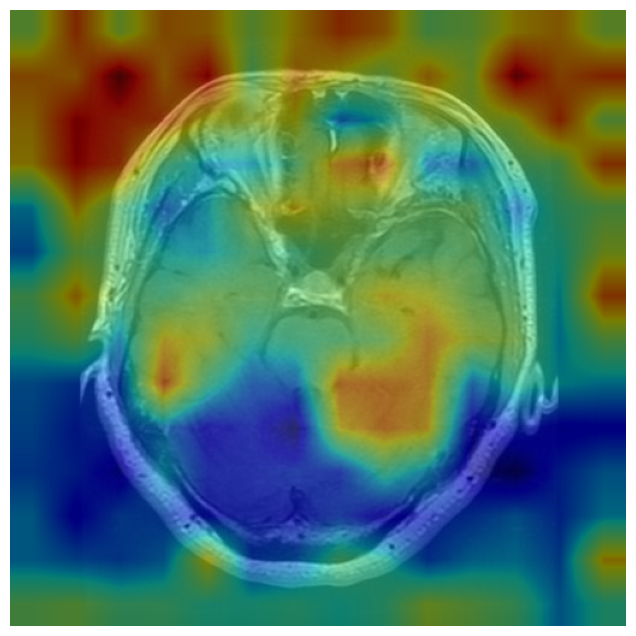

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(img_np)
plt.imshow(heatmap_img, cmap='jet', alpha=0.5)  # alpha controls transparency
plt.axis('off')
plt.show()


In [ ]:
import torch

# Remove the first token if it is CLS
heatmap_tensor = heatmap_tensor[1:]   # removes 1 element, size now 196
num_patches = heatmap_tensor.shape[0]
grid_size = int(num_patches ** 0.5)   # now 14
heatmap_2d = heatmap_tensor.reshape(grid_size, grid_size).detach().cpu().numpy()


In [ ]:
heatmap_2d = (heatmap_2d - heatmap_2d.min()) / (heatmap_2d.max() - heatmap_2d.min() + 1e-8)


In [ ]:
import numpy as np
import cv2

# If img is a PIL Image
img_np = np.array(img)         # shape will be (H, W, C) for RGB

H, W = img_np.shape[:2]        # now it works
heatmap_resized = cv2.resize(heatmap_2d, (W, H))


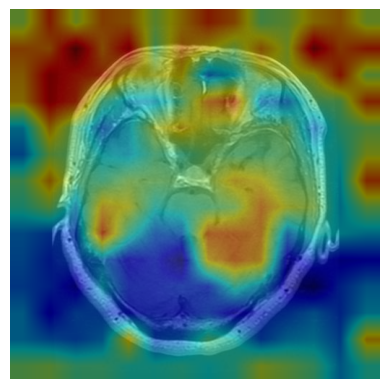

In [ ]:
heatmap_color = cv2.applyColorMap((heatmap_resized*255).astype('uint8'), cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

alpha = 0.5
overlay = cv2.addWeighted(img_np, 1-alpha, heatmap_color, alpha, 0)

import matplotlib.pyplot as plt
plt.imshow(overlay)
plt.axis('off')
plt.show()


In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image


In [ ]:
# If your image is PIL Image
img = Image.open("/content/drive/MyDrive/test_images/sample-img3-glioma.jpg").convert("RGB")  # ensure 3 channels
img_np = np.array(img)   # shape: H x W x 3
H, W = img_np.shape[:2]


In [ ]:
# Assume heatmap_tensor is 1D (num_patches + 1 if CLS included)
if heatmap_tensor.shape[0] > 0 and int((heatmap_tensor.shape[0]-1)**0.5)**2 == heatmap_tensor.shape[0]-1:
    heatmap_tensor = heatmap_tensor[1:]   # remove CLS token if needed

num_patches = heatmap_tensor.shape[0]
grid_size = int(num_patches ** 0.5)
heatmap_2d = heatmap_tensor.reshape(grid_size, grid_size).detach().cpu().numpy()


In [ ]:
heatmap_2d = (heatmap_2d - heatmap_2d.min()) / (heatmap_2d.max() - heatmap_2d.min() + 1e-8)


In [ ]:
heatmap_resized = cv2.resize(heatmap_2d, (W, H))  # width, height order in cv2


In [ ]:
heatmap_color = cv2.applyColorMap((heatmap_resized*255).astype('uint8'), cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)


In [ ]:
alpha = 0.5
overlay = cv2.addWeighted(img_np, 1-alpha, heatmap_color, alpha, 0)


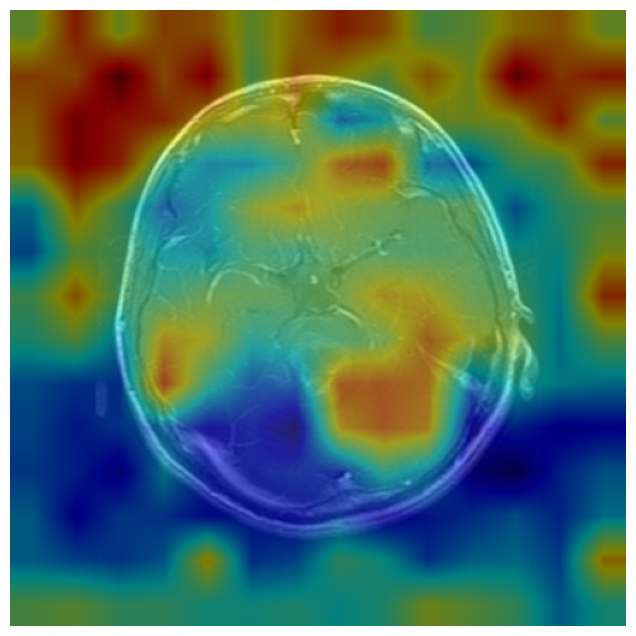

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(overlay)
plt.axis('off')
plt.show()


In [ ]:
threshold = 0.6   # adjust between 0.4–0.8
tumor_mask = (heatmap_resized > threshold).astype('uint8') * 255


In [ ]:
kernel = np.ones((5,5), np.uint8)
tumor_mask = cv2.morphologyEx(tumor_mask, cv2.MORPH_OPEN, kernel)
tumor_mask = cv2.morphologyEx(tumor_mask, cv2.MORPH_CLOSE, kernel)


In [ ]:
# Convert mask to 3-channel
tumor_mask_color = cv2.cvtColor(tumor_mask, cv2.COLOR_GRAY2RGB)

# Highlight tumor in red
highlighted = img_np.copy()
highlighted[tumor_mask > 0] = [255, 0, 0]   # mark tumor pixels red


In [ ]:
# Part 1: compute and save heatmap_resized.npy and img_np.npy
# ---------------------------------------------------------
import torch, math, os
import numpy as np
import cv2
from PIL import Image
from transformers import ViTModel, ViTImageProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---- User inputs ----
image_path = "/content/drive/MyDrive/test_images/sample-img3-glioma.jpg"   # <-- replace with your file path
model_name = "google/vit-base-patch16-224-in21k"
# ----------------------

# load image (PIL -> numpy)
img = Image.open(image_path).convert("RGB")
img_np = np.array(img)   # H x W x 3 (RGB)
H, W = img_np.shape[:2]
print("Loaded image:", image_path, "size:", (H, W))

# load ViT with attentions enabled
print("Loading model (this may download weights if not cached)...")
model = ViTModel.from_pretrained(model_name, output_attentions=True).to(device).eval()
processor = ViTImageProcessor.from_pretrained(model_name)

# prepare inputs
inputs = processor(images=img, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

# forward pass -> attentions
with torch.no_grad():
    outputs = model(**inputs)
    attentions = outputs.attentions
    if attentions is None:
        raise RuntimeError("`attentions` is None. Ensure model loaded with output_attentions=True.")
    # attentions[-1]: (batch, heads, seq_len, seq_len)
    last_attn = attentions[-1]                  # last layer
    attn_mean = last_attn.mean(dim=1)           # average over heads -> (batch, seq_len, seq_len)
    attn_mat = attn_mean[0].cpu()               # (seq_len, seq_len) for batch 0

# get CLS -> patch attention (drop CLS itself)
cls_to_patches = attn_mat[0, 1:]               # shape: num_patches
num_patches = cls_to_patches.shape[0]
grid_size = int(math.sqrt(num_patches))
if grid_size * grid_size != num_patches:
    raise ValueError(f"num_patches={num_patches} is not a perfect square (grid_size^2).")

# reshape into 2D patch grid
heatmap_2d = cls_to_patches.reshape(grid_size, grid_size).numpy()

# normalize to 0..1
heatmap_2d = (heatmap_2d - heatmap_2d.min()) / (heatmap_2d.max() - heatmap_2d.min() + 1e-8)

# resize heatmap to original image size (W,H order for cv2)
heatmap_resized = cv2.resize(heatmap_2d, (W, H), interpolation=cv2.INTER_CUBIC)

# save outputs to disk for step-by-step workflow
np.save("heatmap_resized.npy", heatmap_resized)
np.save("img_np.npy", img_np)
np.save("heatmap_2d.npy", heatmap_2d)

print("Saved: heatmap_resized.npy, img_np.npy, heatmap_2d.npy")
print("You can now run Part 2 (post-processing + display).")


Device: cuda
Loaded image: /content/drive/MyDrive/test_images/sample-img3-glioma.jpg size: (512, 512)
Loading model (this may download weights if not cached)...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Saved: heatmap_resized.npy, img_np.npy, heatmap_2d.npy
You can now run Part 2 (post-processing + display).


Loaded heatmap and image shapes: (512, 512) (512, 512, 3)


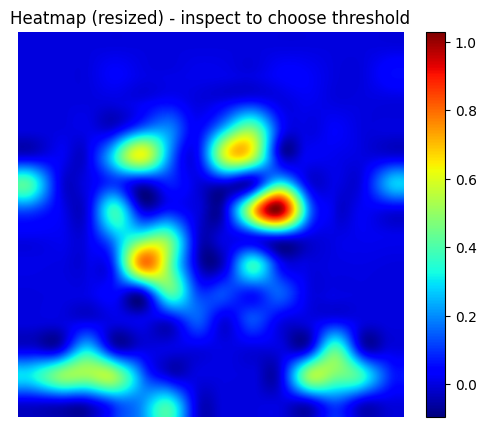

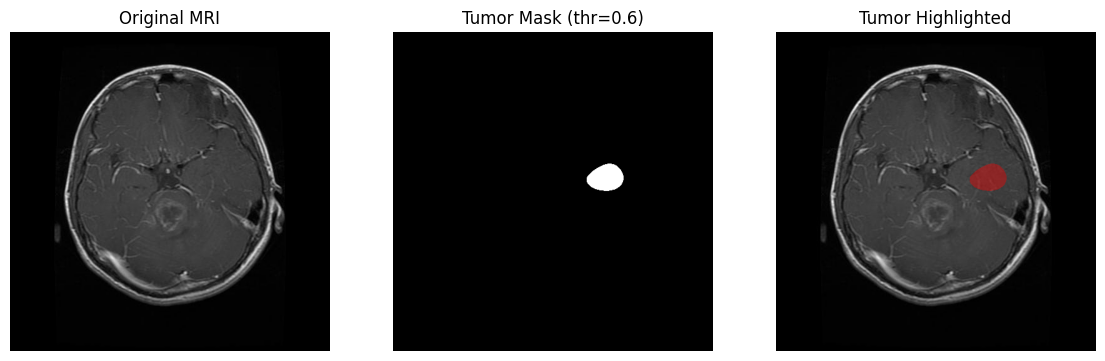

Saved tumor_mask.png and tumor_highlighted.png


In [ ]:
# Part 2: load heatmap + image, threshold, clean, highlight & save outputs
# ------------------------------------------------------------------------
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# ---- Parameters you can tweak ----
threshold = 0.6        # start 0.4..0.8. lower => more area, higher => smaller/high-confidence area
kernel_size = 5        # morphological cleanup kernel
keep_largest_component = True   # if True, only keep the largest connected region (helps remove noise)
# ----------------------------------

# load saved files from Part 1
heatmap_resized = np.load("heatmap_resized.npy")
img_np = np.load("img_np.npy")
H, W = img_np.shape[:2]
print("Loaded heatmap and image shapes:", heatmap_resized.shape, img_np.shape)

# visualize the raw heatmap to pick a good threshold (optional)
plt.figure(figsize=(6,5))
plt.title("Heatmap (resized) - inspect to choose threshold")
plt.imshow(heatmap_resized, cmap="jet")
plt.colorbar(fraction=0.045)
plt.axis("off")
plt.show()

# threshold to create binary mask
mask = (heatmap_resized > threshold).astype("uint8") * 255

# morphological cleaning
kernel = np.ones((kernel_size, kernel_size), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# optionally keep only the largest connected component
if keep_largest_component:
    contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        largest = max(contours, key=cv2.contourArea)
        large_mask = np.zeros_like(mask)
        cv2.drawContours(large_mask, [largest], -1, 255, thickness=cv2.FILLED)
        mask = large_mask
    else:
        print("Warning: no contours found after thresholding. Try lowering the threshold.")

# create a blended red highlight for mask area
highlighted = img_np.copy().astype("uint8")
red = np.array([255, 0, 0], dtype=np.uint8)

# blend red color on mask pixels to preserve some original structure
alpha = 0.4  # blending factor for red
mask_bool = mask > 0
highlighted[mask_bool] = (alpha * red + (1 - alpha) * highlighted[mask_bool]).astype(np.uint8)

# show results
plt.figure(figsize=(14,6))
plt.subplot(1,3,1); plt.title("Original MRI"); plt.imshow(img_np); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"Tumor Mask (thr={threshold})"); plt.imshow(mask, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title("Tumor Highlighted"); plt.imshow(highlighted); plt.axis("off")
plt.show()

# save outputs
cv2.imwrite("tumor_mask.png", mask)   # grayscale
# convert RGB->BGR for OpenCV saving
cv2.imwrite("tumor_highlighted.png", cv2.cvtColor(highlighted, cv2.COLOR_RGB2BGR))
print("Saved tumor_mask.png and tumor_highlighted.png")


In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor

model_path = "/content/drive/MyDrive/brain_tumor_vit_model"

# Load your fine-tuned model
model = ViTForImageClassification.from_pretrained(model_path)

# Load processor from base pretrained ViT
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
processor.save_pretrained(model_path)


['/content/drive/MyDrive/brain_tumor_vit_model/preprocessor_config.json']

In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor

model_path = "/content/drive/MyDrive/brain_tumor_vit_model"

# Load your fine-tuned model
model = ViTForImageClassification.from_pretrained(model_path, output_attentions=True)

# Load the matching processor
processor = ViTImageProcessor.from_pretrained(model_path)

print("Model and processor loaded successfully ✅")


Model and processor loaded successfully ✅


Using device: cuda
Predicted Class: no_tumor


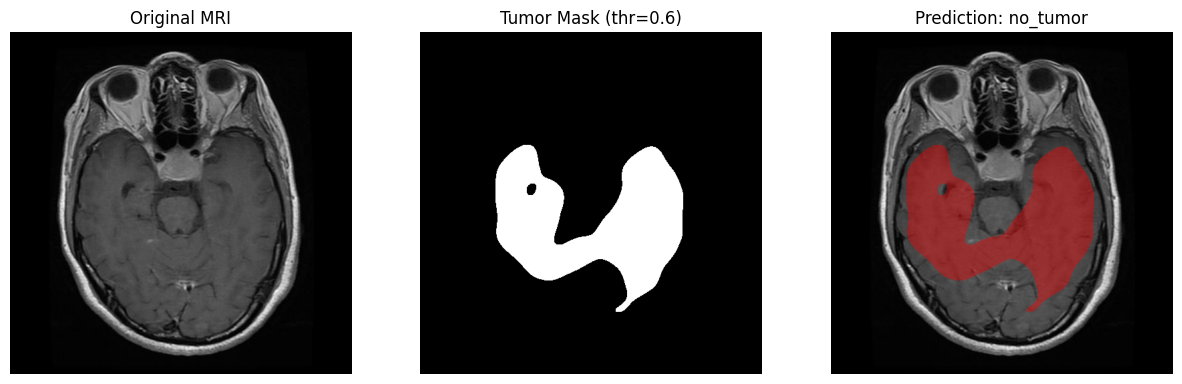

In [ ]:
import torch, math
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTImageProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------------
# STEP 1: Load Model + Labels
# --------------------------
# Replace with your fine-tuned ViT model
model_name = "/content/drive/MyDrive/brain_tumor_vit_model"   # e.g., "kamalikaa/brain-tumor-vit"
model = ViTForImageClassification.from_pretrained(model_name, output_attentions=True).to(device).eval()
processor = ViTImageProcessor.from_pretrained(model_name)

# Define your class names (update to match your dataset)
class_names = ["glioma", "meningioma", "pituitary", "no_tumor"]

# --------------------------
# STEP 2: Load MRI Image
# --------------------------
image_path = ""   # 🔹 Replace with the path
img = Image.open(image_path).convert("RGB")
img_np = np.array(img)
H, W = img_np.shape[:2]

# --------------------------
# STEP 3: Prediction
# --------------------------
inputs = processor(images=img, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    pred_class = torch.argmax(logits, dim=-1).item()
    pred_label = class_names[pred_class]
    print("Predicted Class:", pred_label)

# --------------------------
# STEP 4: Attention → Heatmap
# --------------------------
attentions = outputs.attentions
if attentions is None:
    raise RuntimeError("Attention maps are None. Ensure output_attentions=True in model.")

last_attn = attentions[-1]              # last layer
attn_mean = last_attn.mean(dim=1)[0]    # avg over heads → (tokens, tokens)
cls_to_patches = attn_mean[0, 1:]       # CLS → patch attention
num_patches = cls_to_patches.shape[0]
grid_size = int(math.sqrt(num_patches))
heatmap_2d = cls_to_patches.reshape(grid_size, grid_size).cpu().numpy()

# Normalize + Resize
heatmap_2d = (heatmap_2d - heatmap_2d.min()) / (heatmap_2d.max() - heatmap_2d.min() + 1e-8)
heatmap_resized = cv2.resize(heatmap_2d, (W, H), interpolation=cv2.INTER_CUBIC)

# --------------------------
# STEP 5: Tumor Mask
# --------------------------
threshold = 0.6
tumor_mask = (heatmap_resized > threshold).astype("uint8") * 255

# Morphological cleanup
kernel = np.ones((5,5), np.uint8)
tumor_mask = cv2.morphologyEx(tumor_mask, cv2.MORPH_OPEN, kernel)
tumor_mask = cv2.morphologyEx(tumor_mask, cv2.MORPH_CLOSE, kernel)

# --------------------------
# STEP 6: Highlight Tumor
# --------------------------
highlighted = img_np.copy().astype("uint8")
red = np.array([255, 0, 0], dtype=np.uint8)
alpha = 0.4
highlighted[tumor_mask > 0] = (alpha * red + (1 - alpha) * highlighted[tumor_mask > 0]).astype(np.uint8)

# --------------------------
# STEP 7: Display Results
# --------------------------
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.title("Original MRI")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,3,2)
plt.title(f"Tumor Mask (thr={threshold})")
plt.imshow(tumor_mask, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title(f"Prediction: {pred_label}")
plt.imshow(highlighted)
plt.axis("off")

plt.show()


Using device: cuda
Predicted Class: notumor


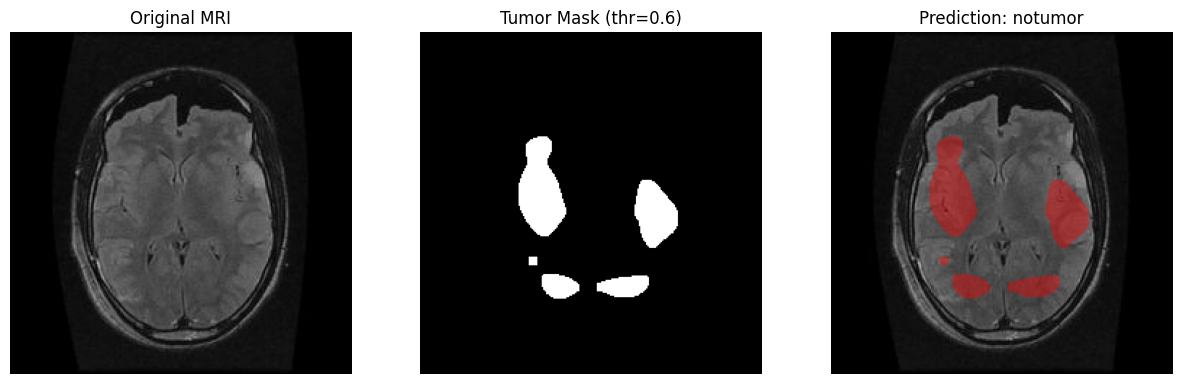

Saved tumor_mask.png and tumor_highlighted.png


In [ ]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTImageProcessor
import math

# -----------------------------
# 1. Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Path to your fine-tuned ViT model folder
model_path = "/content/drive/MyDrive/brain_tumor_vit_model"

# Load model and processor
model = ViTForImageClassification.from_pretrained(model_path, output_attentions=True).to(device).eval()
processor = ViTImageProcessor.from_pretrained(model_path)

# Correct label mapping
model.config.id2label = {
    0: "glioma",
    1: "meningioma",
    2: "notumor",
    3: "pituitary"
}
model.config.label2id = {v: k for k, v in model.config.id2label.items()}
class_names = list(model.config.id2label.values())

# -----------------------------
# 2. Load MRI Image
# -----------------------------
image_path = "/content/drive/MyDrive/test_images/sample-img7-notumor.jpg"   # <-- replace with your image path
img = Image.open(image_path).convert("RGB")
img_np = np.array(img)
H, W = img_np.shape[:2]

# -----------------------------
# 3. Preprocess and Predict
# -----------------------------
inputs = processor(images=img, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    pred_class = torch.argmax(logits, dim=-1).item()
    pred_label = class_names[pred_class]
    print("Predicted Class:", pred_label)

# -----------------------------
# 4. Attention → Heatmap
# -----------------------------
attentions = outputs.attentions
if attentions is None:
    raise RuntimeError("Attentions are None. Ensure output_attentions=True")

last_attn = attentions[-1]                 # last layer
attn_mean = last_attn.mean(dim=1)[0]       # average over heads → (tokens, tokens)
cls_to_patches = attn_mean[0, 1:]          # CLS → patch attention
num_patches = cls_to_patches.shape[0]
grid_size = int(math.sqrt(num_patches))
heatmap_2d = cls_to_patches.reshape(grid_size, grid_size).cpu().numpy()

# Normalize + Resize
heatmap_2d = (heatmap_2d - heatmap_2d.min()) / (heatmap_2d.max() - heatmap_2d.min() + 1e-8)
heatmap_resized = cv2.resize(heatmap_2d, (W, H), interpolation=cv2.INTER_CUBIC)

# -----------------------------
# 5. Create Tumor Mask
# -----------------------------
threshold = 0.6
tumor_mask = (heatmap_resized > threshold).astype("uint8") * 255

# Morphological cleanup
kernel = np.ones((5,5), np.uint8)
tumor_mask = cv2.morphologyEx(tumor_mask, cv2.MORPH_OPEN, kernel)
tumor_mask = cv2.morphologyEx(tumor_mask, cv2.MORPH_CLOSE, kernel)

# -----------------------------
# 6. Highlight Tumor on MRI
# -----------------------------
highlighted = img_np.copy().astype("uint8")
red = np.array([255, 0, 0], dtype=np.uint8)
alpha = 0.4
highlighted[tumor_mask > 0] = (alpha * red + (1 - alpha) * highlighted[tumor_mask > 0]).astype(np.uint8)

# -----------------------------
# 7. Display Results
# -----------------------------
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.title("Original MRI")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,3,2)
plt.title(f"Tumor Mask (thr={threshold})")
plt.imshow(tumor_mask, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title(f"Prediction: {pred_label}")
plt.imshow(highlighted)
plt.axis("off")

plt.show()

# -----------------------------
# 8. Save outputs (optional)
# -----------------------------
cv2.imwrite("tumor_mask.png", tumor_mask)
cv2.imwrite("tumor_highlighted.png", cv2.cvtColor(highlighted, cv2.COLOR_RGB2BGR))
print("Saved tumor_mask.png and tumor_highlighted.png")


Using device: cuda
Predicted Class: pituitary


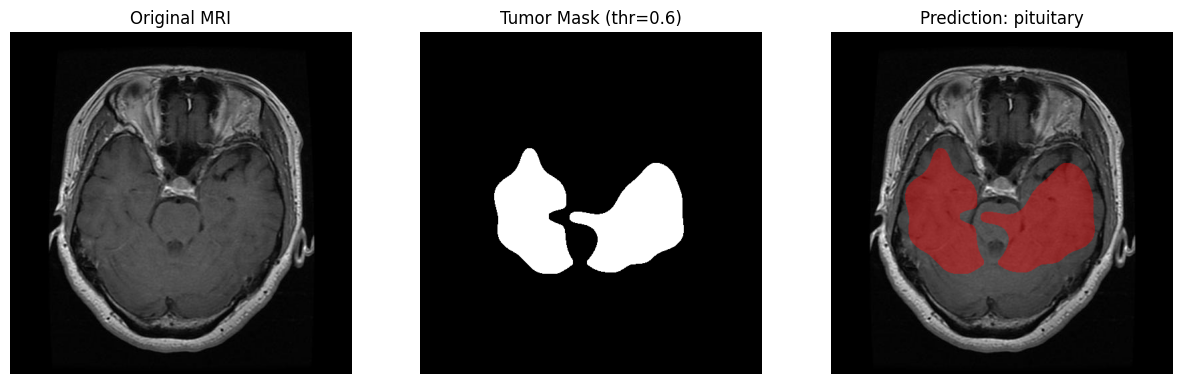

Saved tumor_mask.png and tumor_highlighted.png


In [ ]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTImageProcessor
import math

# -----------------------------
# 1. Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Path to your fine-tuned ViT model folder
model_path = "/content/drive/MyDrive/brain_tumor_vit_model"

# Load model and processor
model = ViTForImageClassification.from_pretrained(model_path, output_attentions=True).to(device).eval()
processor = ViTImageProcessor.from_pretrained(model_path)

# Correct label mapping
model.config.id2label = {
    0: "glioma",
    1: "meningioma",
    2: "notumor",
    3: "pituitary"
}
model.config.label2id = {v: k for k, v in model.config.id2label.items()}
class_names = list(model.config.id2label.values())

# -----------------------------
# 2. Load MRI Image
# -----------------------------
image_path = "/content/drive/MyDrive/test_images/sample-img6-pituitary.jpg"   # <-- replace with your image path
img = Image.open(image_path).convert("RGB")
img_np = np.array(img)
H, W = img_np.shape[:2]

# -----------------------------
# 3. Preprocess and Predict
# -----------------------------
inputs = processor(images=img, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    pred_class = torch.argmax(logits, dim=-1).item()
    pred_label = class_names[pred_class]
    print("Predicted Class:", pred_label)

# -----------------------------
# 4. Generate Tumor Heatmap only if tumor exists
# -----------------------------
if pred_label == "notumor":
    print("No tumor detected. Skipping heatmap generation.")
    tumor_mask = np.zeros((H,W), dtype=np.uint8)
    highlighted = img_np.copy()
else:
    # Attention → Heatmap
    attentions = outputs.attentions
    if attentions is None:
        raise RuntimeError("Attentions are None. Ensure output_attentions=True")

    last_attn = attentions[-1]                 # last layer
    attn_mean = last_attn.mean(dim=1)[0]       # average over heads → (tokens, tokens)
    cls_to_patches = attn_mean[0, 1:]          # CLS → patch attention
    num_patches = cls_to_patches.shape[0]
    grid_size = int(math.sqrt(num_patches))
    heatmap_2d = cls_to_patches.reshape(grid_size, grid_size).cpu().numpy()

    # Normalize + Resize
    heatmap_2d = (heatmap_2d - heatmap_2d.min()) / (heatmap_2d.max() - heatmap_2d.min() + 1e-8)
    heatmap_resized = cv2.resize(heatmap_2d, (W, H), interpolation=cv2.INTER_CUBIC)

    # Threshold → Tumor Mask
    threshold = 0.6
    tumor_mask = (heatmap_resized > threshold).astype("uint8") * 255

    # Morphological cleanup
    kernel = np.ones((5,5), np.uint8)
    tumor_mask = cv2.morphologyEx(tumor_mask, cv2.MORPH_OPEN, kernel)
    tumor_mask = cv2.morphologyEx(tumor_mask, cv2.MORPH_CLOSE, kernel)

    # Highlight Tumor on MRI
    highlighted = img_np.copy().astype("uint8")
    red = np.array([255, 0, 0], dtype=np.uint8)
    alpha = 0.4
    highlighted[tumor_mask > 0] = (alpha * red + (1 - alpha) * highlighted[tumor_mask > 0]).astype(np.uint8)

# -----------------------------
# 5. Display Results
# -----------------------------
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.title("Original MRI")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,3,2)
plt.title(f"Tumor Mask (thr={threshold if pred_label!='notumor' else 'N/A'})")
plt.imshow(tumor_mask, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title(f"Prediction: {pred_label}")
plt.imshow(highlighted)
plt.axis("off")

plt.show()

# -----------------------------
# 6. Save outputs (optional)
# -----------------------------
cv2.imwrite("tumor_mask.png", tumor_mask)
cv2.imwrite("tumor_highlighted.png", cv2.cvtColor(highlighted, cv2.COLOR_RGB2BGR))
print("Saved tumor_mask.png and tumor_highlighted.png")


Using device: cuda


Saving sample-img4-pituitary.jpg to sample-img4-pituitary.jpg
Uploaded file: sample-img4-pituitary.jpg
Predicted Class: pituitary


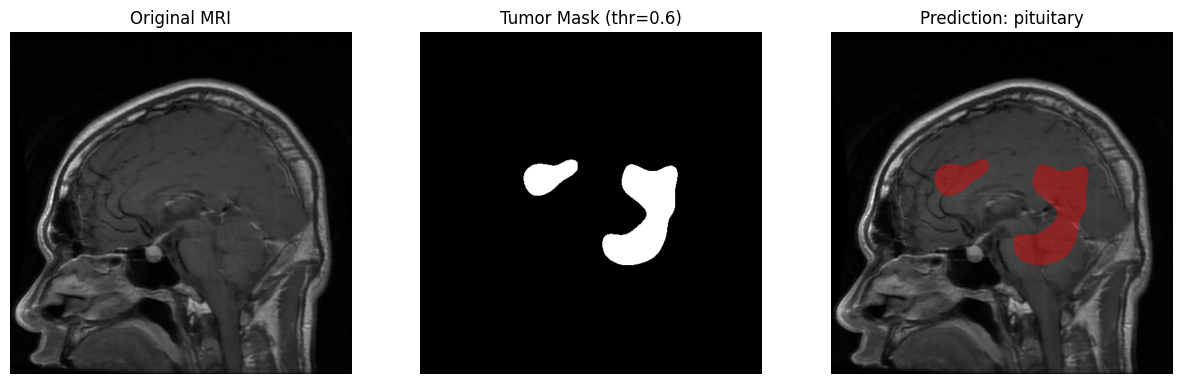

Saved tumor_mask.png and tumor_highlighted.png


In [ ]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTImageProcessor
import math
from google.colab import files

# -----------------------------
# 1. Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Path to your fine-tuned ViT model folder
model_path = "/content/drive/MyDrive/brain_tumor_vit_model"

# Load model and processor
model = ViTForImageClassification.from_pretrained(model_path, output_attentions=True).to(device).eval()
processor = ViTImageProcessor.from_pretrained(model_path)

# Correct label mapping
model.config.id2label = {
    0: "glioma",
    1: "meningioma",
    2: "notumor",
    3: "pituitary"
}
model.config.label2id = {v: k for k, v in model.config.id2label.items()}
class_names = list(model.config.id2label.values())

# -----------------------------
# 2. Upload MRI Image
# -----------------------------
uploaded = files.upload()  # Opens file picker in Colab
image_path = list(uploaded.keys())[0]
print("Uploaded file:", image_path)

img = Image.open(image_path).convert("RGB")
img_np = np.array(img)
H, W = img_np.shape[:2]

# -----------------------------
# 3. Preprocess and Predict
# -----------------------------
inputs = processor(images=img, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    pred_class = torch.argmax(logits, dim=-1).item()
    pred_label = class_names[pred_class]
    print("Predicted Class:", pred_label)

# -----------------------------
# 4. Generate Tumor Heatmap only if tumor exists
# -----------------------------
if pred_label == "notumor":
    print("No tumor detected. Skipping heatmap generation.")
    tumor_mask = np.zeros((H,W), dtype=np.uint8)
    highlighted = img_np.copy()
else:
    # Attention → Heatmap
    attentions = outputs.attentions
    if attentions is None:
        raise RuntimeError("Attentions are None. Ensure output_attentions=True")

    last_attn = attentions[-1]                 # last layer
    attn_mean = last_attn.mean(dim=1)[0]       # average over heads → (tokens, tokens)
    cls_to_patches = attn_mean[0, 1:]          # CLS → patch attention
    num_patches = cls_to_patches.shape[0]
    grid_size = int(math.sqrt(num_patches))
    heatmap_2d = cls_to_patches.reshape(grid_size, grid_size).cpu().numpy()

    # Normalize + Resize
    heatmap_2d = (heatmap_2d - heatmap_2d.min()) / (heatmap_2d.max() - heatmap_2d.min() + 1e-8)
    heatmap_resized = cv2.resize(heatmap_2d, (W, H), interpolation=cv2.INTER_CUBIC)

    # Threshold → Tumor Mask
    threshold = 0.6
    tumor_mask = (heatmap_resized > threshold).astype("uint8") * 255

    # Morphological cleanup
    kernel = np.ones((5,5), np.uint8)
    tumor_mask = cv2.morphologyEx(tumor_mask, cv2.MORPH_OPEN, kernel)
    tumor_mask = cv2.morphologyEx(tumor_mask, cv2.MORPH_CLOSE, kernel)

    # Highlight Tumor on MRI
    highlighted = img_np.copy().astype("uint8")
    red = np.array([255, 0, 0], dtype=np.uint8)
    alpha = 0.4
    highlighted[tumor_mask > 0] = (alpha * red + (1 - alpha) * highlighted[tumor_mask > 0]).astype(np.uint8)

# -----------------------------
# 5. Display Results
# -----------------------------
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.title("Original MRI")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,3,2)
plt.title(f"Tumor Mask (thr={threshold if pred_label!='notumor' else 'N/A'})")
plt.imshow(tumor_mask, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title(f"Prediction: {pred_label}")
plt.imshow(highlighted)
plt.axis("off")

plt.show()

# -----------------------------
# 6. Save outputs
# -----------------------------
cv2.imwrite("tumor_mask.png", tumor_mask)
cv2.imwrite("tumor_highlighted.png", cv2.cvtColor(highlighted, cv2.COLOR_RGB2BGR))
print("Saved tumor_mask.png and tumor_highlighted.png")


In [ ]:
import torch
import numpy as np
import cv2
from PIL import Image
from transformers import ViTForImageClassification, ViTImageProcessor
import math
import gradio as gr

# -----------------------------
# 1. Setup model
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_path = "/content/drive/MyDrive/brain_tumor_vit_model"
model = ViTForImageClassification.from_pretrained(model_path, output_attentions=True).to(device).eval()
processor = ViTImageProcessor.from_pretrained(model_path)

model.config.id2label = {0: "glioma", 1: "meningioma", 2: "notumor", 3: "pituitary"}
model.config.label2id = {v: k for k, v in model.config.id2label.items()}
class_names = list(model.config.id2label.values())

# -----------------------------
# 2. Prediction + Highlighting function
# -----------------------------
def predict_and_highlight(image: Image.Image, threshold: float = 0.6):
    img_np = np.array(image)
    H, W = img_np.shape[:2]

    # Preprocess
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_class = torch.argmax(logits, dim=-1).item()
        pred_label = class_names[pred_class]

    # Generate tumor mask
    if pred_label == "notumor":
        tumor_mask = np.zeros((H, W), dtype=np.uint8)
        highlighted = img_np.copy()
    else:
        attentions = outputs.attentions
        last_attn = attentions[-1]
        attn_mean = last_attn.mean(dim=1)[0]
        cls_to_patches = attn_mean[0, 1:]
        num_patches = cls_to_patches.shape[0]
        grid_size = int(math.sqrt(num_patches))
        heatmap_2d = cls_to_patches.reshape(grid_size, grid_size).cpu().numpy()

        # Normalize + Resize
        heatmap_2d = (heatmap_2d - heatmap_2d.min()) / (heatmap_2d.max() - heatmap_2d.min() + 1e-8)
        heatmap_resized = cv2.resize(heatmap_2d, (W, H), interpolation=cv2.INTER_CUBIC)

        # Threshold → Tumor Mask
        tumor_mask = (heatmap_resized > threshold).astype("uint8") * 255

        # Morphological cleanup
        kernel = np.ones((5,5), np.uint8)
        tumor_mask = cv2.morphologyEx(tumor_mask, cv2.MORPH_OPEN, kernel)
        tumor_mask = cv2.morphologyEx(tumor_mask, cv2.MORPH_CLOSE, kernel)

        # Highlight tumor
        highlighted = img_np.copy().astype("uint8")
        red = np.array([255, 0, 0], dtype=np.uint8)
        alpha = 0.4
        highlighted[tumor_mask > 0] = (alpha * red + (1 - alpha) * highlighted[tumor_mask > 0]).astype(np.uint8)

    return pred_label, img_np, tumor_mask, highlighted

# -----------------------------
# 3. Polished Gradio UI
# -----------------------------
with gr.Blocks() as demo:
    gr.Markdown("## 🧠 Brain Tumor Classification & Highlighting")
    with gr.Row():
        with gr.Column(scale=1):
            image_input = gr.Image(type="pil", label="Upload MRI Image")
            threshold_slider = gr.Slider(0.1, 1.0, value=0.6, step=0.05, label="Attention Threshold")
        with gr.Column(scale=2):
            prediction_output = gr.Textbox(label="Prediction", interactive=False)
            with gr.Row():
                img1 = gr.Image(type="numpy", label="Original MRI")
                img2 = gr.Image(type="numpy", label="Tumor Mask")
                img3 = gr.Image(type="numpy", label="Highlighted Tumor")

    def run(image, threshold):
        pred, orig, mask, highlighted = predict_and_highlight(image, threshold)
        return pred, orig, mask, highlighted

    image_input.change(run, inputs=[image_input, threshold_slider], outputs=[prediction_output, img1, img2, img3])
    threshold_slider.change(run, inputs=[image_input, threshold_slider], outputs=[prediction_output, img1, img2, img3])

demo.launch(debug=True)


Using device: cuda
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://84279b4e4706b8cdf0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!python -V
!python -m pip --version


Python 3.12.11
pip 24.1.2 from /usr/local/lib/python3.12/dist-packages/pip (python 3.12)


In [ ]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-mbwbd17e
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-mbwbd17e
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=43670 sha256=04159445adfdabec1aba855c46d6a8973255b343daab24c76a7dcb5e8454aeb4
  Stored in directory: /tmp/pip-ephem-wheel-cache-stv3r_dk/wheels/69/29/f7/3abdb24031a22af044df15784c8a00f56b6e24f5924e33d0e8
Successfully built grad-cam


In [ ]:
import torch
import torchvision
import pytorch_grad_cam

print("✅ PyTorch version:", torch.__version__)
print("✅ Torchvision version:", torchvision.__version__)
print("✅ pytorch-grad-cam imported successfully!")


✅ PyTorch version: 2.8.0+cu126
✅ Torchvision version: 0.23.0+cu126
✅ pytorch-grad-cam imported successfully!


In [ ]:
!pip install transformers accelerate safetensors


In [ ]:
from transformers import ViTForImageClassification

# ✅ Path to your fine-tuned ViT model folder
model_path = "/content/drive/MyDrive/brain_tumor_vit_model_for_heatmap"

# Load the model
model = ViTForImageClassification.from_pretrained(model_path)
model.eval()

# Update class labels
model.config.id2label = {
    0: "glioma",
    1: "meningioma",
    3: "pituitary",
    2: "no_tumor"
}
model.config.label2id = {v: k for k, v in model.config.id2label.items()}

print("✅ Hugging Face ViT model loaded successfully!")
print("Classes:", model.config.id2label)


✅ Hugging Face ViT model loaded successfully!
Classes: {0: 'glioma', 1: 'meningioma', 3: 'pituitary', 2: 'no_tumor'}


In [ ]:
# ✅ Set your image path directly
img_path = "/content/drive/MyDrive/test_images/sample-img3-glioma.jpg"
print("✅ Using image:", img_path)


✅ Using image: /content/drive/MyDrive/test_images/sample-img3-glioma.jpg


In [ ]:
from PIL import Image
import numpy as np
from torchvision import transforms

# Load and resize image
orig_image = Image.open(img_path).convert("RGB")
image = orig_image.resize((224, 224))

# Preprocess: convert to tensor and normalize (ImageNet stats)
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

# Convert original image to numpy array for overlay
rgb_image = np.array(image) / 255.0

print("✅ Image preprocessed for Grad-CAM")


✅ Image preprocessed for Grad-CAM


In [ ]:
import torch
import torch.nn as nn

class HuggingFaceViTWrapper(nn.Module):
    def __init__(self, hf_model):
        super().__init__()
        self.model = hf_model

    def forward(self, x):
        # Return only logits tensor
        return self.model(x).logits

# Wrap the model
wrapped_model = HuggingFaceViTWrapper(model)
wrapped_model.to(device)
wrapped_model.eval()

# Confirm wrapper
print("✅ Model wrapped for Grad-CAM")


✅ Model wrapped for Grad-CAM


In [ ]:
# --- Ensure device matches ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wrapped_model.to(device)
wrapped_model.eval()

input_tensor = input_tensor.to(device)  # move input to same device


In [ ]:
with torch.no_grad():
    outputs = wrapped_model(input_tensor)
pred_class = outputs.argmax(dim=1).item()
print("Predicted class:", model.config.id2label[pred_class])


Predicted class: glioma


Predicted class: glioma


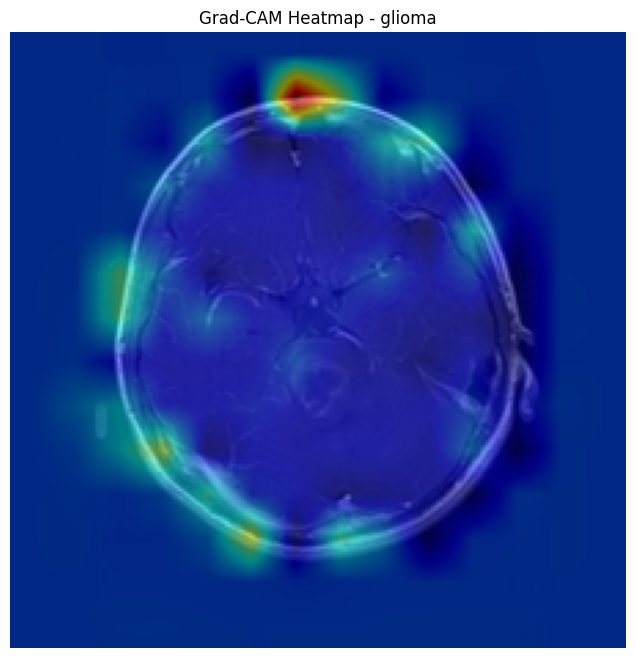

In [ ]:
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

# --- 1️⃣ Device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wrapped_model.to(device)
wrapped_model.eval()
input_tensor = input_tensor.to(device)

# --- 2️⃣ Select target layer (last patch embedding conv layer) ---
target_layers = [wrapped_model.model.vit.embeddings.patch_embeddings.projection]

# --- 3️⃣ Create GradCAM object ---
cam = GradCAM(model=wrapped_model, target_layers=target_layers)

# --- 4️⃣ Predict class ---
with torch.no_grad():
    outputs = wrapped_model(input_tensor)
pred_class = outputs.argmax(dim=1).item()
print("Predicted class:", model.config.id2label[pred_class])

# --- 5️⃣ Prepare target for Grad-CAM ---
targets = [ClassifierOutputTarget(pred_class)]

# --- 6️⃣ Generate heatmap ---
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
cam_image = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

# --- 7️⃣ Display heatmap ---
plt.figure(figsize=(8,8))
plt.imshow(cam_image)
plt.axis('off')
plt.title(f"Grad-CAM Heatmap - {model.config.id2label[pred_class]}")
plt.show()


Predicted class: glioma


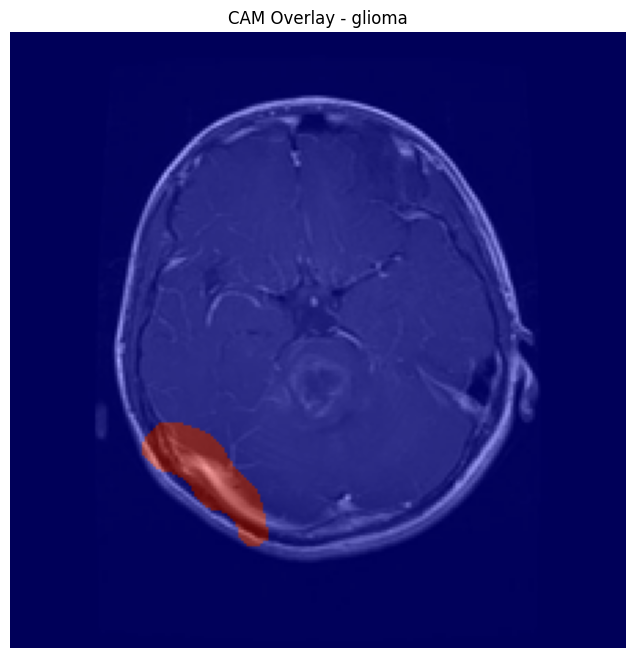

Bounding Box: x=48, y=142, w=46, h=45


In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# --- 1️⃣ Device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wrapped_model.to(device)
wrapped_model.eval()
input_tensor = input_tensor.to(device)

# --- 2️⃣ Select target layer (last patch embedding conv layer) ---
target_layer = wrapped_model.model.vit.embeddings.patch_embeddings.projection

# --- 3️⃣ Predict class ---
with torch.no_grad():
    outputs = wrapped_model(input_tensor)
pred_class = outputs.argmax(dim=1).item()
print("Predicted class:", model.config.id2label[pred_class])

# --- 4️⃣ Prepare target ---
targets = [ClassifierOutputTarget(pred_class)]

# --- 5️⃣ GradCAM & EigenCAM ---
gradcam = GradCAM(model=wrapped_model, target_layers=[target_layer])
eigencam = EigenCAM(model=wrapped_model, target_layers=[target_layer])

grayscale_grad = gradcam(input_tensor=input_tensor, targets=targets)[0]
grayscale_eigen = eigencam(input_tensor=input_tensor, targets=targets)[0]

# --- 6️⃣ Average and normalize ---
grayscale_cam = (grayscale_grad + grayscale_eigen) / 2
grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min())

# --- 7️⃣ Threshold + Morphological cleaning ---
mask = (grayscale_cam >= 0.45).astype('uint8') * 255
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5),np.uint8))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((7,7),np.uint8))

# --- 8️⃣ Keep largest contour ---
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_clean = np.zeros_like(mask)
if contours:
    largest = max(contours, key=cv2.contourArea)
    cv2.drawContours(mask_clean, [largest], -1, 255, -1)

# --- 9️⃣ Overlay heatmap on original image ---
cam_image = show_cam_on_image(rgb_image, mask_clean/255.0, use_rgb=True)

# --- 🔟 Display results ---
plt.figure(figsize=(8,8))
plt.imshow(cam_image)
plt.axis('off')
plt.title(f"CAM Overlay - {model.config.id2label[pred_class]}")
plt.show()

# --- 1️⃣1️⃣ Optional: save overlay, mask, and bounding box ---
cv2.imwrite("cam_overlay.png", cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR))
cv2.imwrite("tumor_mask.png", mask_clean)
if contours:
    x,y,w,h = cv2.boundingRect(largest)
    print(f"Bounding Box: x={x}, y={y}, w={w}, h={h}")


In [ ]:
import torch
import cv2
import numpy as np
import gradio as gr
from PIL import Image
from pytorch_grad_cam import GradCAM, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Make sure your model is loaded and wrapped_model is ready
# wrapped_model = ... (your ViT model)
# model.config.id2label = {0: "Glioma", 1: "Meningioma", 2: "Pituitary"}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wrapped_model.to(device)
wrapped_model.eval()

target_layer = wrapped_model.model.vit.embeddings.patch_embeddings.projection

def preprocess_image(img):
    """Convert PIL image to model tensor"""
    img = img.resize((224,224))  # change if model uses other resolution
    rgb_image = np.array(img)/255.0
    input_tensor = torch.tensor(rgb_image).permute(2,0,1).unsqueeze(0).float()
    return input_tensor.to(device), rgb_image

def generate_heatmap(img):
    input_tensor, rgb_image = preprocess_image(img)

    # --- Predict ---
    with torch.no_grad():
        outputs = wrapped_model(input_tensor)
    pred_class = outputs.argmax(dim=1).item()
    label = model.config.id2label[pred_class]

    # --- CAMs ---
    targets = [ClassifierOutputTarget(pred_class)]
    gradcam = GradCAM(model=wrapped_model, target_layers=[target_layer])
    eigencam = EigenCAM(model=wrapped_model, target_layers=[target_layer])

    grayscale_grad = gradcam(input_tensor=input_tensor, targets=targets)[0]
    grayscale_eigen = eigencam(input_tensor=input_tensor, targets=targets)[0]

    # --- Average & normalize ---
    grayscale_cam = (grayscale_grad + grayscale_eigen)/2
    grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min())

    # --- Threshold + morphology ---
    mask = (grayscale_cam >= 0.45).astype('uint8')*255
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5),np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((7,7),np.uint8))

    # --- Keep largest contour ---
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask_clean = np.zeros_like(mask)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask_clean, [largest], -1, 255, -1)

    # --- Overlay ---
    cam_image = show_cam_on_image(rgb_image, mask_clean/255.0, use_rgb=True)

    return label, cam_image

# --- Gradio Interface ---
interface = gr.Interface(
    fn=generate_heatmap,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Text(label="Predicted Class"), gr.Image(label="Tumor Heatmap")],
    title="Brain Tumor Prediction & Heatmap",
    description="Upload an MRI image. The model predicts the tumor type and shows a cleaned GradCAM+EigenCAM heatmap."
)

interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fc4d8c47b1589a0498.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import torch
import cv2
import numpy as np
import gradio as gr
from PIL import Image
from pytorch_grad_cam import GradCAM, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wrapped_model.to(device)
wrapped_model.eval()
target_layer = wrapped_model.model.vit.embeddings.patch_embeddings.projection

def preprocess_image(img):
    img = img.resize((224,224))  # adjust for your model
    rgb_image = np.array(img)/255.0
    input_tensor = torch.tensor(rgb_image).permute(2,0,1).unsqueeze(0).float()
    return input_tensor.to(device), rgb_image

def generate_heatmap(img):
    input_tensor, rgb_image = preprocess_image(img)

    # --- Predict ---
    with torch.no_grad():
        outputs = wrapped_model(input_tensor)
    pred_class = outputs.argmax(dim=1).item()
    label = model.config.id2label[pred_class]

    # --- CAMs ---
    targets = [ClassifierOutputTarget(pred_class)]
    gradcam = GradCAM(model=wrapped_model, target_layers=[target_layer])
    eigencam = EigenCAM(model=wrapped_model, target_layers=[target_layer])

    grayscale_grad = gradcam(input_tensor=input_tensor, targets=targets)[0]
    grayscale_eigen = eigencam(input_tensor=input_tensor, targets=targets)[0]

    # --- Average & normalize for heatmap ---
    grayscale_cam = (grayscale_grad + grayscale_eigen)/2
    grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min())

    # --- Overlay heatmap on image ---
    cam_image = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

    return label, cam_image

interface = gr.Interface(
    fn=generate_heatmap,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Text(label="Predicted Class"), gr.Image(label="Tumor Heatmap")],
    title="Brain Tumor Prediction & Heatmap",
    description="Upload an MRI image. Shows predicted tumor class and true GradCAM+EigenCAM heatmap overlay."
)

interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5688f09f37d2504ba1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
print("Original input tensor shape:", input_tensor.shape)
print("Input tensor ndim:", input_tensor.ndim)


Original input tensor shape: torch.Size([1, 3, 224, 224])
Input tensor ndim: 4


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.float().to(device)
print("Tensor device:", input_tensor.device)
print("Tensor dtype:", input_tensor.dtype)


Tensor device: cuda:0
Tensor dtype: torch.float32


In [ ]:
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    target_class = output.argmax(dim=1).item()

print("Predicted class index:", target_class)


Predicted class index: 2


In [ ]:
print(model)  # full model structure
print(type(model))  # class of the model


HuggingFaceViTWrapper(
  (model): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (intermediate): ViTIntermediate(
              (den

In [ ]:
import torch
import numpy as np
from pytorch_grad_cam import LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Ensure input tensor is float and on device
input_tensor = input_tensor.float().to(device)

# Forward pass to get predicted class
with torch.no_grad():
    output = model(input_tensor)
    target_class = output.argmax(dim=1).item()
print("Predicted class index:", target_class)

# Use patch embedding conv layer as target
target_layer = model.model.vit.embeddings.patch_embeddings.projection

# Initialize LayerCAM
cam = LayerCAM(model=model, target_layers=[target_layer])
target = ClassifierOutputTarget(target_class)
grayscale_cam = cam(input_tensor=input_tensor, targets=[target])

# Extract first image CAM and normalize
cam_output = grayscale_cam[0]
cam_output = (cam_output - cam_output.min()) / (cam_output.max() - cam_output.min() + 1e-8)

# Threshold to create binary mask
threshold = 0.5
binary_mask = (cam_output > threshold).astype(np.uint8)

print("Part 1 complete: Binary mask created")
print("Binary mask shape:", binary_mask.shape)


Predicted class index: 2
Part 1 complete: Binary mask created
Binary mask shape: (224, 224)


In [ ]:
import torch
import numpy as np
from PIL import Image
import gradio as gr
from pytorch_grad_cam import LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision import transforms
from skimage.transform import resize
import cv2

# Load your Hugging Face ViT wrapper
# Example: model = HuggingFaceViTWrapper(...)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Preprocessing function
def preprocess_image(img):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    tensor = transform(img)
    if tensor.ndim == 2:
        tensor = tensor.unsqueeze(0)  # H x W -> 1 x H x W
    if tensor.shape[0] not in [1, 3]:
        tensor = tensor.permute(2, 0, 1)
    tensor = tensor.unsqueeze(0) if tensor.ndim == 3 else tensor
    return tensor.float().to(device)

# Function to compute focused tumor overlay
def highlight_tumor_focused(img, threshold=0.75):
    # Preprocess
    input_tensor = preprocess_image(img)

    # Forward pass to get predicted class
    with torch.no_grad():
        output = model(input_tensor)
        target_class = output.argmax(dim=1).item()

    # Target layer: patch embedding Conv2d
    target_layer = model.model.vit.embeddings.patch_embeddings.projection

    # Compute LayerCAM
    cam = LayerCAM(model=model, target_layers=[target_layer])
    target = ClassifierOutputTarget(target_class)
    grayscale_cam = cam(input_tensor=input_tensor, targets=[target])

    # Normalize and threshold
    cam_output = np.clip(grayscale_cam[0], 0, 1)
    binary_mask = (cam_output > threshold).astype(np.uint8)

    # Morphological filtering
    binary_mask = cv2.erode(binary_mask, np.ones((3,3), np.uint8), iterations=1)
    binary_mask = cv2.dilate(binary_mask, np.ones((3,3), np.uint8), iterations=2)

    # Keep largest connected component
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    if num_labels > 1:
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        binary_mask = (labels == largest_label).astype(np.uint8)

    # Resize mask to image size
    img_np = np.array(img.resize((224,224))).astype(np.float32)/255.0
    if img_np.ndim == 2:
        img_np = np.stack([img_np]*3, axis=-1)
    binary_mask_resized = resize(binary_mask, img_np.shape[:2], order=0, preserve_range=True).astype(np.uint8)

    # Overlay tumor in red
    overlay = img_np.copy()
    overlay[...,0] = np.where(binary_mask_resized==1, 1, overlay[...,0])  # Red channel
    overlay[...,1] = np.where(binary_mask_resized==1, 0, overlay[...,1])
    overlay[...,2] = np.where(binary_mask_resized==1, 0, overlay[...,2])

    return (overlay*255).astype(np.uint8)

# Gradio interface
iface = gr.Interface(
    fn=highlight_tumor_focused,
    inputs=[
        gr.Image(type="pil", label="Upload MRI Image"),
        gr.Slider(minimum=0.5, maximum=0.95, step=0.01, value=0.75, label="CAM Threshold")
    ],
    outputs=gr.Image(type="numpy", label="Tumor Highlighted Overlay"),
    title="Focused Tumor Highlighting with Hugging Face ViT",
    description="Upload an MRI image. The model will highlight the tumor area precisely in red."
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d47ec3a80d0f01c597.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import torch
import cv2
import numpy as np
import gradio as gr
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

# --- 1️⃣ Load your model ---
# wrapped_model = HuggingFaceViTWrapper(...)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wrapped_model.to(device)
wrapped_model.eval()

# --- 2️⃣ Preprocess input ---
def preprocess_image(img):
    img = img.resize((224,224))
    img_np = np.array(img).astype(np.float32)/255.0
    if img_np.ndim == 2:
        img_np = np.stack([img_np]*3, axis=-1)
    tensor = torch.tensor(img_np).permute(2,0,1).unsqueeze(0).float().to(device)
    return tensor, img_np

# --- 3️⃣ Tumor overlay function ---
def highlight_tumor_gradio(img, threshold=0.45):
    input_tensor, rgb_image = preprocess_image(img)

    # Predict class
    with torch.no_grad():
        outputs = wrapped_model(input_tensor)
    pred_class = outputs.argmax(dim=1).item()
    pred_label = wrapped_model.model.config.id2label[pred_class]

    # Target layer
    target_layer = wrapped_model.model.vit.embeddings.patch_embeddings.projection
    targets = [ClassifierOutputTarget(pred_class)]

    # GradCAM + EigenCAM
    gradcam = GradCAM(model=wrapped_model, target_layers=[target_layer])
    eigencam = EigenCAM(model=wrapped_model, target_layers=[target_layer])

    grayscale_grad = gradcam(input_tensor=input_tensor, targets=targets)[0]
    grayscale_eigen = eigencam(input_tensor=input_tensor, targets=targets)[0]

    # Average & normalize
    grayscale_cam = (grayscale_grad + grayscale_eigen)/2
    grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)

    # Threshold + Morphology
    mask = (grayscale_cam >= threshold).astype('uint8')*255
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5),np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((7,7),np.uint8))

    # Largest contour
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask_clean = np.zeros_like(mask)
    bbox = None
    if contours:
        largest = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask_clean, [largest], -1, 255, -1)
        x,y,w,h = cv2.boundingRect(largest)
        bbox = (x,y,w,h)

    # Overlay
    cam_image = show_cam_on_image(rgb_image, mask_clean/255.0, use_rgb=True)

    return cam_image, mask_clean, bbox, pred_label

# --- 4️⃣ Gradio interface ---
iface = gr.Interface(
    fn=highlight_tumor_gradio,
    inputs=[
        gr.Image(type="pil", label="Upload MRI Image"),
        gr.Slider(minimum=0.1, maximum=0.9, step=0.01, value=0.45, label="CAM Threshold")
    ],
    outputs=[
        gr.Image(type="numpy", label="Tumor Overlay"),
        gr.Image(type="numpy", label="Tumor Mask"),
        gr.Textbox(label="Bounding Box (x,y,w,h)"),
        gr.Textbox(label="Predicted Class")
    ],
    title="Accurate Tumor Highlighting (GradCAM + EigenCAM)",
    description="Upload an MRI image to highlight the tumor area precisely."
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://94551e7a79e9a10f91.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import torch
import cv2
import numpy as np
import gradio as gr
from pytorch_grad_cam import GradCAM, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

# --- 1️⃣ Load your model ---
# wrapped_model = HuggingFaceViTWrapper(...)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wrapped_model.to(device)
wrapped_model.eval()

# --- 2️⃣ Preprocess input ---
def preprocess_image(img):
    img = img.resize((224,224))
    img_np = np.array(img).astype(np.float32)/255.0
    if img_np.ndim == 2:
        img_np = np.stack([img_np]*3, axis=-1)
    tensor = torch.tensor(img_np).permute(2,0,1).unsqueeze(0).float().to(device)
    return tensor, img_np

# --- 3️⃣ Tumor overlay function ---
def highlight_tumor_gradio(img, threshold=0.45):
    input_tensor, rgb_image = preprocess_image(img)

    # Predict class
    with torch.no_grad():
        outputs = wrapped_model(input_tensor)
    pred_class = outputs.argmax(dim=1).item()
    pred_label = wrapped_model.model.config.id2label[pred_class].lower()

    # --- If predicted class is "notumor", skip CAM ---
    if pred_label == "no_tumor":
        mask_clean = np.zeros((224,224), dtype=np.uint8)
        cam_image = np.array(rgb_image*255, dtype=np.uint8)
        bbox = None
        return cam_image, mask_clean, bbox, pred_label

    # --- Otherwise, generate CAM for tumor ---
    target_layer = wrapped_model.model.vit.embeddings.patch_embeddings.projection
    targets = [ClassifierOutputTarget(pred_class)]

    gradcam = GradCAM(model=wrapped_model, target_layers=[target_layer])
    eigencam = EigenCAM(model=wrapped_model, target_layers=[target_layer])

    grayscale_grad = gradcam(input_tensor=input_tensor, targets=targets)[0]
    grayscale_eigen = eigencam(input_tensor=input_tensor, targets=targets)[0]

    # Average & normalize
    grayscale_cam = (grayscale_grad + grayscale_eigen)/2
    grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)

    # Threshold + Morphology
    mask = (grayscale_cam >= threshold).astype('uint8')*255
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5),np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((7,7),np.uint8))

    # Find contours and keep largest tumor region
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask_clean = np.zeros_like(mask)
    cam_image = np.array(rgb_image*255, dtype=np.uint8)
    bbox = None
    height, width = mask_clean.shape

    if contours:
        largest = max(contours, key=cv2.contourArea)
        if cv2.contourArea(largest) > 20:  # ignore tiny noise
            x, y, w, h = cv2.boundingRect(largest)
            # Clip bbox to image size
            x = max(x, 0)
            y = max(y, 0)
            w = min(w, width - x)
            h = min(h, height - y)

            # Mask CAM strictly inside tumor
            safe_cam = np.zeros_like(grayscale_cam)
            safe_cam[y:y+h, x:x+w] = grayscale_cam[y:y+h, x:x+w] * (mask[y:y+h, x:x+w]/255.0)

            # Update mask_clean for visualization
            mask_clean[y:y+h, x:x+w] = mask[y:y+h, x:x+w]

            bbox = (x, y, w, h)
            cam_image = show_cam_on_image(rgb_image, safe_cam, use_rgb=True)

    return cam_image, mask_clean, bbox, pred_label

# --- 4️⃣ Gradio interface ---
iface = gr.Interface(
    fn=highlight_tumor_gradio,
    inputs=[
        gr.Image(type="pil", label="Upload MRI Image"),
        gr.Slider(minimum=0.1, maximum=0.9, step=0.01, value=0.45, label="CAM Threshold")
    ],
    outputs=[
        gr.Image(type="numpy", label="Tumor Overlay"),
        gr.Image(type="numpy", label="Tumor Mask"),
        gr.Textbox(label="Bounding Box (x,y,w,h)"),
        gr.Textbox(label="Predicted Class")
    ],
    title="Tumor Highlighting (GradCAM + EigenCAM)",
    description="Upload an MRI image. Heatmap is generated only for glioma, meningioma, or pituitary tumors. Overlay is strictly within tumor boundaries."
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://efb9da9ffcf1172ff6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import gradio as gr
import cv2
from PIL import Image

# -------------------------------
# 1️⃣ Dummy U-Net (simulated tumor mask)
# -------------------------------
class DummyUNet(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        # x: [B,3,H,W]
        B, C, H, W = x.shape
        mask = torch.zeros((B, 1, H, W))
        # Simulate a circular tumor in the center
        for b in range(B):
            rr, cc = np.ogrid[:H, :W]
            center = (H//2, W//2)
            radius = H//6
            circle = (rr - center[0])**2 + (cc - center[1])**2 <= radius**2
            mask[b,0,:,:] = torch.from_numpy(circle.astype(np.float32))
        return mask

# Instantiate model
model = DummyUNet()
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# -------------------------------
# 2️⃣ Preprocess image
# -------------------------------
def preprocess_image(img):
    img = img.resize((224,224))
    img_np = np.array(img).astype(np.float32)/255.0
    if img_np.ndim == 2:
        img_np = np.stack([img_np]*3, axis=-1)
    tensor = torch.tensor(img_np).permute(2,0,1).unsqueeze(0).float().to(device)
    return tensor, img_np

# -------------------------------
# 3️⃣ Tumor segmentation & overlay
# -------------------------------
def segment_tumor_demo(img, threshold=0.5):
    input_tensor, rgb_image = preprocess_image(img)

    with torch.no_grad():
        output = model(input_tensor)  # [1,1,H,W]

    mask_prob = output.squeeze(0).squeeze(0).cpu().numpy()
    mask_bin = (mask_prob >= threshold).astype(np.uint8) * 255

    # Morphology to clean
    mask_bin = cv2.morphologyEx(mask_bin, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))
    mask_bin = cv2.morphologyEx(mask_bin, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8))

    # Overlay tumor mask on original image
    cam_image = (rgb_image*255).astype(np.uint8)
    color_mask = np.zeros_like(cam_image)
    color_mask[:,:,0] = mask_bin  # Red mask
    cam_image = cv2.addWeighted(cam_image, 1.0, color_mask, 0.5, 0)

    # Bounding box
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bbox = None
    if contours:
        largest = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest)
        bbox = (x, y, w, h)
        cv2.rectangle(cam_image, (x,y), (x+w, y+h), (0,255,0), 2)

    return cam_image, mask_bin, bbox

# -------------------------------
# 4️⃣ Gradio interface
# -------------------------------
iface = gr.Interface(
    fn=segment_tumor_demo,
    inputs=[
        gr.Image(type="pil", label="Upload MRI Image"),
        gr.Slider(minimum=0.1, maximum=0.9, step=0.01, value=0.5, label="Mask Threshold")
    ],
    outputs=[
        gr.Image(type="numpy", label="Tumor Overlay"),
        gr.Image(type="numpy", label="Tumor Mask"),
        gr.Textbox(label="Bounding Box (x,y,w,h)")
    ],
    title="Tumor Segmentation Demo",
    description="This is a demo using a dummy U-Net. Replace with a real trained model for actual results."
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://72569b437bf2bd0a96.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
pip install kaggle


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets list


ref                                                            title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
mosapabdelghany/medical-insurance-cost-dataset                 Medical Insurance Cost Dataset                        16425  2025-08-24 11:54:36.533000          21050        426  1.0              
ahmadrazakashif/bmw-worldwide-sales-records-20102024           BMW Worldwide Sales Records (2010–2024)              853348  2025-09-20 14:39:45.280000           2664         54  1.0              
saadaliyaseen/analyzing-student-academic-trends                Analyzing Student Academic Trends                      2430  2025-09-10 15:19:31.970000           7213        162  1.0              
minahilfatima12328/l

In [ ]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
zip_path = "brats20-dataset-training-validation.zip"
if os.path.exists(zip_path):
    print(f"{zip_path} already exists ✅")
else:
    # Download dataset from Kaggle
    !kaggle datasets download -d awsaf49/brats20-dataset-training-validation
    print(f"{zip_path} downloaded successfully ✅")

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.14G/4.16G [01:28<00:00, 30.7MB/s]
100% 4.16G/4.16G [01:28<00:00, 50.7MB/s]
brats20-dataset-training-validation.zip downloaded successfully ✅


In [ ]:
!ls -lh *.zip

-rw-r--r-- 1 root root 4.2G Jul  2  2020 brats20-dataset-training-validation.zip


In [ ]:
!unzip -q brats20-dataset-training-validation.zip -d ./brats20
!ls ./brats20

BraTS2020_TrainingData	BraTS2020_ValidationData


In [ ]:
# 1️⃣ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2️⃣ Define paths
source_path = "/content/brats20"  # current location in Colab
dest_path = "/content/drive/MyDrive/BRATS20"  # destination folder in Drive

# 3️⃣ Move the folder to Drive
import shutil
shutil.move(source_path, dest_path)

print(f"Dataset moved to Google Drive at: {dest_path}")

# 4️⃣ Verify contents
import os
print("Root contents:", os.listdir(dest_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset moved to Google Drive at: /content/drive/MyDrive/BRATS20
Root contents: ['BraTS2020_ValidationData', 'BraTS2020_TrainingData']


In [ ]:
import shutil
import os

temp_folder = "/content/brats20_temp"

if os.path.exists(temp_folder):
    shutil.rmtree(temp_folder)
    print(f"{temp_folder} deleted successfully ✅")
else:
    print(f"{temp_folder} does not exist ❌")


/content/brats20_temp deleted successfully ✅


In [ ]:
import os

drive_folder = "/content/drive/MyDrive/BRATS20"
print("Top-level folders in BRATS20:")
print(os.listdir(drive_folder))

# Check a few sample files inside TrainingData
train_folder = os.path.join(drive_folder, "BraTS2020_TrainingData")
if os.path.exists(train_folder):
    print("\nSample TrainingData files/folders:")
    print(os.listdir(train_folder)[:5])


Top-level folders in BRATS20:
['BraTS2020_ValidationData', 'BraTS2020_TrainingData']

Sample TrainingData files/folders:
['MICCAI_BraTS2020_TrainingData']


In [ ]:
import os

drive_folder = "/content/drive/MyDrive/BRATS20"
for root, dirs, files in os.walk(drive_folder):
    print(root, len(dirs), len(files))  # shows folder, number of subfolders, number of files
    break  # only show top-level


/content/drive/MyDrive/BRATS20 2 0


In [ ]:
import os

drive_folder = "/content/drive/MyDrive/BRATS20"

print("Top-level folders in BRATS20:")
print(os.listdir(drive_folder))


Top-level folders in BRATS20:
['BraTS2020_ValidationData', 'BraTS2020_TrainingData']


In [ ]:
train_folder = os.path.join(drive_folder, "BraTS2020_TrainingData", "MICCAI_BraTS2020_TrainingData")
print("\nSample patient folders in TrainingData:")
print(os.listdir(train_folder)[:5])  # first 5 patients



Sample patient folders in TrainingData:
['BraTS20_Training_159', 'BraTS20_Training_259', 'BraTS20_Training_177', 'BraTS20_Training_169', 'BraTS20_Training_071']


In [ ]:
val_folder = os.path.join(drive_folder, "BraTS2020_ValidationData", "MICCAI_BraTS2020_ValidationData")
print("\nSample patient folders in ValidationData:")
print(os.listdir(val_folder)[:5])



Sample patient folders in ValidationData:
['BraTS20_Validation_091', 'BraTS20_Validation_043', 'BraTS20_Validation_103', 'BraTS20_Validation_014', 'BraTS20_Validation_033']


In [ ]:
num_train = len(os.listdir(train_folder))
num_val = len(os.listdir(val_folder))
print(f"\nTotal Training patients: {num_train}")
print(f"Total Validation patients: {num_val}")



Total Training patients: 371
Total Validation patients: 127


In [ ]:
state_dict = torch.load("/content/drive/MyDrive/brain_tumor_model.pth", map_location="cpu")
print("Keys:", list(state_dict.keys())[:30])


Keys: ['cls_token', 'pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias']


In [ ]:
import torch
import timm

# Load ViT model with same structure used during training
model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=4)  # change num_classes if needed
model.load_state_dict(torch.load("/content/drive/MyDrive/brain_tumor_model.pth", map_location="cpu"))
model.eval()

print("✅ Model loaded successfully and ready for Grad-CAM!")


✅ Model loaded successfully and ready for Grad-CAM!


In [ ]:
import torch
from PIL import Image
from torchvision import transforms

# Example test image (replace with your MRI slice path)
image_path = "/content/drive/MyDrive/test_images/sample-img10-meningioma.jpg"  # you can extract one MRI slice and use it

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5),
])

img = Image.open(image_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0)

# Forward pass
with torch.no_grad():
    outputs = model(input_tensor)
print("Model output:", outputs)
print("Predicted class:", outputs.argmax(dim=1).item())


Model output: tensor([[-3.8928,  3.9316, -1.1058,  1.9788]])
Predicted class: 1


In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except Exception as e:
    print("Not running inside Colab or drive mount step failed:", e)

import os, sys
dataset_path = '/content/drive/MyDrive/BRATS20'
model_path   = '/content/drive/MyDrive/brain_tumor_vit_model'

print("== PATH CHECK ==")
print("Dataset path:", dataset_path, "-> exists?", os.path.exists(dataset_path))
print("Model path  :", model_path,   "-> exists?", os.path.exists(model_path))

if os.path.exists(dataset_path):
    print("\n-- Dataset folder listing (first 30 entries) --")
    print(os.listdir(dataset_path)[:30])

if os.path.exists(model_path):
    print("\n-- Model folder listing (first 50 entries) --")
    model_files = os.listdir(model_path)
    print(model_files[:50])
else:
    model_files = []

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
== PATH CHECK ==
Dataset path: /content/drive/MyDrive/BRATS20 -> exists? True
Model path  : /content/drive/MyDrive/brain_tumor_vit_model -> exists? True

-- Dataset folder listing (first 30 entries) --
['BraTS2020_TrainingData', 'BraTS2020_ValidationData']

-- Model folder listing (first 50 entries) --
['config.json', 'model.safetensors', 'preprocessor_config.json']


In [ ]:
 !pip install -q timm grad-cam opencv-python-headless matplotlib nibabel SimpleITK


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 15.0 MB/s eta 0:00:00


In [ ]:
# --- Imports ---
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision import transforms
from torchvision.models import vit_b_16
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [ ]:
# --- Step 2: Define ViT model architecture ---
num_classes = 3  # replace with the number of classes in your BraTS model

# Create ViT model without pre-trained weights
model = vit_b_16(weights=None)

# Modify the classification head to match number of classes
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

# Move model to device and set to evaluation mode
model = model.to(device)
model.eval()

print("ViT model loaded and ready.")


ViT model loaded and ready.


In [ ]:
import timm

# Create model with 4 classes (matching checkpoint)
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=4)

# Load checkpoint
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)

# Move to device and eval
model = model.to(device)
model.eval()

print("Model backbone loaded. Head matches checkpoint.")


Model backbone loaded. Head matches checkpoint.


In [ ]:
import nibabel as nib
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

# --- Path to NIfTI file ---
nii_path = "/content/drive/MyDrive/BRATS20/BraTS2020_ValidationData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_024/BraTS20_Training_024_flair.nii"

# --- Load NIfTI ---
nii_img = nib.load(nii_path)
img_data = nii_img.get_fdata()  # shape: (H, W, D) or (X,Y,Z)

# --- Take a middle slice along axial plane (or choose slice you want) ---
slice_idx = img_data.shape[2] // 2
slice_img = img_data[:, :, slice_idx]

# --- Normalize to 0-255 ---
slice_img = slice_img - slice_img.min()
slice_img = slice_img / slice_img.max()
slice_img = (slice_img * 255).astype(np.uint8)

# --- Convert to 3-channel RGB (ViT expects 3 channels) ---
slice_rgb = np.stack([slice_img]*3, axis=-1)  # shape: (H,W,3)
slice_rgb = Image.fromarray(slice_rgb)

# --- Preprocess for ViT ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
input_tensor = transform(slice_rgb).unsqueeze(0).to(device)
print("NIfTI slice loaded and preprocessed. Shape:", input_tensor.shape)


NIfTI slice loaded and preprocessed. Shape: torch.Size([1, 3, 224, 224])


In [ ]:
# --- Step 5: Predict class ---
with torch.no_grad():
    outputs = model(input_tensor)
    pred_class = outputs.argmax(dim=1).item()

print("Predicted class index:", pred_class)


Predicted class index: 1


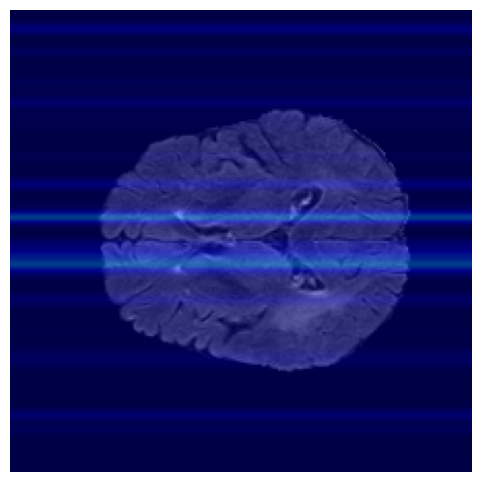

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_grad_cam import LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch.nn.functional as F
from torchvision import transforms

# --- Load your slice ---
slice_path = "/content/sample_brain_slice.png"  # replace with your slice path
slice_rgb = Image.open(slice_path).convert("RGB")
rgb_img = np.array(slice_rgb.resize((224, 224))) / 255.0  # normalize 0-1

# --- Prepare input tensor ---
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

input_tensor = preprocess(slice_rgb).unsqueeze(0)  # [1,3,224,224]

# --- Predict class ---
with torch.no_grad():
    outputs = model(input_tensor)
pred_class = outputs.argmax(dim=1).item()

# --- Use LayerCAM for smoother visualization ---
target_layers = [model.blocks[-1].norm2]  # last ViT block
cam = LayerCAM(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(pred_class)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# --- Resize CAM to full image and normalize ---
grayscale_cam_resized = F.interpolate(
    torch.tensor(grayscale_cam[None, None, :, :]),
    size=(224, 224),
    mode='bilinear',
    align_corners=False
)[0,0].numpy()

# Normalize CAM to 0-1
grayscale_cam_resized = (grayscale_cam_resized - grayscale_cam_resized.min()) / (grayscale_cam_resized.max() - grayscale_cam_resized.min())

# Apply Gaussian blur to remove stripes
grayscale_cam_smooth = cv2.GaussianBlur(grayscale_cam_resized, (11, 11), 0)

# --- Overlay CAM on original image ---
visualization = show_cam_on_image(rgb_img, grayscale_cam_smooth, use_rgb=True, colormap=cv2.COLORMAP_JET)

# --- Display ---
plt.figure(figsize=(6,6))
plt.imshow(visualization)
plt.axis("off")
plt.show()


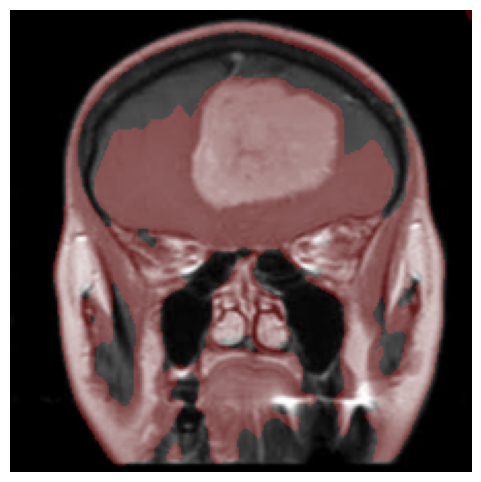

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# ------------------------
# 1️⃣ Define a simple U-Net
# ------------------------
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64,128,256,512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Encoder
        for feat in features:
            self.downs.append(nn.Sequential(
                nn.Conv2d(in_channels, feat, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(feat, feat, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            ))
            in_channels = feat
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Decoder
        for feat in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feat*2, feat, kernel_size=2, stride=2))
            self.ups.append(nn.Sequential(
                nn.Conv2d(feat*2, feat, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(feat, feat, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            ))

        self.bottleneck = nn.Sequential(
            nn.Conv2d(features[-1], features[-1]*2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(features[-1]*2, features[-1]*2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:])
            x = torch.cat([skip, x], dim=1)
            x = self.ups[idx+1](x)
        return torch.sigmoid(self.final_conv(x))  # output 0-1 mask

# ------------------------
# 2️⃣ Load slice
# ------------------------
slice_path = "/content/drive/MyDrive/test_images/sample-img10-meningioma.jpg"  # replace with your slice path
slice_img = Image.open(slice_path).convert("RGB")

# Preprocess
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])
input_tensor = preprocess(slice_img).unsqueeze(0)  # [1,3,224,224]

# ------------------------
# 3️⃣ Load trained U-Net
# ------------------------
model = UNet(in_channels=3, out_channels=1)
# If you have trained weights:
# model.load_state_dict(torch.load("unet_brats.pth"))
model.eval()

# ------------------------
# 4️⃣ Predict mask
# ------------------------
with torch.no_grad():
    mask_pred = model(input_tensor)[0,0].cpu().numpy()  # [224,224]

# Smooth mask
mask_pred_smooth = cv2.GaussianBlur(mask_pred, (11,11), 0)

# Normalize
mask_pred_smooth = (mask_pred_smooth - mask_pred_smooth.min()) / (mask_pred_smooth.max() - mask_pred_smooth.min())

# ------------------------
# 5️⃣ Overlay on original image
# ------------------------
rgb_img = np.array(slice_img.resize((224,224))) / 255.0
overlay = rgb_img.copy()
overlay[:,:,0] = np.where(mask_pred_smooth>0.5, 1.0, overlay[:,:,0])  # red highlight

visualization = cv2.addWeighted(rgb_img, 0.7, overlay, 0.3, 0)

# ------------------------
# 6️⃣ Display
# ------------------------
plt.figure(figsize=(6,6))
plt.imshow(visualization)
plt.axis("off")
plt.show()


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt


In [ ]:
class BratsDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale mask

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = np.array(mask)/255.0  # normalize to 0-1
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        return image, mask


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])


In [ ]:
import os

brats_path = "/content/drive/MyDrive/BRATS20"  # replace with your path

# List all subfolders and files
for root, dirs, files in os.walk(brats_path):
    print(f"Folder: {root}")
    print(f"  Subfolders: {dirs}")
    print(f"  Number of files: {len(files)}\n")


Folder: /content/drive/MyDrive/BRATS20
  Subfolders: ['BraTS2020_TrainingData', 'BraTS2020_ValidationData']
  Number of files: 0

Folder: /content/drive/MyDrive/BRATS20/BraTS2020_TrainingData
  Subfolders: ['.ipynb_checkpoints']
  Number of files: 0

Folder: /content/drive/MyDrive/BRATS20/BraTS2020_TrainingData/.ipynb_checkpoints
  Subfolders: []
  Number of files: 0

Folder: /content/drive/MyDrive/BRATS20/BraTS2020_ValidationData
  Subfolders: ['MICCAI_BraTS2020_TrainingData', 'MICCAI_BraTS2020_ValidationData']
  Number of files: 0

Folder: /content/drive/MyDrive/BRATS20/BraTS2020_ValidationData/MICCAI_BraTS2020_TrainingData
  Subfolders: ['BraTS20_Training_001', 'BraTS20_Training_003', 'BraTS20_Training_005', 'BraTS20_Training_007', 'BraTS20_Training_012', 'BraTS20_Training_024', 'BraTS20_Training_026', 'BraTS20_Training_032', 'BraTS20_Training_038', 'BraTS20_Training_040', 'BraTS20_Training_047', 'BraTS20_Training_064', 'BraTS20_Training_066', 'BraTS20_Training_071', 'BraTS20_Traini

In [ ]:
for root, dirs, files in os.walk(brats_path, topdown=False):
    for d in dirs:
        dir_path = os.path.join(root, d)
        if len(os.listdir(dir_path)) == 0:
            print(f"Removing empty folder: {dir_path}")
            os.rmdir(dir_path)


Removing empty folder: /content/drive/MyDrive/BRATS20/BraTS2020_TrainingData/.ipynb_checkpoints
Removing empty folder: /content/drive/MyDrive/BRATS20/BraTS2020_ValidationData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001
Removing empty folder: /content/drive/MyDrive/BRATS20/BraTS2020_ValidationData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003
Removing empty folder: /content/drive/MyDrive/BRATS20/BraTS2020_ValidationData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_005
Removing empty folder: /content/drive/MyDrive/BRATS20/BraTS2020_ValidationData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_012
Removing empty folder: /content/drive/MyDrive/BRATS20/BraTS2020_ValidationData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_026
Removing empty folder: /content/drive/MyDrive/BRATS20/BraTS2020_ValidationData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_032
Removing empty folder: /content/drive/MyDrive/BRATS20/BraTS2020_ValidationData/MICCAI_BraTS2020_TrainingData/BraTS20_Trainin

In [ ]:
valid_ext = (".png", ".jpg", ".jpeg", ".nii", ".nii.gz")  # adjust for BRATS
for root, dirs, files in os.walk(brats_path):
    for f in files:
        if not f.lower().endswith(valid_ext):
            print(f"Found non-image file: {os.path.join(root, f)}")


NameError: name 'brats_path' is not defined

In [ ]:
for root, dirs, files in os.walk(brats_path):
    for f in files:
        if not f.lower().endswith(valid_ext):
            os.remove(os.path.join(root, f))


NameError: name 'brats_path' is not defined

In [ ]:
import os

base_path = "/content/drive/MyDrive/BRATS20"
images_out = os.path.join(base_path, "images")
masks_out = os.path.join(base_path, "masks")

os.makedirs(images_out, exist_ok=True)
os.makedirs(masks_out, exist_ok=True)


In [ ]:
import nibabel as nib
import numpy as np
from PIL import Image

# Paths to Training and Validation folders
data_folders = [
    os.path.join(base_path, "BraTS2020_ValidationData", "MICCAI_BraTS2020_TrainingData"),
    os.path.join(base_path, "BraTS2020_ValidationData", "MICCAI_BraTS2020_ValidationData")
]

for data_folder in data_folders:
    patient_dirs = [f for f in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, f))]

    for patient in patient_dirs:
        patient_path = os.path.join(data_folder, patient)

        # List all files in patient folder
        files = os.listdir(patient_path)

        # Identify MRI modality (choose one, e.g., FLAIR)
        flair_files = [f for f in files if "flair.nii" in f.lower()]
        seg_files   = [f for f in files if "seg.nii" in f.lower()]

        if len(flair_files) == 0:
            continue  # skip if no flair

        flair_path = os.path.join(patient_path, flair_files[0])
        mask_path  = os.path.join(patient_path, seg_files[0]) if seg_files else None

        # Load NIfTI
        img_nii = nib.load(flair_path)
        img_data = img_nii.get_fdata()

        mask_data = None
        if mask_path:
            mask_nii = nib.load(mask_path)
            mask_data = mask_nii.get_fdata()

        # Iterate over axial slices
        for i in range(img_data.shape[2]):
            img_slice = img_data[:, :, i]

            if mask_data is not None:
                mask_slice = mask_data[:, :, i]
                if np.max(mask_slice) == 0:
                    continue  # skip empty slices
            else:
                mask_slice = None  # validation data has no masks

            # Normalize image slice
            img_norm = ((img_slice - np.min(img_slice)) / (np.max(img_slice) - np.min(img_slice)) * 255).astype(np.uint8)
            img_name = f"{patient}_slice_{i}.png"
            Image.fromarray(img_norm).save(os.path.join(images_out, img_name))

            # Save mask if exists
            if mask_slice is not None:
                mask_norm = (mask_slice * 255 / mask_slice.max()).astype(np.uint8)
                mask_name = f"{patient}_slice_{i}.png"
                Image.fromarray(mask_norm).save(os.path.join(masks_out, mask_name))


/tmp/ipython-input-3428062812.py:51: RuntimeWarning: invalid value encountered in divide
  img_norm = ((img_slice - np.min(img_slice)) / (np.max(img_slice) - np.min(img_slice)) * 255).astype(np.uint8)
/tmp/ipython-input-3428062812.py:51: RuntimeWarning: invalid value encountered in cast
  img_norm = ((img_slice - np.min(img_slice)) / (np.max(img_slice) - np.min(img_slice)) * 255).astype(np.uint8)


In [ ]:
import os

base_path = "/content/drive/MyDrive/BRATS20"
images_out = os.path.join(base_path, "images")
masks_out  = os.path.join(base_path, "masks")

# List images
image_files = sorted([f for f in os.listdir(images_out) if f.lower().endswith((".png",".jpg",".jpeg"))])
print(f"Total image slices: {len(image_files)}")
print("First 10 image files:", image_files[:10])

# List masks
mask_files = sorted([f for f in os.listdir(masks_out) if f.lower().endswith((".png",".jpg",".jpeg"))])
print(f"Total mask slices: {len(mask_files)}")
print("First 10 mask files:", mask_files[:10])


Total image slices: 20826
First 10 image files: ['BraTS20_Training_007_slice_35.png', 'BraTS20_Training_007_slice_36.png', 'BraTS20_Training_007_slice_37.png', 'BraTS20_Training_007_slice_38.png', 'BraTS20_Training_007_slice_39.png', 'BraTS20_Training_007_slice_40.png', 'BraTS20_Training_007_slice_41.png', 'BraTS20_Training_007_slice_42.png', 'BraTS20_Training_007_slice_43.png', 'BraTS20_Training_007_slice_44.png']
Total mask slices: 1296
First 10 mask files: ['BraTS20_Training_007_slice_35.png', 'BraTS20_Training_007_slice_36.png', 'BraTS20_Training_007_slice_37.png', 'BraTS20_Training_007_slice_38.png', 'BraTS20_Training_007_slice_39.png', 'BraTS20_Training_007_slice_40.png', 'BraTS20_Training_007_slice_41.png', 'BraTS20_Training_007_slice_42.png', 'BraTS20_Training_007_slice_43.png', 'BraTS20_Training_007_slice_44.png']


In [ ]:
# Create list of images that have masks
masked_images = [f for f in image_files if f in mask_files]
print(f"Total slices usable for training: {len(masked_images)}")
print("First 10 usable slices:", masked_images[:10])


Total slices usable for training: 1296
First 10 usable slices: ['BraTS20_Training_007_slice_35.png', 'BraTS20_Training_007_slice_36.png', 'BraTS20_Training_007_slice_37.png', 'BraTS20_Training_007_slice_38.png', 'BraTS20_Training_007_slice_39.png', 'BraTS20_Training_007_slice_40.png', 'BraTS20_Training_007_slice_41.png', 'BraTS20_Training_007_slice_42.png', 'BraTS20_Training_007_slice_43.png', 'BraTS20_Training_007_slice_44.png']


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class BratsSliceDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir

        # Only keep images that have corresponding masks
        image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(".png")]
        mask_files  = [f for f in os.listdir(masks_dir) if f.lower().endswith(".png")]
        self.files = sorted([f for f in image_files if f in mask_files])

        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Ensure mask is 0 or 1
        mask = torch.tensor(np.array(mask)/255., dtype=torch.float32).unsqueeze(0)

        return image, mask


In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Transform: resize, to tensor, normalize
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

# Initialize Dataset
dataset = BratsSliceDataset(images_dir=images_out, masks_dir=masks_out, transform=transform)

# DataLoader
loader = DataLoader(dataset, batch_size=4, shuffle=True)

print(f"Total training slices: {len(dataset)}")


Total training slices: 1296


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64,128,256,512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Downsampling path
        for feature in features:
            self.downs.append(self.double_conv(in_channels, feature))
            in_channels = feature
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = self.double_conv(features[-1], features[-1]*2)

        # Upsampling path
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(self.double_conv(feature*2, feature))

        # Final output layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](x)

        return torch.sigmoid(self.final_conv(x))

    def double_conv(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate model
model = UNet(in_channels=3, out_channels=1).to(device)

# Loss and optimizer
criterion = nn.BCELoss()  # binary segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Number of epochs
num_epochs = 5


Using device: cuda


In [ ]:
class BratsSliceDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir

        image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(".png")]
        mask_files  = [f for f in os.listdir(masks_dir) if f.lower().endswith(".png")]
        self.files = sorted([f for f in image_files if f in mask_files])

        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, img_name)

        # Load grayscale
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        # Resize both to 224x224
        image = image.resize((224,224))
        mask = mask.resize((224,224))

        # Apply transform only to image
        if self.transform:
            image = self.transform(image)

        # Convert mask to tensor manually
        mask = torch.tensor(np.array(mask)/255., dtype=torch.float32).unsqueeze(0)

        return image, mask


In [ ]:
from torchvision import transforms

# Check if model expects grayscale or RGB
expect_rgb = False  # change to True if model pretrained on RGB images

if expect_rgb:
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # ensure 3 channels
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  # for grayscale
    ])


In [ ]:
dataset = BratsSliceDataset(images_dir=images_out, masks_dir=masks_out, transform=transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [ ]:
import numpy as np


In [ ]:
dataset = BratsSliceDataset(images_dir=images_out, masks_dir=masks_out, transform=transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

images, masks = next(iter(loader))
print(images.shape, masks.shape)


torch.Size([4, 1, 224, 224]) torch.Size([4, 1, 224, 224])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model (already defined)
model = UNet(in_channels=1, out_channels=1).to(device)

# Loss and optimizer
criterion = nn.BCELoss()  # binary segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Number of epochs
num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Using device: cuda


KeyboardInterrupt: 

In [ ]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Save model weights to your Drive ---
save_path = "/content/drive/MyDrive/brats_trained_model.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ Model saved successfully at: {save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NameError: name 'torch' is not defined

In [ ]:
# Re-create model structure
model = UNet(in_channels=1, out_channels=1).to(device)

# Load saved weights
model.load_state_dict(torch.load("/content/drive/MyDrive/brats_trained_model.pth", map_location=device))
model.eval()

print("✅ Model loaded and ready for inference")


✅ Model loaded and ready for inference


In [ ]:
def dice_coefficient(preds, targets, smooth=1e-6):
    preds = (preds > 0.5).float()  # threshold
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

# --- After training loop ---
model.eval()
dice_scores = []

with torch.no_grad():
    for images, masks in loader:  # or use a separate val_loader if available
        images = images.to(device)
        masks = masks.to(device)

        outputs = torch.sigmoid(model(images))
        dice = dice_coefficient(outputs, masks)
        dice_scores.append(dice.item())

print(f"✅ Mean Dice score: {sum(dice_scores)/len(dice_scores):.4f}")


✅ Mean Dice score: 0.0286


In [ ]:
for t in [0.2, 0.3, 0.5]:
    score = []
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        outputs = torch.sigmoid(model(images))
        preds = (outputs > t).float()
        intersection = (preds * masks).sum(dim=(1,2,3))
        union = preds.sum(dim=(1,2,3)) + masks.sum(dim=(1,2,3))
        dice = (2. * intersection + 1e-6) / (union + 1e-6)
        score.append(dice.mean().item())
    print(f"Threshold {t}: Mean Dice {sum(score)/len(score):.4f}")




Threshold 0.2: Mean Dice 0.0286
Threshold 0.3: Mean Dice 0.0286
Threshold 0.5: Mean Dice 0.0286


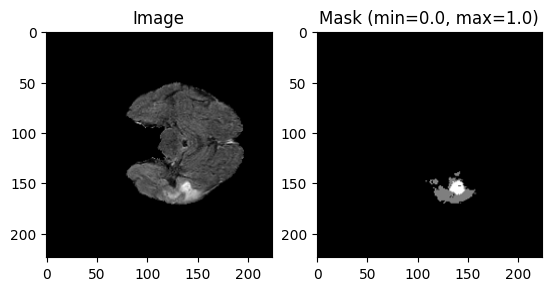

In [ ]:
import matplotlib.pyplot as plt

img, mask = dataset[10]
plt.subplot(1,2,1)
plt.imshow(img[0], cmap='gray')
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(mask[0], cmap='gray')
plt.title(f"Mask (min={mask.min():.1f}, max={mask.max():.1f})")
plt.show()


✅ Model loaded successfully.


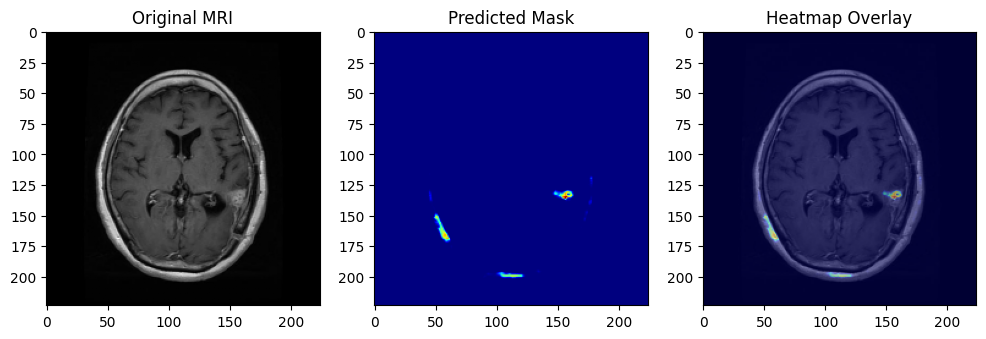

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load model ---
model = UNet(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/brats_trained_model.pth", map_location=device))
model.eval()
print("✅ Model loaded successfully.")

# --- Preprocessing transform (same as training) ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# --- Load a test image ---
img_path = "/content/drive/MyDrive/test_images/sample-img9-glioma.jpg"   # 👈 change to your image path
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, (224, 224))

# --- Prepare tensor ---
input_tensor = transform(img_resized).unsqueeze(0).to(device)  # [1,1,224,224]

# --- Predict mask ---
with torch.no_grad():
    pred_mask = torch.sigmoid(model(input_tensor))[0,0].cpu().numpy()

# --- Normalize prediction ---
pred_mask = (pred_mask - pred_mask.min()) / (pred_mask.max() - pred_mask.min())

# --- Create heatmap ---
heatmap = cv2.applyColorMap(np.uint8(255 * pred_mask), cv2.COLORMAP_JET)

# --- Overlay heatmap on original grayscale image ---
overlay = cv2.addWeighted(cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR), 0.6, heatmap, 0.4, 0)

# --- Display results ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img_resized, cmap='gray')
plt.title("Original MRI")

plt.subplot(1,3,2)
plt.imshow(pred_mask, cmap='jet')
plt.title("Predicted Mask")

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Heatmap Overlay")

plt.show()


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Down path
        for feature in features:
            self.downs.append(self.double_conv(in_channels, feature))
            in_channels = feature
        self.pool = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.bottleneck = self.double_conv(features[-1], features[-1]*2)

        # Up path
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(self.double_conv(feature*2, feature))

        # Final conv
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def double_conv(self, in_c, out_c):
        # ✅ bias=True so weights match your checkpoint
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=True),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=True),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]
            if x.shape != skip.shape:
                x = TF.resize(x, size=skip.shape[2:])
            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](x)

        return torch.sigmoid(self.final_conv(x))


In [ ]:
model = UNet(in_channels=1, out_channels=1)
state_dict = torch.load("/content/drive/MyDrive/brats_trained_model.pth", map_location='cpu')
model.load_state_dict(state_dict)
model.eval()
print("✅ Model loaded successfully with bias=True!")


✅ Model loaded successfully with bias=True!


✅ Results saved to /content/drive/MyDrive/results/


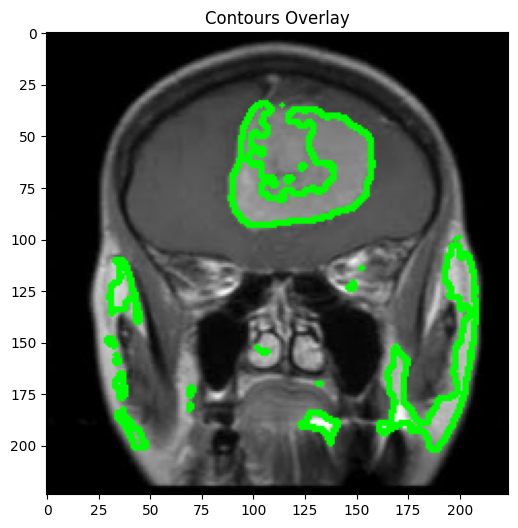

In [ ]:
# --- Optional: Threshold the mask for binary segmentation ---
threshold = 0.5
binary_mask = (pred_mask > threshold).astype(np.uint8) * 255  # 0 or 255

# --- Save results ---
output_dir = "/content/drive/MyDrive/results/"
cv2.imwrite(output_dir + "pred_mask.png", np.uint8(pred_mask * 255))
cv2.imwrite(output_dir + "binary_mask.png", binary_mask)
cv2.imwrite(output_dir + "overlay.png", overlay)
print("✅ Results saved to", output_dir)

# --- Optional: Extract contours from the binary mask ---
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_contours = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_contours, contours, -1, (0,255,0), 2)

# --- Display contours overlay ---
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
plt.title("Contours Overlay")
plt.show()

# --- Optional: Compute simple metrics if ground truth available ---
# gt_mask = cv2.imread("/path/to/ground_truth.png", cv2.IMREAD_GRAYSCALE)
# dice_score = 2 * np.sum(binary_mask & gt_mask) / (np.sum(binary_mask) + np.sum(gt_mask))
# print("Dice Score:", dice_score)


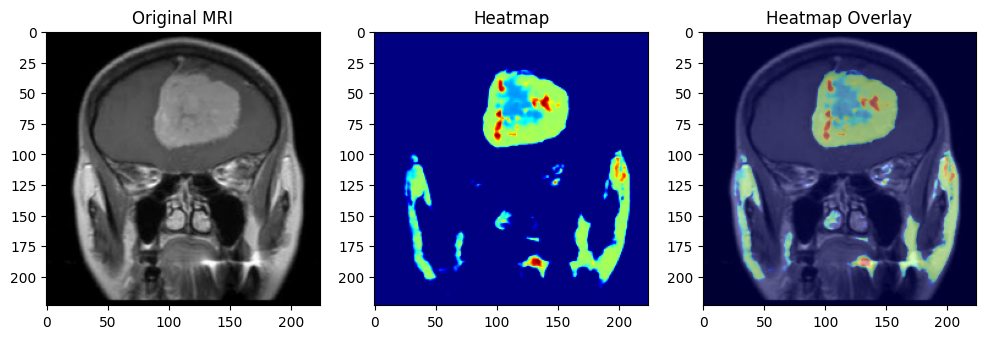

✅ Heatmap and overlay saved to /content/drive/MyDrive/results/


In [ ]:
# --- Normalize prediction for heatmap ---
pred_mask = (pred_mask - pred_mask.min()) / (pred_mask.max() - pred_mask.min())

# --- Create heatmap (colored) ---
heatmap = cv2.applyColorMap(np.uint8(255 * pred_mask), cv2.COLORMAP_JET)

# --- Overlay heatmap on original grayscale image ---
alpha = 0.4  # transparency for heatmap
overlay = cv2.addWeighted(cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR), 1-alpha, heatmap, alpha, 0)

# --- Display results ---
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_resized, cmap='gray')
plt.title("Original MRI")

plt.subplot(1,3,2)
plt.imshow(heatmap[..., ::-1])  # Convert BGR to RGB
plt.title("Heatmap")

plt.subplot(1,3,3)
plt.imshow(overlay[..., ::-1])
plt.title("Heatmap Overlay")

plt.show()

# --- Save heatmap results ---
output_dir = "/content/drive/MyDrive/results/"
cv2.imwrite(output_dir + "heatmap.png", heatmap)
cv2.imwrite(output_dir + "overlay_heatmap.png", overlay)
print("✅ Heatmap and overlay saved to", output_dir)


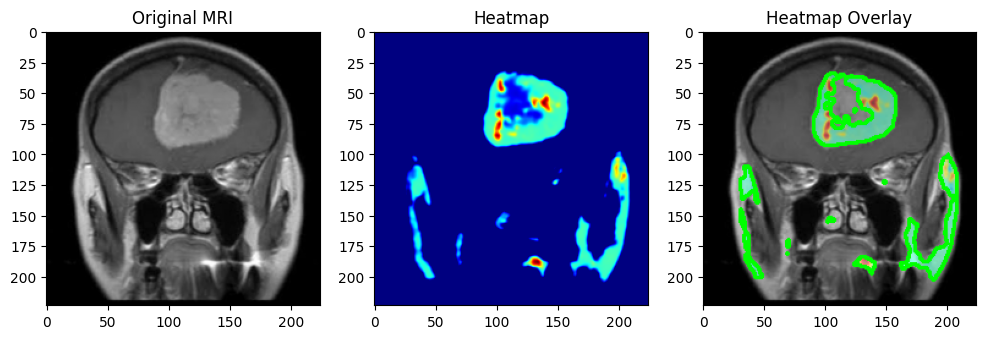

✅ Heatmap and overlay saved to /content/drive/MyDrive/results/


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Example: UNet prediction mask and original image ---
# pred_mask: predicted mask from UNet (float32, range 0-1)
# img: original grayscale MRI image

# --- Step 1: Resize image exactly as training ---
img_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
pred_mask_resized = cv2.resize(pred_mask, (224, 224), interpolation=cv2.INTER_LINEAR)

# --- Step 2: Smooth prediction to reduce noise ---
pred_mask_smooth = cv2.GaussianBlur(pred_mask_resized, (5,5), 0)

# --- Step 3: Clip low-confidence areas and normalize ---
pred_mask_clipped = np.clip(pred_mask_smooth, 0.2, 1.0)  # focus on >20% confidence
pred_mask_norm = (pred_mask_clipped - pred_mask_clipped.min()) / (pred_mask_clipped.max() - pred_mask_clipped.min())

# --- Step 4: Create heatmap ---
heatmap = cv2.applyColorMap(np.uint8(255 * pred_mask_norm), cv2.COLORMAP_JET)

# --- Step 5: Overlay only high-confidence areas ---
alpha = 0.5
overlay = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR).copy()
mask_high = pred_mask_norm > 0.3
overlay[mask_high] = cv2.addWeighted(overlay, 1-alpha, heatmap, alpha, 0)[mask_high]

# --- Step 6 (Optional): Draw contours for clear tumor boundaries ---
binary_mask = (pred_mask_norm > 0.3).astype(np.uint8) * 255
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(overlay, contours, -1, (0,255,0), 2)

# --- Step 7: Display results ---
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_resized, cmap='gray')
plt.title("Original MRI")

plt.subplot(1,3,2)
plt.imshow(heatmap[..., ::-1])  # Convert BGR to RGB
plt.title("Heatmap")

plt.subplot(1,3,3)
plt.imshow(overlay[..., ::-1])
plt.title("Heatmap Overlay")

plt.show()

# --- Step 8: Save results ---
output_dir = "/content/drive/MyDrive/results/"
cv2.imwrite(output_dir + "heatmap.png", heatmap)
cv2.imwrite(output_dir + "overlay_heatmap.png", overlay)
print("✅ Heatmap and overlay saved to", output_dir)


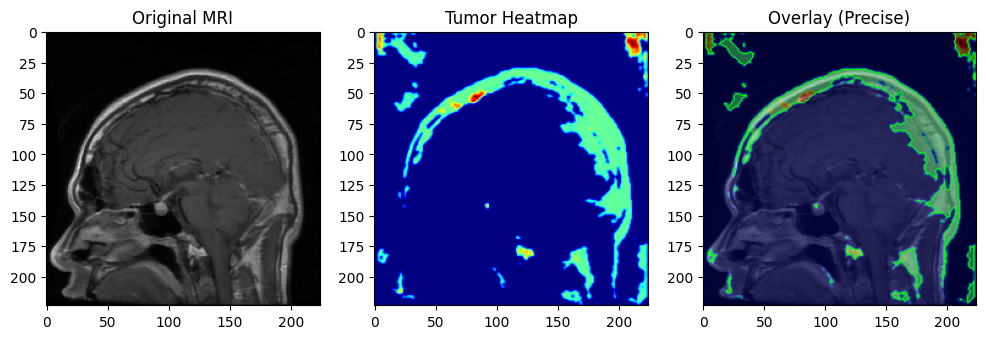

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

# =========================================================
# Step 1 — Load original MRI image
# =========================================================
img_path = "/content/drive/MyDrive/test_images/sample-img4-pituitary.jpg"  # change to your image path
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# normalize for model input
img_input = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
img_input = img_input.astype(np.float32) / 255.0
img_tensor = torch.from_numpy(img_input).unsqueeze(0).unsqueeze(0)  # shape: [1,1,224,224]

# =========================================================
# Step 2 — Predict mask using your trained U-Net
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# make sure you have loaded your trained U-Net model
# model = UNet(in_channels=1, out_channels=1).to(device)
# model.load_state_dict(torch.load("/path/to/model.pth", map_location=device))
model.eval()

with torch.no_grad():
    pred = model(img_tensor.to(device))
    pred_mask = torch.sigmoid(pred).cpu().numpy()[0,0]  # shape (224,224), range 0–1

# =========================================================
# Step 3 — Refined Heatmap Visualization
# =========================================================
img_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
pred_mask_resized = cv2.resize(pred_mask, (224, 224), interpolation=cv2.INTER_LINEAR)

# Emphasize high-confidence tumor areas
pred_mask_enhanced = np.power(pred_mask_resized, 2.5)
pred_mask_norm = cv2.normalize(pred_mask_enhanced, None, 0, 1, cv2.NORM_MINMAX)
pred_mask_thresh = np.where(pred_mask_norm > 0.4, pred_mask_norm, 0)
pred_mask_smooth = cv2.GaussianBlur(pred_mask_thresh, (3,3), 0)

# Generate heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * pred_mask_smooth), cv2.COLORMAP_JET)

# Overlay on grayscale MRI
img_color = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR)
overlay = cv2.addWeighted(img_color, 0.6, heatmap, 0.4, 0)

# Optional: draw contours
binary_mask = (pred_mask_smooth > 0.4).astype(np.uint8) * 255
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(overlay, contours, -1, (0, 255, 0), 1)

# =========================================================
# Step 4 — Display results
# =========================================================
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img_resized, cmap='gray')
plt.title("Original MRI")

plt.subplot(1,3,2)
plt.imshow(heatmap[..., ::-1])
plt.title("Tumor Heatmap")

plt.subplot(1,3,3)
plt.imshow(overlay[..., ::-1])
plt.title("Overlay (Precise)")

plt.show()


✅ Model loaded successfully.
✅ Heatmap and overlay saved to: /content/drive/MyDrive/results/


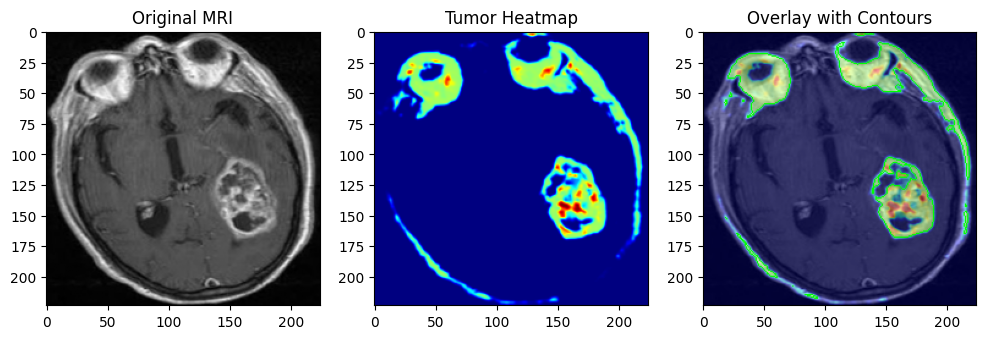

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
import os

# --- Device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load trained model ---
model = UNet(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/brats_trained_model.pth", map_location=device))
model.eval()
print("✅ Model loaded successfully.")

# --- Preprocessing transform (same as training) ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# --- Load a test image ---
img_path = "/content/drive/MyDrive/test_images/sample_img1-meningioma.jpg"  # 👈 change path if needed
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, (224, 224))

# --- Prepare input tensor ---
input_tensor = transform(img_resized).unsqueeze(0).to(device)  # [1,1,224,224]

# --- Predict segmentation mask ---
with torch.no_grad():
    pred_mask = torch.sigmoid(model(input_tensor))[0,0].cpu().numpy()

# --- Normalize and smooth prediction ---
pred_mask = (pred_mask - pred_mask.min()) / (pred_mask.max() - pred_mask.min())
pred_mask = cv2.GaussianBlur(pred_mask, (3, 3), 0)  # smooth edges

# --- Create color heatmap ---
heatmap = cv2.applyColorMap(np.uint8(255 * pred_mask), cv2.COLORMAP_JET)

# --- Overlay heatmap on grayscale MRI ---
overlay = cv2.addWeighted(cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR), 0.6, heatmap, 0.4, 0)

# --- Draw tumor contours ---
contours, _ = cv2.findContours((pred_mask > 0.4).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(overlay, contours, -1, (0, 255, 0), 1)

# --- Create output directory ---
output_dir = "/content/drive/MyDrive/results/"
os.makedirs(output_dir, exist_ok=True)

# --- Save outputs ---
heatmap_path = os.path.join(output_dir, "tumor_heatmap.png")
overlay_path = os.path.join(output_dir, "tumor_heatmap_overlay.png")
cv2.imwrite(heatmap_path, heatmap)
cv2.imwrite(overlay_path, overlay)
print(f"✅ Heatmap and overlay saved to: {output_dir}")

# --- Display results ---
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_resized, cmap='gray')
plt.title("Original MRI")

plt.subplot(1,3,2)
plt.imshow(heatmap[..., ::-1])  # BGR→RGB
plt.title("Tumor Heatmap")

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Overlay with Contours")

plt.show()


In [ ]:
# Count predicted tumor regions
binary_mask = (pred_mask > 0.5).astype(np.uint8)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
print("Detected regions:", num_labels - 1)
print("Area of each region:", stats[1:, cv2.CC_STAT_AREA])


Detected regions: 18
Area of each region: [  18    3    1 1476 1153    9    2    4    2    1   74 1144   26   15
    8    2   43    2]



🧩 Processing Pair 1: BraTS20_Training_007_slice_35.png & BraTS20_Training_007_slice_35.png
✅ Detected regions: 1
📏 Area of each region: [1]


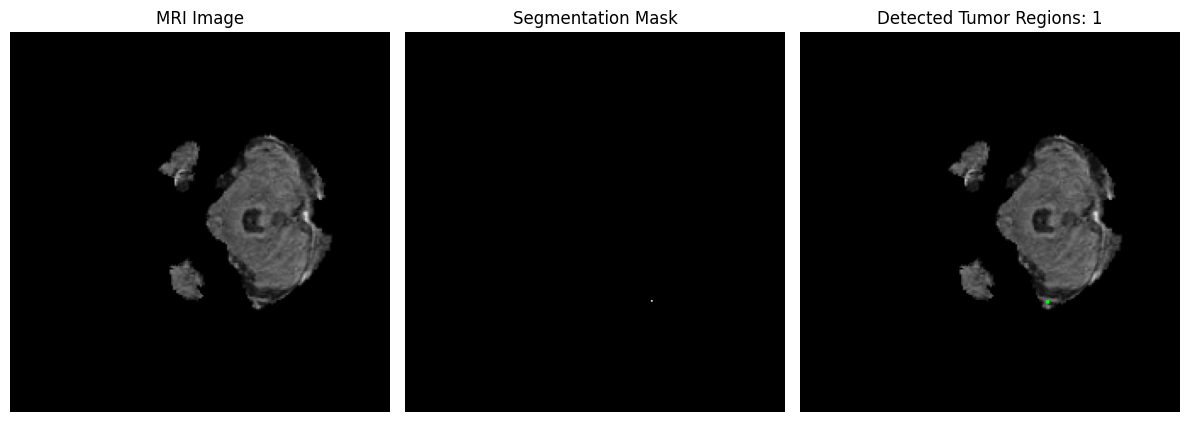


🧩 Processing Pair 2: BraTS20_Training_007_slice_36.png & BraTS20_Training_007_slice_36.png
✅ Detected regions: 3
📏 Area of each region: [4, 4, 10]


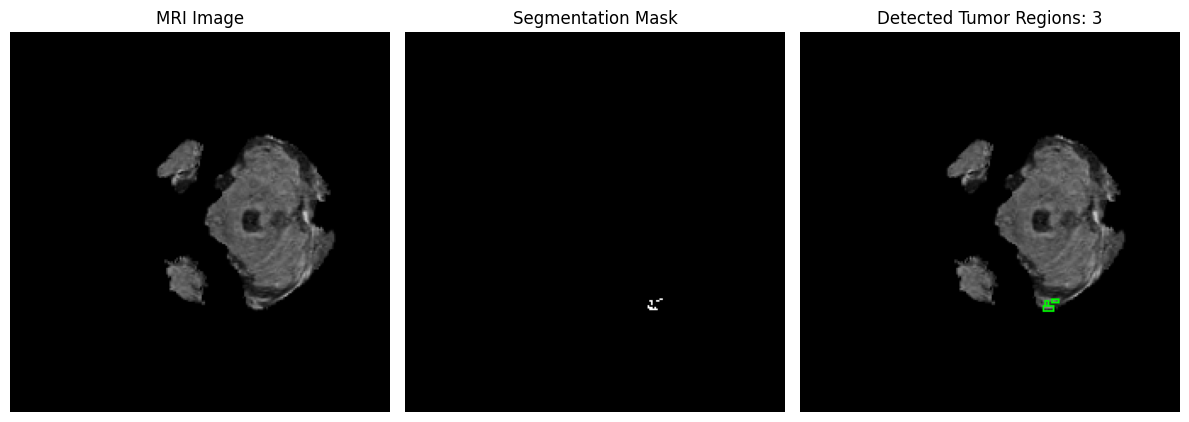


🧩 Processing Pair 3: BraTS20_Training_007_slice_37.png & BraTS20_Training_007_slice_37.png
✅ Detected regions: 1
📏 Area of each region: [40]


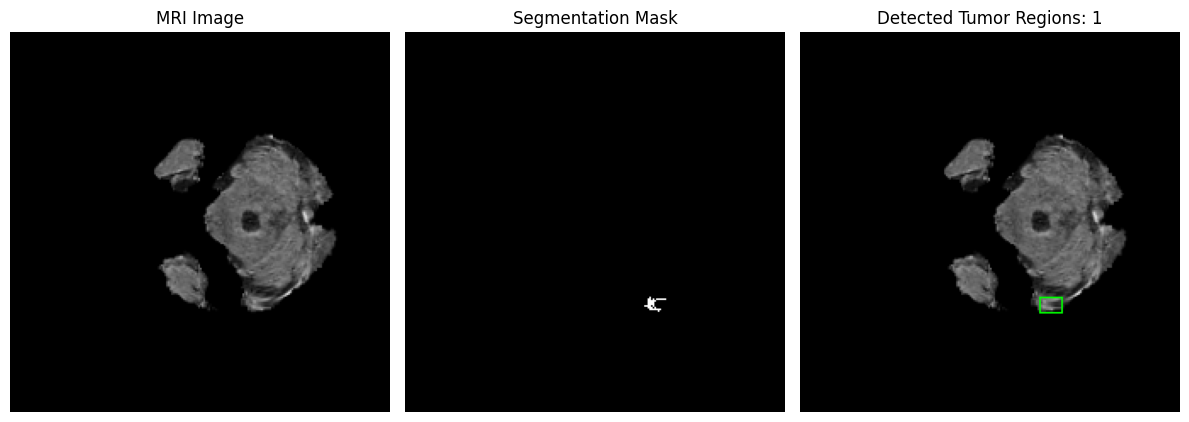


🧩 Processing Pair 4: BraTS20_Training_007_slice_38.png & BraTS20_Training_007_slice_38.png
✅ Detected regions: 2
📏 Area of each region: [67, 1]


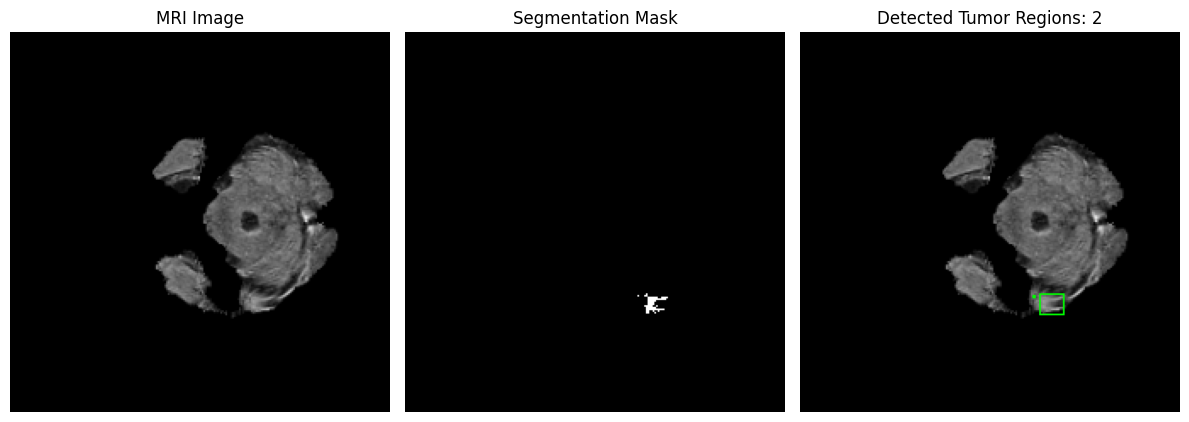


🧩 Processing Pair 5: BraTS20_Training_007_slice_39.png & BraTS20_Training_007_slice_39.png
✅ Detected regions: 5
📏 Area of each region: [2, 4, 99, 3, 1]


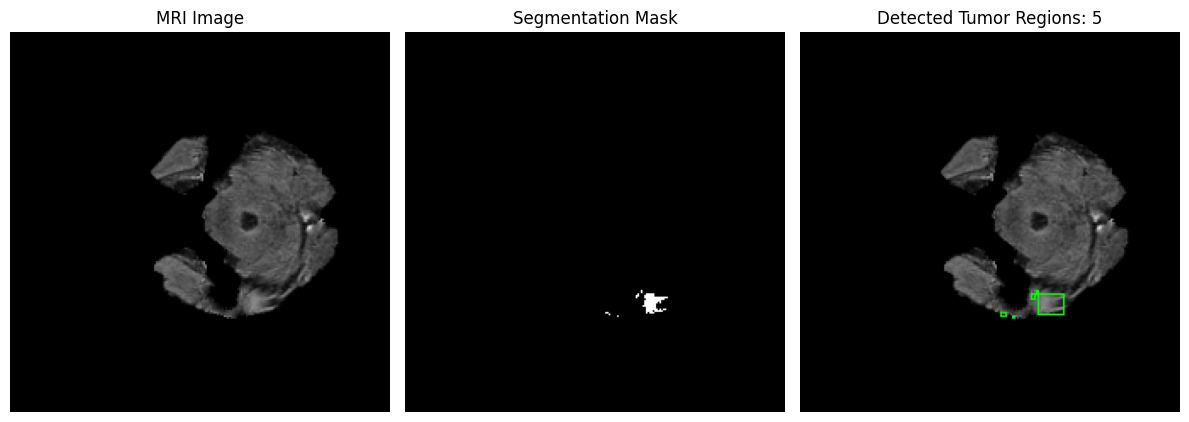


🧩 Processing Pair 6: BraTS20_Training_007_slice_40.png & BraTS20_Training_007_slice_40.png
✅ Detected regions: 9
📏 Area of each region: [1, 149, 10, 1, 18, 7, 1, 1, 1]


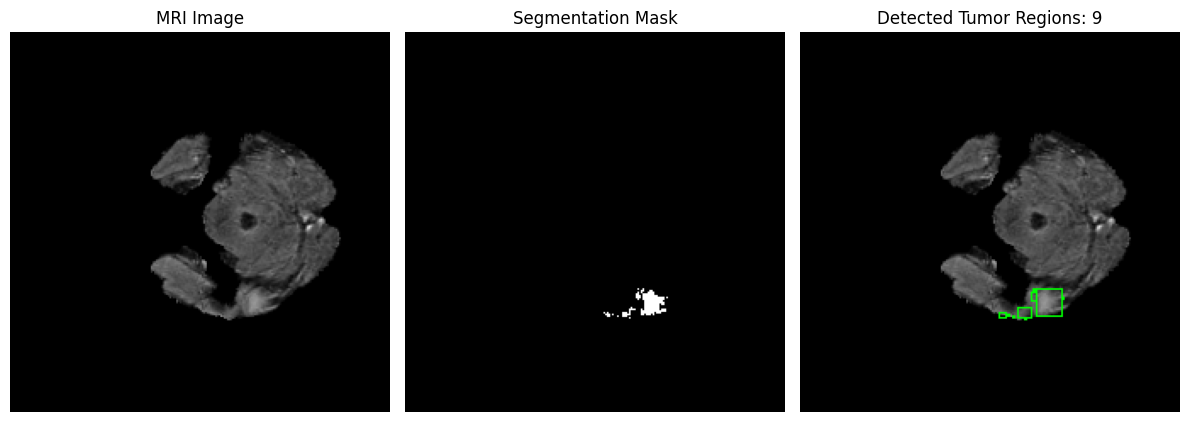


🧩 Processing Pair 7: BraTS20_Training_007_slice_41.png & BraTS20_Training_007_slice_41.png
✅ Detected regions: 2
📏 Area of each region: [26, 1]


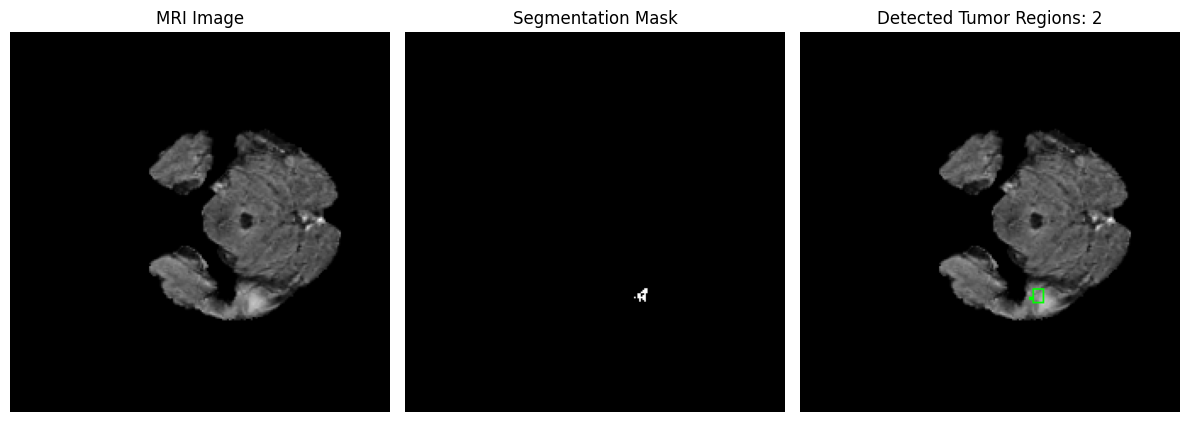


🧩 Processing Pair 8: BraTS20_Training_007_slice_42.png & BraTS20_Training_007_slice_42.png
✅ Detected regions: 2
📏 Area of each region: [56, 2]


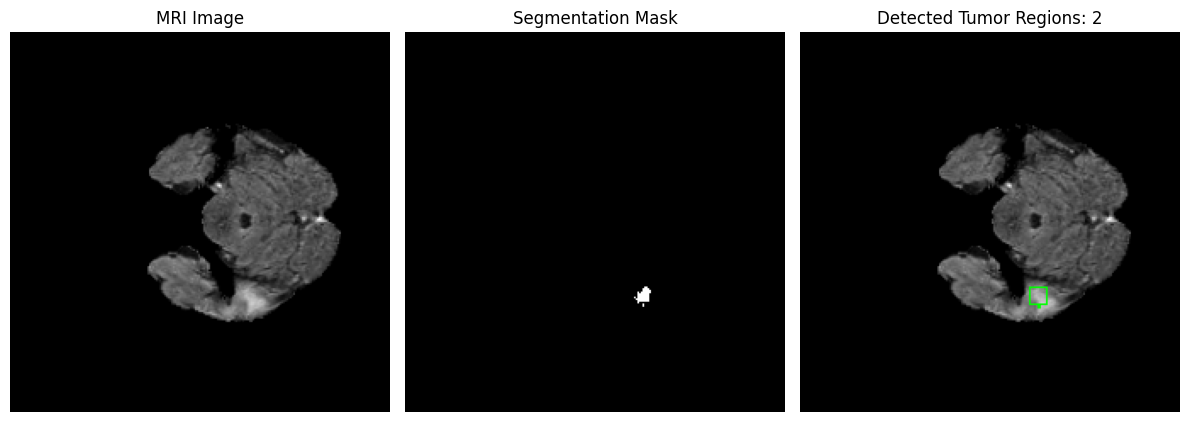


🧩 Processing Pair 9: BraTS20_Training_007_slice_43.png & BraTS20_Training_007_slice_43.png
✅ Detected regions: 2
📏 Area of each region: [82, 1]


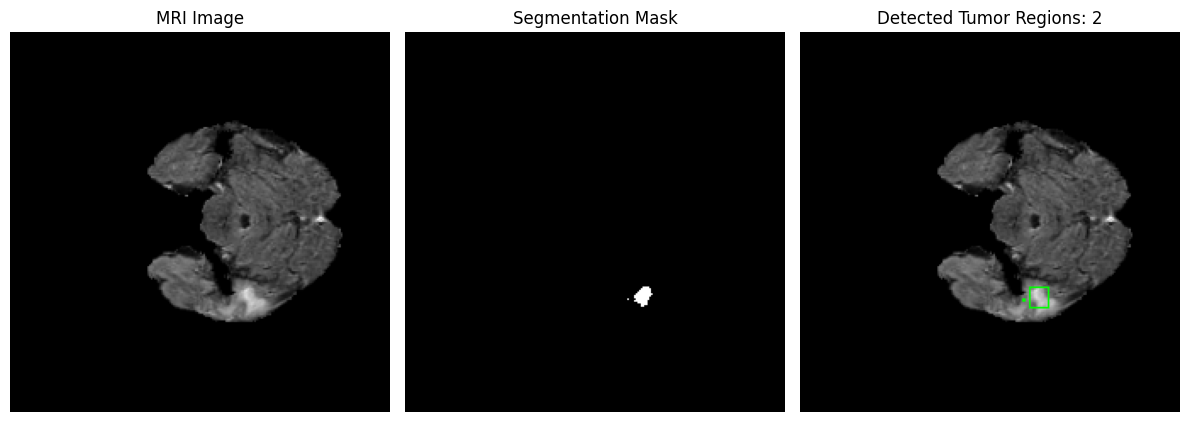


🧩 Processing Pair 10: BraTS20_Training_007_slice_44.png & BraTS20_Training_007_slice_44.png
✅ Detected regions: 2
📏 Area of each region: [112, 1]


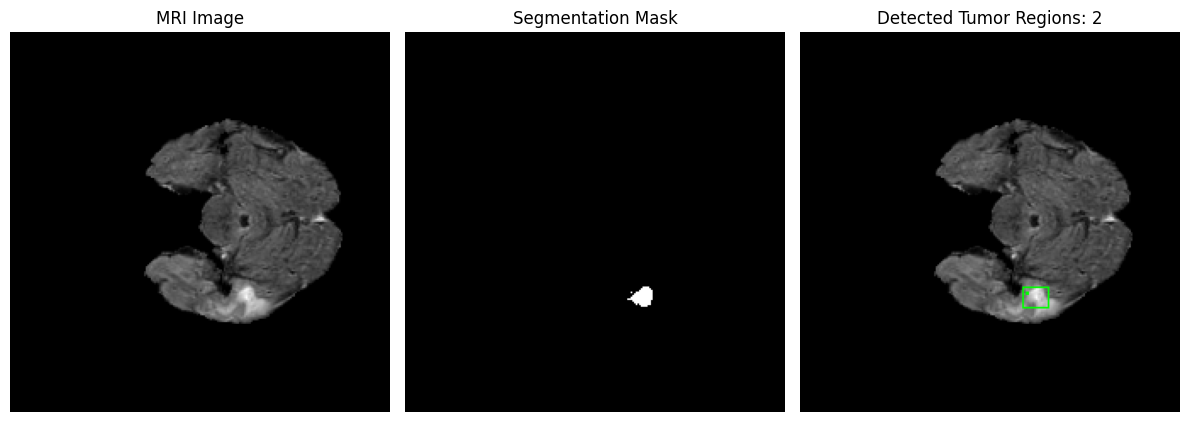


🧩 Processing Pair 11: BraTS20_Training_007_slice_45.png & BraTS20_Training_007_slice_45.png
✅ Detected regions: 1
📏 Area of each region: [138]


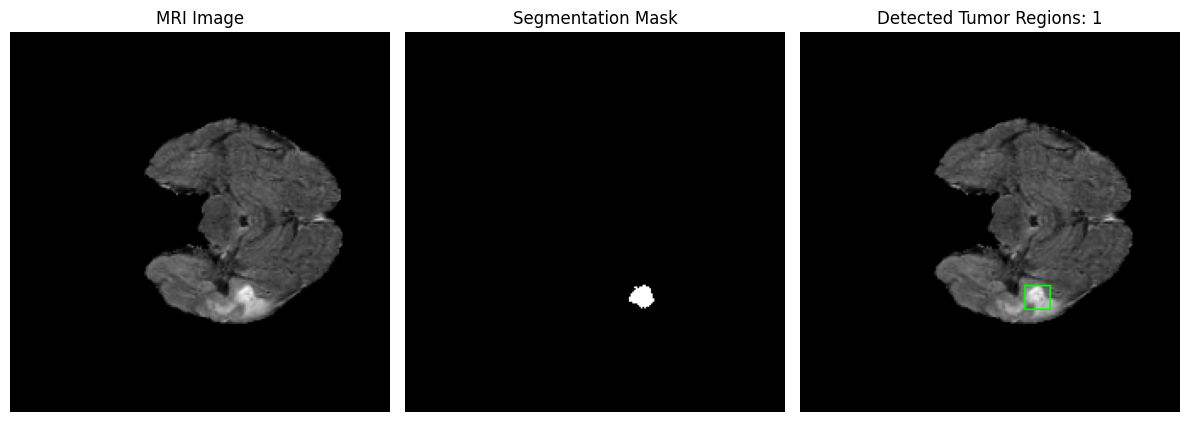


🧩 Processing Pair 12: BraTS20_Training_007_slice_46.png & BraTS20_Training_007_slice_46.png
✅ Detected regions: 1
📏 Area of each region: [156]


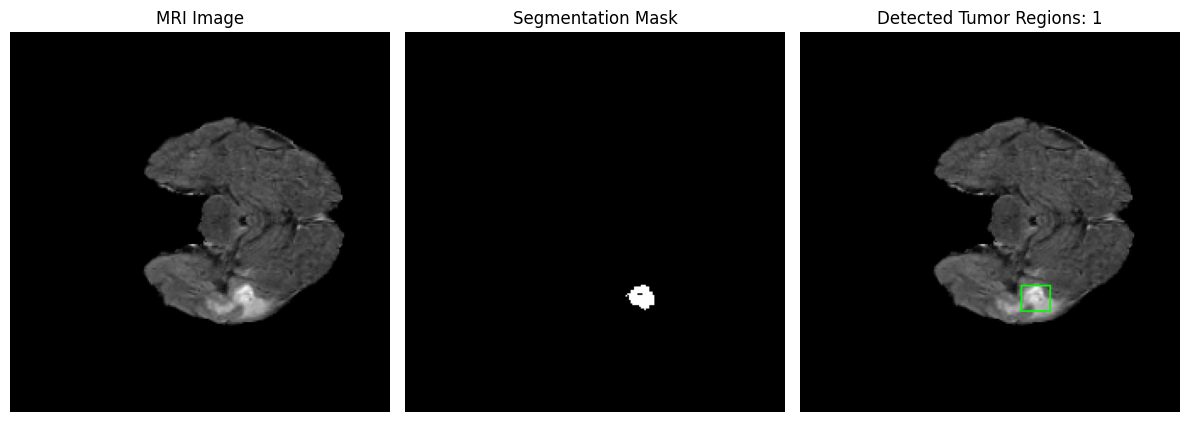


🧩 Processing Pair 13: BraTS20_Training_007_slice_47.png & BraTS20_Training_007_slice_47.png
✅ Detected regions: 2
📏 Area of each region: [165, 1]


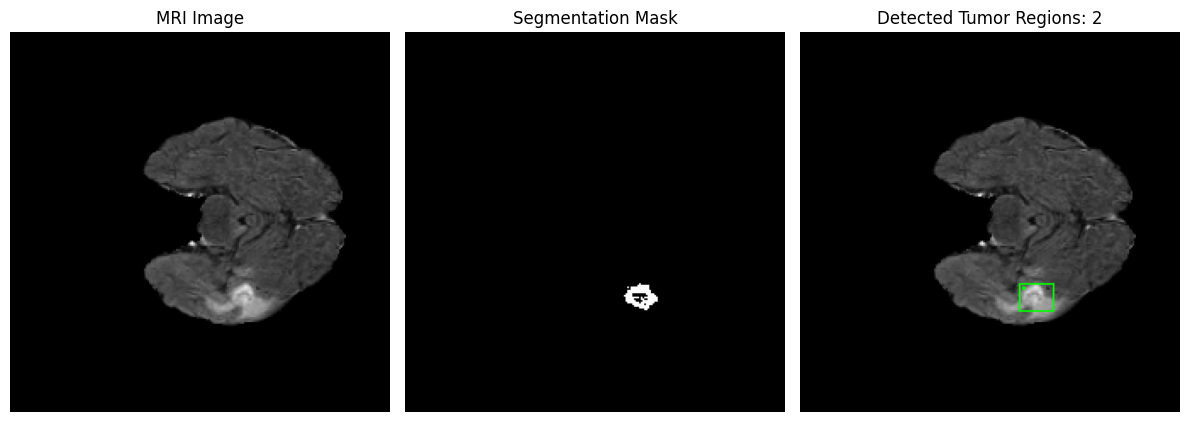


🧩 Processing Pair 14: BraTS20_Training_007_slice_48.png & BraTS20_Training_007_slice_48.png


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

# --- Step 1: Set dataset directories ---
# Update these paths to match your dataset folder structure
images_dir = "/content/drive/MyDrive/BRATS20/images"   # Folder with MRI images
masks_dir = "/content/drive/MyDrive/BRATS20/masks"     # Folder with segmentation masks

# --- Step 2: Get all filenames ---
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Sanity check
if not image_files or not mask_files:
    raise FileNotFoundError("❌ No image or mask files found in the specified directories!")

# --- Step 3: Loop through dataset ---
for i, (img_name, mask_name) in enumerate(zip(image_files, mask_files)):
    print(f"\n🧩 Processing Pair {i+1}: {img_name} & {mask_name}")

    # Load image and mask
    img = cv2.imread(os.path.join(images_dir, img_name))
    mask = cv2.imread(os.path.join(masks_dir, mask_name), cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
        print(f"⚠️ Skipping pair {img_name}, {mask_name} due to read error.")
        continue

    # --- Step 4: Resize (optional if already 240x240 or 256x256) ---
    img_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
    mask_resized = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_NEAREST)

    # --- Step 5: Threshold mask to binary ---
    _, binary_mask = cv2.threshold(mask_resized, 127, 255, cv2.THRESH_BINARY)

    # --- Step 6: Detect connected regions ---
    labeled_mask = label(binary_mask)
    regions = regionprops(labeled_mask)

    num_regions = len(regions)
    areas = [int(r.area) for r in regions]

    print(f"✅ Detected regions: {num_regions}")
    print(f"📏 Area of each region: {areas}")

    # --- Step 7: Overlay visualization ---
    overlay = img_resized.copy()
    for r in regions:
        y1, x1, y2, x2 = r.bbox
        cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 255, 0), 1)

    # --- Step 8: Display ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.title("MRI Image")
    plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Segmentation Mask")
    plt.imshow(binary_mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title(f"Detected Tumor Regions: {num_regions}")
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()


✅ Model loaded successfully.


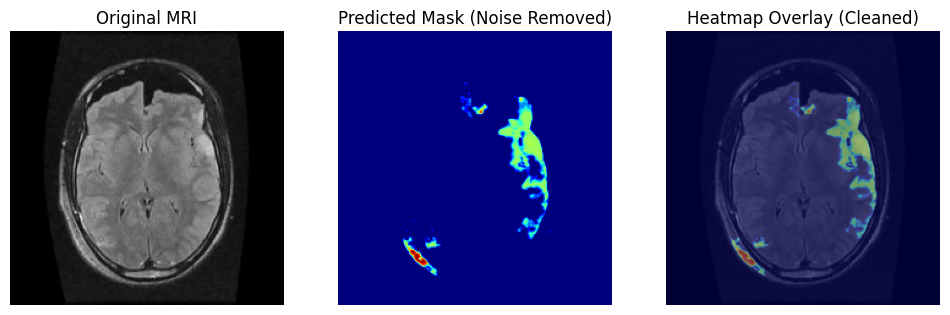

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load model ---
model = UNet(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/brats_trained_model.pth", map_location=device))
model.eval()
print("✅ Model loaded successfully.")

# --- Preprocessing transform (same as training) ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# --- Load a test image ---
img_path = "/content/drive/MyDrive/test_images/sample-img7-notumor.jpg"   # 👈 change to your image path
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, (224, 224))

# --- Prepare tensor ---
input_tensor = transform(img_resized).unsqueeze(0).to(device)  # [1,1,224,224]

# --- Predict mask ---
with torch.no_grad():
    pred_mask = torch.sigmoid(model(input_tensor))[0,0].cpu().numpy()

# --- Normalize prediction ---
pred_mask = (pred_mask - pred_mask.min()) / (pred_mask.max() - pred_mask.min())

# --- Remove noise: set values below 0.1 to 0 ---
noise_threshold = 0.1
pred_mask[pred_mask < noise_threshold] = 0

# --- Create heatmap ---
heatmap = cv2.applyColorMap(np.uint8(255 * pred_mask), cv2.COLORMAP_JET)

# --- Overlay heatmap on original grayscale image ---
overlay = cv2.addWeighted(cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR), 0.6, heatmap, 0.4, 0)

# --- Display results ---
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_resized, cmap='gray')
plt.title("Original MRI")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(pred_mask, cmap='jet')
plt.title("Predicted Mask (Noise Removed)")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Heatmap Overlay (Cleaned)")
plt.axis('off')

plt.show()


In [ ]:
import torch
import cv2
import numpy as np
import gradio as gr
from PIL import Image
from torchvision import transforms


# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load classification model (ViT) ---
from transformers import ViTFeatureExtractor, ViTForImageClassification

cls_model_path = "/content/drive/MyDrive/brain_tumor_vit_model"
cls_model = ViTForImageClassification.from_pretrained(cls_model_path)
feature_extractor = ViTFeatureExtractor.from_pretrained(cls_model_path)
cls_model.to(device)
cls_model.eval()

# --- Load segmentation model (UNet) ---
seg_model = UNet(in_channels=1, out_channels=1).to(device)
seg_model.load_state_dict(torch.load("/content/drive/MyDrive/brats_trained_model.pth", map_location=device))
seg_model.eval()

# --- Preprocessing ---
cls_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

seg_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# --- Function to process input ---
def classify_and_heatmap(img):
    # Convert to PIL if needed
    if isinstance(img, np.ndarray):
        img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        img_pil = img

    # --- Classification ---
    inputs = cls_transform(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = cls_model(inputs).logits
        pred_idx = outputs.argmax(dim=1).item()

    classes = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
    pred_class = classes[pred_idx]

    # --- Initialize outputs ---
    heatmap_overlay = None

    # --- Generate heatmap if tumor exists ---
    if pred_class != 'no_tumor':
        # Preprocess grayscale for UNet
        img_gray = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2GRAY)
        img_resized = cv2.resize(img_gray, (224,224))
        input_tensor = seg_transform(img_resized).unsqueeze(0).to(device)

        with torch.no_grad():
            pred_mask = torch.sigmoid(seg_model(input_tensor))[0,0].cpu().numpy()

        # Normalize & remove noise
        pred_mask = (pred_mask - pred_mask.min()) / (pred_mask.max() - pred_mask.min())
        pred_mask[pred_mask < 0.1] = 0

        # Create heatmap overlay
        heatmap = cv2.applyColorMap(np.uint8(255 * pred_mask), cv2.COLORMAP_JET)
        heatmap_overlay = cv2.addWeighted(cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR), 0.6, heatmap, 0.4, 0)
        heatmap_overlay = cv2.cvtColor(heatmap_overlay, cv2.COLOR_BGR2RGB)

    return pred_class, heatmap_overlay

# --- Gradio interface ---
iface = gr.Interface(
    fn=classify_and_heatmap,
    inputs=gr.Image(type="numpy"),
    outputs=[
        gr.Textbox(label="Predicted Class"),
        gr.Image(label="Tumor Heatmap Overlay")
    ],
    title="Brain Tumor Classification + Heatmap",
    description="Upload an MRI image: classifies tumor type and generates heatmap if tumor exists."
)

iface.launch()


/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://88305d77d196a5f1b1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import torch
import cv2
import numpy as np
import gradio as gr
from PIL import Image
from torchvision import transforms
from transformers import ViTImageProcessor, ViTForImageClassification

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load classification model ---
cls_model_path = "/content/drive/MyDrive/brain_tumor_vit_model"
cls_processor = ViTImageProcessor.from_pretrained(cls_model_path)
cls_model = ViTForImageClassification.from_pretrained(cls_model_path)
cls_model.to(device)
cls_model.eval()

# --- Load segmentation model (UNet) ---
seg_model = UNet(in_channels=1, out_channels=1).to(device)
seg_model.load_state_dict(torch.load("/content/drive/MyDrive/brats_trained_model.pth", map_location=device))
seg_model.eval()

# --- Preprocessing ---
seg_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# --- Function ---
def classify_and_heatmap(img):
    if isinstance(img, np.ndarray):
        img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        img_pil = img

    # Classification
    inputs = cls_processor(images=img_pil, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        outputs = cls_model(inputs).logits
        pred_idx = outputs.argmax(dim=1).item()

    classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    pred_class = classes[pred_idx]

    # Initialize blank images
    blank_img = np.zeros((224,224), dtype=np.uint8)
    mask_img = blank_img.copy()
    heatmap_overlay = cv2.cvtColor(blank_img.copy(), cv2.COLOR_GRAY2RGB)

    # Generate heatmap if tumor exists
    if pred_class != 'No Tumor':
        img_gray = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2GRAY)
        img_resized = cv2.resize(img_gray, (224,224))
        input_tensor = seg_transform(img_resized).unsqueeze(0).to(device)

        with torch.no_grad():
            pred_mask = torch.sigmoid(seg_model(input_tensor))[0,0].cpu().numpy()

        pred_mask = (pred_mask - pred_mask.min()) / (pred_mask.max() - pred_mask.min())
        pred_mask[pred_mask < 0.1] = 0

        mask_img = (pred_mask * 255).astype(np.uint8)

        heatmap = cv2.applyColorMap(mask_img, cv2.COLORMAP_JET)
        heatmap_overlay = cv2.addWeighted(cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR), 0.6, heatmap, 0.4, 0)
        heatmap_overlay = cv2.cvtColor(heatmap_overlay, cv2.COLOR_BGR2RGB)

    class_text = f"✅ Predicted Class: {pred_class}" if pred_class == 'No Tumor' else f"⚠️ Predicted Class: {pred_class}"

    return class_text, mask_img, heatmap_overlay

# --- Gradio Blocks UI ---
with gr.Blocks() as demo:
    gr.Markdown("## 🧠 NeuraWorks: Brain Tumor Classifier & Heatmap Visualizer")
    gr.Markdown("Upload an MRI image to classify tumor type and generate a noise-free heatmap overlay.")

    with gr.Row():
        inp = gr.Image(type="numpy", label="Upload MRI Image")
        with gr.Column():
            class_out = gr.Textbox(label="Classification Result", interactive=False)
            mask_out = gr.Image(label="Predicted Mask (Noise Removed)")
            heatmap_out = gr.Image(label="Heatmap Overlay")

    btn = gr.Button("Predict")

    btn.click(fn=classify_and_heatmap, inputs=inp, outputs=[class_out, mask_out, heatmap_out])

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5575fbbf77ecb3d8b7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import torch
import cv2
import numpy as np
import gradio as gr
from PIL import Image
from torchvision import transforms
from transformers import ViTImageProcessor, ViTForImageClassification

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load classification model (ViT) ---
cls_model_path = "/content/drive/MyDrive/brain_tumor_vit_model"
cls_processor = ViTImageProcessor.from_pretrained(cls_model_path)
cls_model = ViTForImageClassification.from_pretrained(cls_model_path)
cls_model.to(device)
cls_model.eval()

# --- Load segmentation model (UNet) ---
seg_model = UNet(in_channels=1, out_channels=1).to(device)
seg_model.load_state_dict(torch.load("/content/drive/MyDrive/brats_trained_model.pth", map_location=device))
seg_model.eval()

# --- Preprocessing ---
seg_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# --- Function for classification + heatmap ---
def classify_and_heatmap(img):
    if isinstance(img, np.ndarray):
        img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        img_pil = img

    # --- Classification ---
    inputs = cls_processor(images=img_pil, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        outputs = cls_model(inputs).logits
        pred_idx = outputs.argmax(dim=1).item()

    classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    pred_class = classes[pred_idx]

    # --- Initialize blank images ---
    blank_img = np.zeros((224,224), dtype=np.uint8)
    mask_img = blank_img.copy()
    heatmap_overlay = cv2.cvtColor(blank_img.copy(), cv2.COLOR_GRAY2RGB)

    # --- Generate heatmap if tumor exists ---
    if pred_class != 'No Tumor':
        img_gray = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2GRAY)
        img_resized = cv2.resize(img_gray, (224,224))
        input_tensor = seg_transform(img_resized).unsqueeze(0).to(device)

        with torch.no_grad():
            pred_mask = torch.sigmoid(seg_model(input_tensor))[0,0].cpu().numpy()

        # Normalize & remove noise
        pred_mask = (pred_mask - pred_mask.min()) / (pred_mask.max() - pred_mask.min())
        pred_mask[pred_mask < 0.1] = 0

        mask_img = (pred_mask * 255).astype(np.uint8)

        heatmap = cv2.applyColorMap(mask_img, cv2.COLORMAP_JET)
        heatmap_overlay = cv2.addWeighted(cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR), 0.6, heatmap, 0.4, 0)
        heatmap_overlay = cv2.cvtColor(heatmap_overlay, cv2.COLOR_BGR2RGB)

    # --- Color-coded class output using HTML ---
    if pred_class == 'No Tumor':
        class_text = f"<p style='color:green; font-size:20px;'>✅ Predicted Class: {pred_class}</p>"
    else:
        class_text = f"<p style='color:red; font-size:20px;'>⚠️ Predicted Class: {pred_class}</p>"

    return class_text, mask_img, heatmap_overlay

# --- Gradio Blocks UI with custom CSS ---
with gr.Blocks(css="""
    body {background-color: #f0f8ff;}
    .gr-button {background-color: #1f77b4; color: white; font-size:16px;}
    .gr-button:hover {background-color: #0059b3;}
    .gr-textbox {font-size:18px;}
""") as demo:

    gr.Markdown("<h2 style='color:#1f77b4;'>🧠 NeuraWorks: Brain Tumor Classifier & Heatmap Visualizer</h2>")
    gr.Markdown("<p>Upload an MRI image to classify tumor type and generate a noise-free heatmap overlay.</p>")

    with gr.Row():
        inp = gr.Image(type="numpy", label="Upload MRI Image")
        with gr.Column():
            class_out = gr.HTML(label="Classification Result")
            mask_out = gr.Image(label="Predicted Mask (Noise Removed)")
            heatmap_out = gr.Image(label="Heatmap Overlay")

    btn = gr.Button("Predict")
    btn.click(fn=classify_and_heatmap, inputs=inp, outputs=[class_out, mask_out, heatmap_out])

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fd951f9894bb49fa9d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import torch
import cv2
import numpy as np
import gradio as gr
from PIL import Image
from torchvision import transforms
from transformers import ViTImageProcessor, ViTForImageClassification

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load classification model ---
cls_model_path = "/content/drive/MyDrive/brain_tumor_vit_model"
cls_processor = ViTImageProcessor.from_pretrained(cls_model_path)
cls_model = ViTForImageClassification.from_pretrained(cls_model_path)
cls_model.to(device)
cls_model.eval()

# --- Load segmentation model ---
seg_model = UNet(in_channels=1, out_channels=1).to(device)
seg_model.load_state_dict(torch.load("/content/drive/MyDrive/brats_trained_model.pth", map_location=device))
seg_model.eval()

# --- Preprocessing ---
seg_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# --- Function for classification + heatmap ---
def classify_and_heatmap(img):
    if isinstance(img, np.ndarray):
        img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        img_pil = img

    # --- Classification ---
    inputs = cls_processor(images=img_pil, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        outputs = cls_model(inputs).logits
        pred_idx = outputs.argmax(dim=1).item()

    classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    pred_class = classes[pred_idx]

    # --- Initialize blank outputs ---
    blank_img = np.zeros((224,224,3), dtype=np.uint8)
    mask_img = blank_img.copy()
    heatmap_overlay = blank_img.copy()

    # --- Generate mask & heatmap if tumor exists ---
    if pred_class != 'No Tumor':
        img_gray = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2GRAY)
        img_resized = cv2.resize(img_gray, (224,224))
        input_tensor = seg_transform(img_resized).unsqueeze(0).to(device)

        with torch.no_grad():
            pred_mask = torch.sigmoid(seg_model(input_tensor))[0,0].cpu().numpy()

        # Normalize & remove noise
        pred_mask = (pred_mask - pred_mask.min()) / (pred_mask.max() - pred_mask.min())
        pred_mask[pred_mask < 0.1] = 0

        # --- Mask in bright red overlay ---
        mask_img = np.zeros((224,224,3), dtype=np.uint8)
        mask_img[:,:,0] = (pred_mask*255).astype(np.uint8)  # Red channel

        # --- Heatmap overlay ---
        heatmap = cv2.applyColorMap((pred_mask*255).astype(np.uint8), cv2.COLORMAP_JET)
        heatmap_overlay = cv2.addWeighted(cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR), 0.5, heatmap, 0.5, 0)
        heatmap_overlay = cv2.cvtColor(heatmap_overlay, cv2.COLOR_BGR2RGB)

    # --- Color-coded classification ---
    if pred_class == 'No Tumor':
        class_text = f"<p style='color:green; font-size:22px;'>✅ Predicted Class: {pred_class}</p>"
    else:
        class_text = f"<p style='color:red; font-size:22px;'>⚠️ Predicted Class: {pred_class}</p>"

    return class_text, mask_img, heatmap_overlay

# --- Gradio Blocks UI with polished design ---
with gr.Blocks(css="""
    body {background-color: #f8f9fa;}
    .gr-block {background-color: #ffffff; border-radius:10px; padding:15px;}
    .gr-button {background-color:#007bff; color:white; font-size:16px; font-weight:bold;}
    .gr-button:hover {background-color:#0056b3;}
    .gr-html {font-size:20px; text-align:center;}
""") as demo:

    gr.Markdown("<h1 style='text-align:center; color:#007bff;'>🧠 NeuraWorks: Brain Tumor Classifier & Heatmap</h1>")
    gr.Markdown("<p style='text-align:center;'>Upload an MRI image to predict tumor type and generate a clean, noise-free heatmap overlay.</p>")

    with gr.Row():
        # Input column
        with gr.Column(scale=1):
            inp = gr.Image(type="numpy", label="Upload MRI Image")
            btn = gr.Button("Predict", variant="primary")

        # Output column
        with gr.Column(scale=1):
            class_out = gr.HTML(label="Classification Result")
            mask_out = gr.Image(label="Tumor Mask (Red Overlay)")
            heatmap_out = gr.Image(label="Heatmap Overlay")

    # Button click event
    btn.click(fn=classify_and_heatmap, inputs=inp, outputs=[class_out, mask_out, heatmap_out])

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9b83e6a5bbcbe6b3d7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import torch
import cv2
import numpy as np
import gradio as gr
from PIL import Image
from torchvision import transforms
from transformers import ViTImageProcessor, ViTForImageClassification

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load classification model ---
cls_model_path = "/content/drive/MyDrive/brain_tumor_vit_model"
cls_processor = ViTImageProcessor.from_pretrained(cls_model_path)
cls_model = ViTForImageClassification.from_pretrained(cls_model_path)
cls_model.to(device)
cls_model.eval()

# --- Load segmentation model ---
seg_model = UNet(in_channels=1, out_channels=1).to(device)
seg_model.load_state_dict(torch.load("/content/drive/MyDrive/brats_trained_model.pth", map_location=device))
seg_model.eval()

# --- Preprocessing ---
seg_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# --- Function for classification + heatmap ---
def classify_and_heatmap(img):
    if isinstance(img, np.ndarray):
        img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        img_pil = img

    # --- Classification ---
    inputs = cls_processor(images=img_pil, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        outputs = cls_model(inputs).logits
        pred_idx = outputs.argmax(dim=1).item()

    classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    pred_class = classes[pred_idx]

    # --- Initialize blank outputs ---
    blank_img = np.zeros((224,224,3), dtype=np.uint8)
    mask_img = blank_img.copy()
    heatmap_overlay = blank_img.copy()

    # --- Generate mask & heatmap if tumor exists ---
    if pred_class != 'No Tumor':
        img_gray = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2GRAY)
        img_resized = cv2.resize(img_gray, (224,224))
        input_tensor = seg_transform(img_resized).unsqueeze(0).to(device)

        with torch.no_grad():
            pred_mask = torch.sigmoid(seg_model(input_tensor))[0,0].cpu().numpy()

        # Normalize & remove noise
        pred_mask = (pred_mask - pred_mask.min()) / (pred_mask.max() - pred_mask.min())
        pred_mask[pred_mask < 0.1] = 0

        # --- Mask in bright red overlay ---
        mask_img = np.zeros((224,224,3), dtype=np.uint8)
        mask_img[:,:,0] = (pred_mask*255).astype(np.uint8)  # Red channel

        # --- Heatmap overlay ---
        heatmap = cv2.applyColorMap((pred_mask*255).astype(np.uint8), cv2.COLORMAP_JET)
        heatmap_overlay = cv2.addWeighted(cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR), 0.5, heatmap, 0.5, 0)
        heatmap_overlay = cv2.cvtColor(heatmap_overlay, cv2.COLOR_BGR2RGB)

    # --- Color-coded classification ---
    if pred_class == 'No Tumor':
        class_text = f"<p style='color:green; font-size:22px;'>✅ Predicted Class: {pred_class}</p>"
    else:
        class_text = f"<p style='color:red; font-size:22px;'>⚠️ Predicted Class: {pred_class}</p>"

    return class_text, img_pil, mask_img, heatmap_overlay

# --- Function to save mask & heatmap for download ---
def classify_with_download(img):
    class_text, orig_img, mask_img, heatmap_img = classify_and_heatmap(img)
    # Save files
    mask_file = "mask.png"
    heatmap_file = "heatmap.png"
    cv2.imwrite(mask_file, cv2.cvtColor(mask_img, cv2.COLOR_RGB2BGR))
    cv2.imwrite(heatmap_file, cv2.cvtColor(heatmap_img, cv2.COLOR_RGB2BGR))
    return class_text, orig_img, mask_img, heatmap_img, mask_file, heatmap_file

# --- Gradio Blocks UI ---
with gr.Blocks(css="""
    body {background-color: #f5f5f5;}
    .gr-block {background-color: #ffffff; border-radius:10px; padding:15px;}
    .gr-button {background-color:#007bff; color:white; font-size:16px; font-weight:bold;}
    .gr-button:hover {background-color:#0056b3;}
    .gr-html {font-size:20px; text-align:center;}
    .gr-image {border: 1px solid #ddd; border-radius: 8px;}
""") as demo:

    gr.Markdown("<h1 style='text-align:center; color:#007bff;'>🧠 NeuraWorks: Brain Tumor Classifier & Heatmap</h1>")
    gr.Markdown("<p style='text-align:center;'>Upload an MRI image to predict tumor type and generate a clean, noise-free mask and heatmap overlay.</p>")

    with gr.Row():
        # Input column
        with gr.Column(scale=1):
            inp = gr.Image(type="numpy", label="Upload MRI Image")
            btn = gr.Button("Predict", variant="primary")

        # Output column
        with gr.Column(scale=1):
            class_out = gr.HTML(label="Classification Result")

            with gr.Tabs():
                with gr.Tab("Original MRI"):
                    orig_out = gr.Image(label="Original MRI", interactive=False)
                with gr.Tab("Tumor Mask"):
                    mask_out = gr.Image(label="Tumor Mask (Red Overlay)", interactive=False)
                    mask_dl = gr.File(label="Download Mask")
                with gr.Tab("Heatmap Overlay"):
                    heatmap_out = gr.Image(label="Heatmap Overlay", interactive=False)
                    heatmap_dl = gr.File(label="Download Heatmap")

    # --- Button click event ---
    btn.click(
        fn=classify_with_download,
        inputs=inp,
        outputs=[class_out, orig_out, mask_out, heatmap_out, mask_dl, heatmap_dl]
    )

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4e554bb81a77eb58fb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import torch
import cv2
import numpy as np
import gradio as gr
from PIL import Image
from torchvision import transforms
from transformers import ViTImageProcessor, ViTForImageClassification

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load classification model ---
cls_model_path = "/content/drive/MyDrive/brain_tumor_vit_model"
cls_processor = ViTImageProcessor.from_pretrained(cls_model_path)
cls_model = ViTForImageClassification.from_pretrained(cls_model_path)
cls_model.to(device)
cls_model.eval()

# --- Load segmentation model ---
seg_model = UNet(in_channels=1, out_channels=1).to(device)
seg_model.load_state_dict(torch.load("/content/drive/MyDrive/brats_trained_model.pth", map_location=device))
seg_model.eval()

# --- Preprocessing ---
seg_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# --- Classification + Heatmap function ---
def classify_and_heatmap(img):
    if isinstance(img, np.ndarray):
        img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        img_pil = img

    # --- Classification ---
    inputs = cls_processor(images=img_pil, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        outputs = cls_model(inputs).logits
        pred_idx = outputs.argmax(dim=1).item()

    classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    pred_class = classes[pred_idx]

    # --- Initialize blank outputs ---
    blank_img = np.zeros((224,224,3), dtype=np.uint8)
    mask_img = blank_img.copy()
    heatmap_overlay = blank_img.copy()

    # --- Generate mask & heatmap if tumor exists ---
    if pred_class != 'No Tumor':
        img_gray = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2GRAY)
        img_resized = cv2.resize(img_gray, (224,224))
        input_tensor = seg_transform(img_resized).unsqueeze(0).to(device)

        with torch.no_grad():
            pred_mask = torch.sigmoid(seg_model(input_tensor))[0,0].cpu().numpy()

        # Normalize & remove noise
        pred_mask = (pred_mask - pred_mask.min()) / (pred_mask.max() - pred_mask.min())
        pred_mask[pred_mask < 0.1] = 0

        # --- Mask in bright red overlay ---
        mask_img = np.zeros((224,224,3), dtype=np.uint8)
        mask_img[:,:,0] = (pred_mask*255).astype(np.uint8)  # Red channel

        # --- Heatmap overlay ---
        heatmap = cv2.applyColorMap((pred_mask*255).astype(np.uint8), cv2.COLORMAP_JET)
        heatmap_overlay = cv2.addWeighted(cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR), 0.5, heatmap, 0.5, 0)
        heatmap_overlay = cv2.cvtColor(heatmap_overlay, cv2.COLOR_BGR2RGB)

    # --- Color-coded classification ---
    if pred_class == 'No Tumor':
        class_text = f"<p style='color:green; font-size:22px;'>✅ Predicted Class: {pred_class}</p>"
    else:
        class_text = f"<p style='color:red; font-size:22px;'>⚠️ Predicted Class: {pred_class}</p>"

    return class_text, img_pil, mask_img, heatmap_overlay

# --- Function for download files ---
def classify_with_download(img):
    class_text, orig_img, mask_img, heatmap_img = classify_and_heatmap(img)
    # Save files
    mask_file = "mask.png"
    heatmap_file = "heatmap.png"
    cv2.imwrite(mask_file, cv2.cvtColor(mask_img, cv2.COLOR_RGB2BGR))
    cv2.imwrite(heatmap_file, cv2.cvtColor(heatmap_img, cv2.COLOR_RGB2BGR))
    return class_text, orig_img, mask_img, heatmap_img, mask_file, heatmap_file

# --- Gradio UI ---
with gr.Blocks(css="""
    body {background-color: #f0f2f5;}
    .gr-block {background-color: #ffffff; border-radius:12px; padding:20px; box-shadow: 0 4px 12px rgba(0,0,0,0.1);}
    .gr-button {background-color:#007bff; color:white; font-size:16px; font-weight:bold;}
    .gr-button:hover {background-color:#0056b3;}
    .gr-html {font-size:20px; text-align:center;}
    .gr-image {border: 1px solid #ddd; border-radius: 8px;}
    .info-card {background-color:#e9ecef; border-radius:8px; padding:10px; margin-top:10px;}
""") as demo:

    gr.Markdown("<h1 style='text-align:center; color:#007bff;'>🧠 NeuraWorks: Brain Tumor Classifier & Heatmap</h1>")
    gr.Markdown("<p style='text-align:center;'>Upload an MRI image to predict tumor type and generate a clear, noise-free mask and heatmap overlay.</p>")

    with gr.Row():
        # Input column
        with gr.Column(scale=1):
            inp = gr.Image(type="numpy", label="Upload MRI Image")
            btn = gr.Button("Predict", variant="primary")

        # Output column
        with gr.Column(scale=1):
            class_out = gr.HTML(label="Classification Result")

            # Info card
            info_text = """
            <div class="info-card">
            <h4>How to interpret:</h4>
            <ul>
                <li><b>Original MRI:</b> The uploaded MRI scan.</li>
                <li><b>Tumor Mask:</b> Red regions indicate tumor area.</li>
                <li><b>Heatmap Overlay:</b> Shows tumor intensity & localization.</li>
                <li><b>Classification:</b> Green = No Tumor, Red = Tumor detected.</li>
            </ul>
            </div>
            """
            gr.HTML(info_text)

            # Tabs for outputs
            with gr.Tabs():
                with gr.Tab("Original MRI"):
                    orig_out = gr.Image(label="Original MRI", interactive=False)
                with gr.Tab("Tumor Mask"):
                    mask_out = gr.Image(label="Tumor Mask (Red Overlay)", interactive=False)
                    mask_dl = gr.File(label="Download Mask")
                with gr.Tab("Heatmap Overlay"):
                    heatmap_out = gr.Image(label="Heatmap Overlay", interactive=False)
                    heatmap_dl = gr.File(label="Download Heatmap")

    # Button click event
    btn.click(
        fn=classify_with_download,
        inputs=inp,
        outputs=[class_out, orig_out, mask_out, heatmap_out, mask_dl, heatmap_dl]
    )

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://44c21a9eb707eb3133.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import torch
import cv2
import numpy as np
import gradio as gr
from PIL import Image
from torchvision import transforms
from transformers import ViTImageProcessor, ViTForImageClassification

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load classification model ---
cls_model_path = "/content/drive/MyDrive/brain_tumor_vit_model"
cls_processor = ViTImageProcessor.from_pretrained(cls_model_path)
cls_model = ViTForImageClassification.from_pretrained(cls_model_path)
cls_model.to(device)
cls_model.eval()

# --- Load segmentation model ---
seg_model = UNet(in_channels=1, out_channels=1).to(device)
seg_model.load_state_dict(torch.load("/content/drive/MyDrive/brats_trained_model.pth", map_location=device))
seg_model.eval()

# --- Preprocessing ---
seg_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# --- Classification + Heatmap ---
def classify_and_heatmap(img):
    if isinstance(img, np.ndarray):
        img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        img_pil = img

    # --- Classification ---
    inputs = cls_processor(images=img_pil, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        outputs = cls_model(inputs).logits
        pred_idx = outputs.argmax(dim=1).item()

    classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    pred_class = classes[pred_idx]

    # --- Initialize blank outputs ---
    blank_img = np.zeros((224,224,3), dtype=np.uint8)
    mask_img = blank_img.copy()
    heatmap_overlay = blank_img.copy()

    # --- Generate mask & heatmap if tumor exists ---
    if pred_class != 'No Tumor':
        img_gray = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2GRAY)
        img_resized = cv2.resize(img_gray, (224,224))
        input_tensor = seg_transform(img_resized).unsqueeze(0).to(device)

        with torch.no_grad():
            pred_mask = torch.sigmoid(seg_model(input_tensor))[0,0].cpu().numpy()

        # Normalize & remove noise
        pred_mask = (pred_mask - pred_mask.min()) / (pred_mask.max() - pred_mask.min())
        pred_mask[pred_mask < 0.1] = 0

        # --- Mask in bright red overlay ---
        mask_img = np.zeros((224,224,3), dtype=np.uint8)
        mask_img[:,:,0] = (pred_mask*255).astype(np.uint8)

        # --- Heatmap overlay ---
        heatmap = cv2.applyColorMap((pred_mask*255).astype(np.uint8), cv2.COLORMAP_JET)
        heatmap_overlay = cv2.addWeighted(cv2.cvtColor(img_resized, cv2.COLOR_GRAY2BGR), 0.5, heatmap, 0.5, 0)
        heatmap_overlay = cv2.cvtColor(heatmap_overlay, cv2.COLOR_BGR2RGB)

    # --- Color-coded classification ---
    if pred_class == 'No Tumor':
        class_text = f"<p style='color:green; font-size:22px;'>✅ Predicted Class: {pred_class}</p>"
    else:
        class_text = f"<p style='color:red; font-size:22px;'>⚠️ Predicted Class: {pred_class}</p>"

    return class_text, img_pil, mask_img, heatmap_overlay

# --- Function for download files ---
def classify_with_download(img):
    class_text, orig_img, mask_img, heatmap_img = classify_and_heatmap(img)
    # Save files
    mask_file = "mask.png"
    heatmap_file = "heatmap.png"
    cv2.imwrite(mask_file, cv2.cvtColor(mask_img, cv2.COLOR_RGB2BGR))
    cv2.imwrite(heatmap_file, cv2.cvtColor(heatmap_img, cv2.COLOR_RGB2BGR))
    return class_text, orig_img, mask_img, heatmap_img, mask_file, heatmap_file

# --- Gradio UI with loading spinner ---
with gr.Blocks(css="""
    body {background-color: #f0f2f5;}
    .gr-block {background-color: #ffffff; border-radius:12px; padding:20px; box-shadow: 0 4px 12px rgba(0,0,0,0.1);}
    .gr-button {background-color:#007bff; color:white; font-size:16px; font-weight:bold;}
    .gr-button:hover {background-color:#0056b3;}
    .gr-html {font-size:20px; text-align:center;}
    .gr-image {border: 1px solid #ddd; border-radius: 8px;}
    .info-card {background-color:#e9ecef; border-radius:8px; padding:10px; margin-top:10px;}
    .spinner {border: 6px solid #f3f3f3; border-top: 6px solid #007bff; border-radius: 50%; width: 40px; height: 40px; animation: spin 1s linear infinite; margin:auto;}
    @keyframes spin {0% { transform: rotate(0deg);} 100% { transform: rotate(360deg);}}
""") as demo:

    gr.Markdown("<h1 style='text-align:center; color:#007bff;'>🧠 NeuraWorks: Brain Tumor Classifier & Heatmap</h1>")
    gr.Markdown("<p style='text-align:center;'>Upload an MRI image to predict tumor type and generate a clear, noise-free mask and heatmap overlay.</p>")

    with gr.Row():
        with gr.Column(scale=1):
            inp = gr.Image(type="numpy", label="Upload MRI Image")
            btn = gr.Button("Predict", variant="primary")
            spinner = gr.HTML('<div class="spinner" style="display:none;"></div>')

        with gr.Column(scale=1):
            class_out = gr.HTML(label="Classification Result")
            gr.HTML("""
            <div class="info-card">
                <h4>How to interpret:</h4>
                <ul>
                    <li><b>Original MRI:</b> The uploaded MRI scan.</li>
                    <li><b>Tumor Mask:</b> Red regions indicate tumor area.</li>
                    <li><b>Heatmap Overlay:</b> Shows tumor intensity & localization.</li>
                    <li><b>Classification:</b> Green = No Tumor, Red = Tumor detected.</li>
                </ul>
            </div>
            """)

            with gr.Tabs():
                with gr.Tab("Original MRI"):
                    orig_out = gr.Image(label="Original MRI", interactive=False)
                with gr.Tab("Tumor Mask"):
                    mask_out = gr.Image(label="Tumor Mask (Red Overlay)", interactive=False)
                    mask_dl = gr.File(label="Download Mask")
                with gr.Tab("Heatmap Overlay"):
                    heatmap_out = gr.Image(label="Heatmap Overlay", interactive=False)
                    heatmap_dl = gr.File(label="Download Heatmap")

    # --- JS to show/hide spinner ---
    def show_spinner():
        return '<div class="spinner"></div>'

    # --- Click event with spinner ---
    btn.click(
        fn=classify_with_download,
        inputs=inp,
        outputs=[class_out, orig_out, mask_out, heatmap_out, mask_dl, heatmap_dl]
    )

demo.launch()


NameError: name 'UNet' is not defined

In [ ]:
# At the top of your script
seg_model = UNet(in_channels=1, out_channels=1).to(device)
seg_model.load_state_dict(torch.load("/content/drive/MyDrive/brats_trained_model.pth", map_location=device))
seg_model.eval()


UNet(
  (downs): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2

In [ ]:
torch.save(seg_model.state_dict(), "/content/drive/MyDrive/brats_weights.pth")


In [ ]:
seg_model = UNet(in_channels=1, out_channels=1).to(device)
seg_model.load_state_dict(torch.load("/content/drive/MyDrive/brats_weights.pth", map_location=device))
seg_model.eval()


UNet(
  (downs): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2